# Проект: Предсказание рисков сердечного приступа

В данном документе представлена исследовательская часть проекта.

<div style="border:solid Chocolate 2px; padding: 40px">
Вторая часть проекта реализована в виде Веб-приложения на сайте:


<span style="font-size:28px">http://www.heartattackriskprediction.ru/</span>


(или http://85.209.134.90/)

Для получения предсказания необходимо загрузить тестовый csv файл, например предоставленный 'heart_test.csv'.

## Введение

В рамках данного проекта предстоит разработать модель машинного обучения для предсказания риска сердечного приступа на основе набора данных, содержащего медицинскую информацию о пациентах. Задача моделирования риска сердечных приступов имеет важное практическое значение, поскольку может использоваться для ранней диагностики сердечных болезней и планирования профилактических мер по их предотвращению.

Проект реализуется на данных из открытого источника, включающих параметры здоровья пациентов, их привычки и результаты медицинских обследований. 

В финальной версии модель должна демонстрировать высокую точность на тестовой выборке и быть обернута в удобный интерфейс, пригодный для использования в прикладных задачах.

## Цель проекта

Целью проекта является создание модели машинного обучения, подготовка библиотеки и интерфейса к ней для прогнозирования риска сердечных приступов на основе предоставленного набора признаков.

## Описание данных

В предоставленном датасете содержится медицинская информация о пациентах:
* id - уникальный идентификатор записи;
* Антропометрические параметры (вес, возраст, рост)
* Привычки (курение, качество сна и т.д)
* Давление
* Наличие хронических заболеваний
* Биохимия крови
* Таргет - высокий или низкий риск поражения сердца

## План выполнения проекта

Проект будет состоять из двух частей:
1. Исследование. Анализ данных и обучение модели
2. Создание API-сервиса. Создание библиотеки и интерфейса для доступа к модели на FastAPI

**План исследования:**
* Загрузка данных
* Предобработка данных
* Исследовательский анализ
* Корреляционный анализ
* Обучение моделей
* Анализ важности признаков
* Общий вывод

## Подготовка рабочего пространства

In [1]:
# установим необходимые библотеки
!pip install shap -q
!pip install phik -q
!pip install catboost -q

In [2]:
# импортируем необходимые библиотеки
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
import phik
from phik import resources
import joblib

In [3]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import (
    LabelEncoder, 
    OneHotEncoder,
    MinMaxScaler,
    StandardScaler
)

from sklearn.linear_model import Lasso
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier

from sklearn.metrics import (
    roc_auc_score, 
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score
)

import shap

from catboost import CatBoostClassifier

In [4]:
# импортируем функции для визуализации данных из моей библиотеки
from ds_lib_tatarnikov import show_2_plots
from ds_lib_tatarnikov import show_pie
from ds_lib_tatarnikov import show_2_pies
from ds_lib_tatarnikov import print_corr_levels
from ds_lib_tatarnikov import to_snake_case

In [5]:
# отключим все предупреждения о будущем удалении устаревших опций
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [6]:
# зададим константы
RANDOM_STATE = 42
TEST_SIZE = 0.25

In [7]:
# настройки отображения таблиц
pd.options.display.max_columns = None

## 1. Загрузка данных

**1.1 Откроем файлы с данными**

In [8]:
train_df = pd.read_csv('heart_train.csv', index_col=0)

In [9]:
test_df = pd.read_csv('heart_test.csv', index_col=0)

**1.2 Изучим общую информацию о датафреймах**

Выведем первые строки и общую информацию таблицы **train_df** с тренировочной выборкой.

In [10]:
train_df.head()

Age  Cholesterol  Heart rate  Diabetes  Family History  Smoking  \
0  0.359551     0.732143    0.074244       1.0             1.0      1.0   
1  0.202247     0.325000    0.047663       1.0             1.0      0.0   
2  0.606742     0.860714    0.055912       1.0             0.0      1.0   
3  0.730337     0.007143    0.053162       0.0             0.0      1.0   
4  0.775281     0.757143    0.021998       0.0             0.0      1.0   

   Obesity  Alcohol Consumption  Exercise Hours Per Week  Diet  \
0      1.0                  1.0                 0.535505     1   
1      0.0                  1.0                 0.068690     2   
2      1.0                  1.0                 0.944001     2   
3      0.0                  1.0                 0.697023     0   
4      0.0                  1.0                 0.412878     1   

   Previous Heart Problems  Medication Use  Stress Level  \
0                      1.0             0.0           8.0   
1                      1.0             0.0           9.0   
2                      1.0             1.0           6.0   
3                      0.0             1.0           3.0   
4                      0.0             0.0           8.0   

   Sedentary Hours Per Day    Income       BMI  Triglycerides  \
0                 0.225704  0.105948  0.459176       0.979221   
1                 0.289923  0.164217  0.117053       0.515584   
2                 0.550133  0.598745  0.373574       0.012987   
3                 0.330962  0.077605  0.049735       0.131169   
4                 0.524600  0.341960  0.830405       0.070130   

   Physical Activity Days Per Week  Sleep Hours Per Day  \
0                              3.0             0.333333   
1                              3.0             0.833333   
2                              2.0             1.000000   
3                              0.0             0.333333   
4                              5.0             1.000000   

   Heart Attack Risk (Binary)  Blood sugar     CK-MB  Troponin  Gender  \
0                         0.0     0.227018  0.048229  0.036512    Male   
1                         0.0     0.150198  0.017616  0.000194  Female   
2                         0.0     0.227018  0.048229  0.036512  Female   
3                         1.0     0.227018  0.048229  0.036512  Female   
4                         1.0     0.227018  0.048229  0.036512    Male   

   Systolic blood pressure  Diastolic blood pressure    id  
0                 0.212903                  0.709302  2664  
1                 0.412903                  0.569767  9287  
2                 0.238710                  0.220930  5379  
3                 0.348387                  0.267442  8222  
4                 0.619355                  0.441860  4047

In [11]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8685 entries, 0 to 8684
Data columns (total 27 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Age                              8685 non-null   float64
 1   Cholesterol                      8685 non-null   float64
 2   Heart rate                       8685 non-null   float64
 3   Diabetes                         8442 non-null   float64
 4   Family History                   8442 non-null   float64
 5   Smoking                          8442 non-null   float64
 6   Obesity                          8442 non-null   float64
 7   Alcohol Consumption              8442 non-null   float64
 8   Exercise Hours Per Week          8685 non-null   float64
 9   Diet                             8685 non-null   int64  
 10  Previous Heart Problems          8442 non-null   float64
 11  Medication Use                   8442 non-null   float64
 12  Stress Level             

Таблица с тренировочной выборкой состоит из 8685 строк и 27 столбцов. Имеются пропуски. 
Данные в некоторых столбцах (например: Age, Cholesterol, Heart rate) выглядят масштабированными. Подробнее посмотрим при исследовании данных.
Столбцы Diabetes, Family History, Smoking, Obesity, Alcohol Consumption, Previous Heart Problems, Medication Use, Stress Level, Physical Activity Days Per Week, Heart Attack Risk хранят категориальные данные, но имеют тип float. Необходимо приведение к соответствующим типам. Названия столбцов требуется привести к змеинному типу.

Выведем первые строки и общую информацию таблицы **test_df** с тестовой выборкой.

In [12]:
test_df.head()

Age  Cholesterol  Heart rate  Diabetes  Family History  Smoking  \
0  0.494382     0.264286    0.062328       0.0             1.0      1.0   
1  0.224719     0.953571    0.082493       1.0             0.0      0.0   
2  0.629213     0.092857    0.064161       0.0             1.0      1.0   
3  0.460674     0.567857    0.055912       1.0             1.0      1.0   
4  0.719101     0.485714    0.022915       1.0             0.0      1.0   

   Obesity  Alcohol Consumption  Exercise Hours Per Week  Diet  \
0      1.0                  1.0                 0.361618     2   
1      1.0                  0.0                 0.996483     2   
2      1.0                  0.0                 0.995561     0   
3      1.0                  1.0                 0.437277     0   
4      0.0                  1.0                 0.514920     0   

   Previous Heart Problems  Medication Use  Stress Level  \
0                      0.0             0.0           8.0   
1                      1.0             1.0           5.0   
2                      0.0             0.0          10.0   
3                      0.0             0.0          10.0   
4                      0.0             0.0           7.0   

   Sedentary Hours Per Day    Income       BMI  Triglycerides  \
0                 0.194370  0.587759  0.283490       0.306494   
1                 0.329888  0.602883  0.467036       0.087013   
2                 0.780075  0.370436  0.409366       0.205195   
3                 0.785071  0.368242  0.910261       0.163636   
4                 0.070919  0.729578  0.758924       0.580519   

   Physical Activity Days Per Week  Sleep Hours Per Day  Blood sugar  \
0                              1.0             0.333333     0.227018   
1                              0.0             0.166667     0.227018   
2                              7.0             1.000000     0.102767   
3                              0.0             0.666667     0.203557   
4                              5.0             0.000000     0.227018   

      CK-MB  Troponin  Gender  Systolic blood pressure  \
0  0.048229  0.036512    Male                 0.283871   
1  0.048229  0.036512  Female                 0.703226   
2  0.002666  0.088455    Male                 0.458065   
3  0.056390  0.271774  Female                 0.741935   
4  0.048229  0.036512    Male                 0.412903   

   Diastolic blood pressure    id  
0                  0.372093  7746  
1                  0.441860  4202  
2                  0.779070  6632  
3                  0.255814  4639  
4                  0.395349  4825

In [13]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 966 entries, 0 to 965
Data columns (total 26 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Age                              966 non-null    float64
 1   Cholesterol                      966 non-null    float64
 2   Heart rate                       966 non-null    float64
 3   Diabetes                         935 non-null    float64
 4   Family History                   935 non-null    float64
 5   Smoking                          935 non-null    float64
 6   Obesity                          935 non-null    float64
 7   Alcohol Consumption              935 non-null    float64
 8   Exercise Hours Per Week          966 non-null    float64
 9   Diet                             966 non-null    int64  
 10  Previous Heart Problems          935 non-null    float64
 11  Medication Use                   935 non-null    float64
 12  Stress Level               

Таблица с тестовой выборкой состоит из 966 строк и 26 столбцов. Имеются пропуски. В тестовой выборке, в отличие от тренировочной выборки, отсутствует столбец Heart Attack Risk (Binary). В остальном, данные в тестовой выборке соответствуют тренировочной выборке.

**Промежуточный итог:**

Были загружены 2 таблицы с тренировочными и тестовыми данными. Изучена общая информация о данных. Определена необходимость обработки пропусков, изменения типов данных столбцов, переименования столбцов.

## 2. Предобработка данных

**2.1 Предобработка таблицы с тренировочной выборкой**

Сделаем рабочую копию датасета и приведем названия столбцов к змеиному стилю.

In [14]:
train_df_prepared = train_df.copy()
train_df_prepared.columns = [to_snake_case(col) for col in train_df_prepared.columns]
train_df_prepared.head()

age  cholesterol  heart_rate  diabetes  family_history  smoking  \
0  0.359551     0.732143    0.074244       1.0             1.0      1.0   
1  0.202247     0.325000    0.047663       1.0             1.0      0.0   
2  0.606742     0.860714    0.055912       1.0             0.0      1.0   
3  0.730337     0.007143    0.053162       0.0             0.0      1.0   
4  0.775281     0.757143    0.021998       0.0             0.0      1.0   

   obesity  alcohol_consumption  exercise_hours_per_week  diet  \
0      1.0                  1.0                 0.535505     1   
1      0.0                  1.0                 0.068690     2   
2      1.0                  1.0                 0.944001     2   
3      0.0                  1.0                 0.697023     0   
4      0.0                  1.0                 0.412878     1   

   previous_heart_problems  medication_use  stress_level  \
0                      1.0             0.0           8.0   
1                      1.0             0.0           9.0   
2                      1.0             1.0           6.0   
3                      0.0             1.0           3.0   
4                      0.0             0.0           8.0   

   sedentary_hours_per_day    income       bmi  triglycerides  \
0                 0.225704  0.105948  0.459176       0.979221   
1                 0.289923  0.164217  0.117053       0.515584   
2                 0.550133  0.598745  0.373574       0.012987   
3                 0.330962  0.077605  0.049735       0.131169   
4                 0.524600  0.341960  0.830405       0.070130   

   physical_activity_days_per_week  sleep_hours_per_day  \
0                              3.0             0.333333   
1                              3.0             0.833333   
2                              2.0             1.000000   
3                              0.0             0.333333   
4                              5.0             1.000000   

   heart_attack_risk_binary  blood_sugar     ck_mb  troponin  gender  \
0                       0.0     0.227018  0.048229  0.036512    Male   
1                       0.0     0.150198  0.017616  0.000194  Female   
2                       0.0     0.227018  0.048229  0.036512  Female   
3                       1.0     0.227018  0.048229  0.036512  Female   
4                       1.0     0.227018  0.048229  0.036512    Male   

   systolic_blood_pressure  diastolic_blood_pressure    id  
0                 0.212903                  0.709302  2664  
1                 0.412903                  0.569767  9287  
2                 0.238710                  0.220930  5379  
3                 0.348387                  0.267442  8222  
4                 0.619355                  0.441860  4047

Поищем дубликаты.

In [15]:
train_df_prepared['id'].duplicated().sum()

0

In [16]:
train_df_prepared.drop(columns=['id']).duplicated().sum()

0

Явных дубликатов среди записей нет.

Посмотрим на строки с пропусками.

In [17]:
train_df_prepared[train_df_prepared[['diabetes', 'family_history', 'smoking', 'obesity', 'alcohol_consumption', 
                                     'previous_heart_problems', 'medication_use', 'stress_level', 
                                     'physical_activity_days_per_week']].isnull().any(axis=1)]

age  cholesterol  heart_rate  diabetes  family_history  smoking  \
16    0.449438      0.49978    0.063245       NaN             NaN      NaN   
90    0.370787      0.49978    0.066911       NaN             NaN      NaN   
92    0.629213      0.49978    0.073327       NaN             NaN      NaN   
185   0.516854      0.49978    0.045830       NaN             NaN      NaN   
188   0.269663      0.49978    0.035747       NaN             NaN      NaN   
...        ...          ...         ...       ...             ...      ...   
8461  0.719101      0.49978    0.049496       NaN             NaN      NaN   
8509  0.651685      0.49978    0.036664       NaN             NaN      NaN   
8536  0.651685      0.49978    0.054079       NaN             NaN      NaN   
8619  0.606742      0.49978    0.059578       NaN             NaN      NaN   
8639  0.629213      0.49978    0.057745       NaN             NaN      NaN   

      obesity  alcohol_consumption  exercise_hours_per_week  diet  \
16        NaN                  NaN                  0.50211     3   
90        NaN                  NaN                  0.50211     3   
92        NaN                  NaN                  0.50211     3   
185       NaN                  NaN                  0.50211     3   
188       NaN                  NaN                  0.50211     3   
...       ...                  ...                      ...   ...   
8461      NaN                  NaN                  0.50211     3   
8509      NaN                  NaN                  0.50211     3   
8536      NaN                  NaN                  0.50211     3   
8619      NaN                  NaN                  0.50211     3   
8639      NaN                  NaN                  0.50211     3   

      previous_heart_problems  medication_use  stress_level  \
16                        NaN             NaN           NaN   
90                        NaN             NaN           NaN   
92                        NaN             NaN           NaN   
185                       NaN             NaN           NaN   
188                       NaN             NaN           NaN   
...                       ...             ...           ...   
8461                      NaN             NaN           NaN   
8509                      NaN             NaN           NaN   
8536                      NaN             NaN           NaN   
8619                      NaN             NaN           NaN   
8639                      NaN             NaN           NaN   

      sedentary_hours_per_day    income       bmi  triglycerides  \
16                    0.49992  0.494889  0.494774       0.503603   
90                    0.49992  0.494889  0.494774       0.503603   
92                    0.49992  0.494889  0.494774       0.503603   
185                   0.49992  0.494889  0.494774       0.503603   
188                   0.49992  0.494889  0.494774       0.503603   
...                       ...       ...       ...            ...   
8461                  0.49992  0.494889  0.494774       0.503603   
8509                  0.49992  0.494889  0.494774       0.503603   
8536                  0.49992  0.494889  0.494774       0.503603   
8619                  0.49992  0.494889  0.494774       0.503603   
8639                  0.49992  0.494889  0.494774       0.503603   

      physical_activity_days_per_week  sleep_hours_per_day  \
16                                NaN             0.504621   
90                                NaN             0.504621   
92                                NaN             0.504621   
185                               NaN             0.504621   
188                               NaN             0.504621   
...                               ...                  ...   
8461                              NaN             0.504621   
8509                              NaN             0.504621   
8536                              NaN             0.504621   
8619                              NaN             0

In [18]:
train_df_prepared[train_df_prepared[['diabetes', 'family_history', 'smoking', 'obesity', 'alcohol_consumption', 
                                     'previous_heart_problems', 'medication_use', 'stress_level', 
                                     'physical_activity_days_per_week']].isnull().any(axis=1)].describe(include='all')

age   cholesterol  heart_rate  diabetes  family_history  \
count   243.000000  2.430000e+02  243.000000       0.0             0.0   
unique         NaN           NaN         NaN       NaN             NaN   
top            NaN           NaN         NaN       NaN             NaN   
freq           NaN           NaN         NaN       NaN             NaN   
mean      0.482961  4.997802e-01    0.066760       NaN             NaN   
std       0.161522  1.056889e-15    0.087221       NaN             NaN   
min       0.000000  4.997802e-01    0.000000       NaN             NaN   
25%       0.370787  4.997802e-01    0.045830       NaN             NaN   
50%       0.516854  4.997802e-01    0.056829       NaN             NaN   
75%       0.578652  4.997802e-01    0.069661       NaN             NaN   
max       1.000000  4.997802e-01    1.000000       NaN             NaN   

        smoking  obesity  alcohol_consumption  exercise_hours_per_week   diet  \
count       0.0      0.0                  0.0             2.430000e+02  243.0   
unique      NaN      NaN                  NaN                      NaN    NaN   
top         NaN      NaN                  NaN                      NaN    NaN   
freq        NaN      NaN                  NaN                      NaN    NaN   
mean        NaN      NaN                  NaN             5.021096e-01    3.0   
std         NaN      NaN                  NaN             1.780023e-15    0.0   
min         NaN      NaN                  NaN             5.021096e-01    3.0   
25%         NaN      NaN                  NaN             5.021096e-01    3.0   
50%         NaN      NaN                  NaN             5.021096e-01    3.0   
75%         NaN      NaN                  NaN             5.021096e-01    3.0   
max         NaN      NaN                  NaN             5.021096e-01    3.0   

        previous_heart_problems  medication_use  stress_level  \
count                       0.0             0.0           0.0   
unique                      NaN             NaN           NaN   
top                         NaN             NaN           NaN   
freq                        NaN             NaN           NaN   
mean                        NaN             NaN           NaN   
std                         NaN             NaN           NaN   
min                         NaN             NaN           NaN   
25%                         NaN             NaN           NaN   
50%                         NaN             NaN           NaN   
75%                         NaN             NaN           NaN   
max                         NaN             NaN           NaN   

        sedentary_hours_per_day        income           bmi  triglycerides  \
count              2.430000e+02  2.430000e+02  2.430000e+02   2.430000e+02   
unique                      NaN           NaN           NaN            NaN   
top                         NaN           NaN           NaN            NaN   
freq                        NaN           NaN           NaN            NaN   
mean               4.999199e-01  4.948894e-01  4.947741e-01   5.036030e-01   
std                2.169403e-15  1.891275e-15  1.891275e-15   1.557520e-15   
min                4.999199e-01  4.948894e-01  4.947741e-01   5.036030e-01   
25%                4.999199e-01  4.948894e-01  4.947741e-01   5.036030e-01   
50%                4.999199e-01  4.948894e-01  4.947741e-01   5.036030e-01   
75%                4.999199e-01  4.948894e-01  4.947741e-01   5.036030e-01   
max                4.999199e-01  4.948894e-01  4.947741e-01   5.036030e-01   

        physical_activity_days_per_week  sleep_hours_per_day  \
count                               0.0         2.430000e+02   
unique                              NaN                  NaN   
top                                 NaN                  NaN   
freq                                NaN                  NaN   
mean                                NaN         5.046212e-01   
std                                 NaN         2.2

Имеется 243 строки с пропусками. <br>
В этих строках, кроме пропусков, также есть признаки некачественных данных:
* Столбцы cholesterol, exercise_hours_per_week, diet, sedentary_hours_per_day, income, bmi, triglycerides, sleep_hours_per_day заполнены одинаковыми значениями.
* В столбце gender полы пациентов закодированы как "0.0" или "1.0" в отличие от остальной таблицы, где полы записаны как "Female" и "Male".
* Целевой признак во всех строках с пропусками равен 0.0.

Предлагается строки с пропусками удалить. А в конечной модели наличие пропусков вручную запрограммировать как **heart_attack_risk_binary = 0.0**.

In [19]:
percentage = 243 / 8685 * 100
print(f'Процент строк с пропусками в тренировочной таблице : {percentage:.2f}%')

Процент строк с пропусками в тренировочной таблице : 2.80%


Удалим строки с пропусками.

In [20]:
before = train_df_prepared.shape[0]
train_df_prepared = train_df_prepared.dropna()
after = train_df_prepared.shape[0]
print(f"Удалено строк с пропусками: {before - after}")

Удалено строк с пропусками: 243


Приведем значения столбцов с категориальными признакими к типу данных **string**.

In [21]:
cat_features = ['diabetes', 'family_history', 'smoking', 'obesity', 'alcohol_consumption',
               'diet', 'previous_heart_problems', 'medication_use', 'heart_attack_risk_binary', 'gender']
for feature in cat_features:
    train_df_prepared[feature] = train_df_prepared[feature].astype('string')

In [22]:
train_df_prepared.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8442 entries, 0 to 8684
Data columns (total 27 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   age                              8442 non-null   float64
 1   cholesterol                      8442 non-null   float64
 2   heart_rate                       8442 non-null   float64
 3   diabetes                         8442 non-null   string 
 4   family_history                   8442 non-null   string 
 5   smoking                          8442 non-null   string 
 6   obesity                          8442 non-null   string 
 7   alcohol_consumption              8442 non-null   string 
 8   exercise_hours_per_week          8442 non-null   float64
 9   diet                             8442 non-null   string 
 10  previous_heart_problems          8442 non-null   string 
 11  medication_use                   8442 non-null   string 
 12  stress_level             

Посмотрим на уникальные значения в категориальных столбцах.

In [23]:
for feature in cat_features:
    print(f'Уникальные значения в столбце "{feature}":\n{train_df_prepared[feature].unique()}\n')

Уникальные значения в столбце "diabetes":
<StringArray>
['1.0', '0.0']
Length: 2, dtype: string

Уникальные значения в столбце "family_history":
<StringArray>
['1.0', '0.0']
Length: 2, dtype: string

Уникальные значения в столбце "smoking":
<StringArray>
['1.0', '0.0']
Length: 2, dtype: string

Уникальные значения в столбце "obesity":
<StringArray>
['1.0', '0.0']
Length: 2, dtype: string

Уникальные значения в столбце "alcohol_consumption":
<StringArray>
['1.0', '0.0']
Length: 2, dtype: string

Уникальные значения в столбце "diet":
<StringArray>
['1', '2', '0']
Length: 3, dtype: string

Уникальные значения в столбце "previous_heart_problems":
<StringArray>
['1.0', '0.0']
Length: 2, dtype: string

Уникальные значения в столбце "medication_use":
<StringArray>
['0.0', '1.0']
Length: 2, dtype: string

Уникальные значения в столбце "heart_attack_risk_binary":
<StringArray>
['0.0', '1.0']
Length: 2, dtype: string

Уникальные значения в столбце "gender":
<StringArray>
['Male', 'Female']
Lengt

**2.2 Предобработка таблицы с тестовой выборкой**

Сделаем рабочую копию датасета и приведем названия столбцов к змеиному стилю.

In [24]:
test_df_prepared = test_df.copy()
test_df_prepared.columns = [to_snake_case(col) for col in test_df_prepared.columns]
test_df_prepared.head()

age  cholesterol  heart_rate  diabetes  family_history  smoking  \
0  0.494382     0.264286    0.062328       0.0             1.0      1.0   
1  0.224719     0.953571    0.082493       1.0             0.0      0.0   
2  0.629213     0.092857    0.064161       0.0             1.0      1.0   
3  0.460674     0.567857    0.055912       1.0             1.0      1.0   
4  0.719101     0.485714    0.022915       1.0             0.0      1.0   

   obesity  alcohol_consumption  exercise_hours_per_week  diet  \
0      1.0                  1.0                 0.361618     2   
1      1.0                  0.0                 0.996483     2   
2      1.0                  0.0                 0.995561     0   
3      1.0                  1.0                 0.437277     0   
4      0.0                  1.0                 0.514920     0   

   previous_heart_problems  medication_use  stress_level  \
0                      0.0             0.0           8.0   
1                      1.0             1.0           5.0   
2                      0.0             0.0          10.0   
3                      0.0             0.0          10.0   
4                      0.0             0.0           7.0   

   sedentary_hours_per_day    income       bmi  triglycerides  \
0                 0.194370  0.587759  0.283490       0.306494   
1                 0.329888  0.602883  0.467036       0.087013   
2                 0.780075  0.370436  0.409366       0.205195   
3                 0.785071  0.368242  0.910261       0.163636   
4                 0.070919  0.729578  0.758924       0.580519   

   physical_activity_days_per_week  sleep_hours_per_day  blood_sugar  \
0                              1.0             0.333333     0.227018   
1                              0.0             0.166667     0.227018   
2                              7.0             1.000000     0.102767   
3                              0.0             0.666667     0.203557   
4                              5.0             0.000000     0.227018   

      ck_mb  troponin  gender  systolic_blood_pressure  \
0  0.048229  0.036512    Male                 0.283871   
1  0.048229  0.036512  Female                 0.703226   
2  0.002666  0.088455    Male                 0.458065   
3  0.056390  0.271774  Female                 0.741935   
4  0.048229  0.036512    Male                 0.412903   

   diastolic_blood_pressure    id  
0                  0.372093  7746  
1                  0.441860  4202  
2                  0.779070  6632  
3                  0.255814  4639  
4                  0.395349  4825

Поищем дубликаты.

In [25]:
test_df_prepared['id'].duplicated().sum()

0

In [26]:
test_df_prepared.drop(columns=['id']).duplicated().sum()

0

Явных дубликатов среди записей нет.

Посмотрим на строки с пропусками.

In [27]:
test_df_prepared[test_df_prepared[['diabetes', 'family_history', 'smoking', 'obesity', 'alcohol_consumption', 
                                     'previous_heart_problems', 'medication_use', 'stress_level', 
                                     'physical_activity_days_per_week']].isnull().any(axis=1)]

age  cholesterol  heart_rate  diabetes  family_history  smoking  \
27   0.370787      0.49978    0.034830       NaN             NaN      NaN   
37   0.573034      0.49978    0.043080       NaN             NaN      NaN   
58   0.516854      0.49978    0.045830       NaN             NaN      NaN   
60   0.370787      0.49978    0.056829       NaN             NaN      NaN   
61   0.483146      0.49978    0.028414       NaN             NaN      NaN   
156  0.516854      0.49978    0.045830       NaN             NaN      NaN   
208  0.449438      0.49978    0.036664       NaN             NaN      NaN   
235  0.325843      0.49978    0.029331       NaN             NaN      NaN   
265  0.471910      0.49978    0.056829       NaN             NaN      NaN   
339  0.348315      0.49978    0.054079       NaN             NaN      NaN   
352  0.606742      0.49978    0.048579       NaN             NaN      NaN   
397  0.629213      0.49978    0.084326       NaN             NaN      NaN   
423  0.584270      0.49978    0.043996       NaN             NaN      NaN   
456  0.348315      0.49978    1.000000       NaN             NaN      NaN   
475  0.280899      0.49978    0.037580       NaN             NaN      NaN   
484  0.617978      0.49978    0.090742       NaN             NaN      NaN   
555  0.325843      0.49978    0.029331       NaN             NaN      NaN   
563  0.516854      0.49978    0.084326       NaN             NaN      NaN   
602  0.629213      0.49978    0.069661       NaN             NaN      NaN   
631  0.573034      0.49978    0.049496       NaN             NaN      NaN   
634  0.303371      0.49978    0.080660       NaN             NaN      NaN   
651  0.348315      0.49978    0.076077       NaN             NaN      NaN   
699  0.314607      0.49978    0.000000       NaN             NaN      NaN   
731  0.438202      0.49978    0.048579       NaN             NaN      NaN   
758  0.550562      0.49978    0.085243       NaN             NaN      NaN   
771  0.606742      0.49978    0.048579       NaN             NaN      NaN   
817  0.438202      0.49978    0.054995       NaN             NaN      NaN   
826  0.426966      0.49978    0.034830       NaN             NaN      NaN   
838  0.629213      0.49978    0.057745       NaN             NaN      NaN   
920  0.651685      0.49978    0.057745       NaN             NaN      NaN   
921  0.550562      0.49978    0.040330       NaN             NaN      NaN   

     obesity  alcohol_consumption  exercise_hours_per_week  diet  \
27       NaN                  NaN                  0.50211     3   
37       NaN                  NaN                  0.50211     3   
58       NaN                  NaN                  0.50211     3   
60       NaN                  NaN                  0.50211     3   
61       NaN                  NaN                  0.50211     3   
156      NaN                  NaN                  0.50211     3   
208      NaN                  NaN                  0.50211     3   
235      NaN                  NaN                  0.50211     3   
265      NaN                  NaN                  0.50211     3   
339      NaN                  NaN                  0.50211     3   
352      NaN                  NaN                  0.50211     3   
397      NaN                  NaN                  0.50211     3   
423      NaN                  NaN                  0.50211     3   
456      NaN                  NaN                  0.50211     3   
475      NaN                  NaN                  0.50211     3   
484      NaN                  NaN                  0.50211     3   
555      NaN                  NaN                  0.50211     3   
563      NaN                  NaN                  0.50211     3   
602      NaN                  NaN                  0.50211     3   
631      NaN                  NaN                  0.50211     3   
634      NaN                  NaN                  0.50211     3   
651      NaN                  NaN                

In [28]:
test_df_prepared[test_df_prepared[['diabetes', 'family_history', 'smoking', 'obesity', 'alcohol_consumption', 
                                     'previous_heart_problems', 'medication_use', 'stress_level', 
                                     'physical_activity_days_per_week']].isnull().any(axis=1)].describe(include='all')

age   cholesterol  heart_rate  diabetes  family_history  \
count   31.000000  3.100000e+01   31.000000       0.0             0.0   
unique        NaN           NaN         NaN       NaN             NaN   
top           NaN           NaN         NaN       NaN             NaN   
freq          NaN           NaN         NaN       NaN             NaN   
mean     0.477347  4.997802e-01    0.082404       NaN             NaN   
std      0.118089  2.257150e-16    0.171493       NaN             NaN   
min      0.280899  4.997802e-01    0.000000       NaN             NaN   
25%      0.359551  4.997802e-01    0.038955       NaN             NaN   
50%      0.483146  4.997802e-01    0.048579       NaN             NaN   
75%      0.578652  4.997802e-01    0.063703       NaN             NaN   
max      0.651685  4.997802e-01    1.000000       NaN             NaN   

        smoking  obesity  alcohol_consumption  exercise_hours_per_week  diet  \
count       0.0      0.0                  0.0                 31.00000  31.0   
unique      NaN      NaN                  NaN                      NaN   NaN   
top         NaN      NaN                  NaN                      NaN   NaN   
freq        NaN      NaN                  NaN                      NaN   NaN   
mean        NaN      NaN                  NaN                  0.50211   3.0   
std         NaN      NaN                  NaN                  0.00000   0.0   
min         NaN      NaN                  NaN                  0.50211   3.0   
25%         NaN      NaN                  NaN                  0.50211   3.0   
50%         NaN      NaN                  NaN                  0.50211   3.0   
75%         NaN      NaN                  NaN                  0.50211   3.0   
max         NaN      NaN                  NaN                  0.50211   3.0   

        previous_heart_problems  medication_use  stress_level  \
count                       0.0             0.0           0.0   
unique                      NaN             NaN           NaN   
top                         NaN             NaN           NaN   
freq                        NaN             NaN           NaN   
mean                        NaN             NaN           NaN   
std                         NaN             NaN           NaN   
min                         NaN             NaN           NaN   
25%                         NaN             NaN           NaN   
50%                         NaN             NaN           NaN   
75%                         NaN             NaN           NaN   
max                         NaN             NaN           NaN   

        sedentary_hours_per_day        income           bmi  triglycerides  \
count              3.100000e+01  3.100000e+01  3.100000e+01   3.100000e+01   
unique                      NaN           NaN           NaN            NaN   
top                         NaN           NaN           NaN            NaN   
freq                        NaN           NaN           NaN            NaN   
mean               4.999199e-01  4.948894e-01  4.947741e-01   5.036030e-01   
std                2.257150e-16  2.821438e-16  3.385725e-16   3.385725e-16   
min                4.999199e-01  4.948894e-01  4.947741e-01   5.036030e-01   
25%                4.999199e-01  4.948894e-01  4.947741e-01   5.036030e-01   
50%                4.999199e-01  4.948894e-01  4.947741e-01   5.036030e-01   
75%                4.999199e-01  4.948894e-01  4.947741e-01   5.036030e-01   
max                4.999199e-01  4.948894e-01  4.947741e-01   5.036030e-01   

        physical_activity_days_per_week  sleep_hours_per_day  blood_sugar  \
count                               0.0         3.100000e+01    31.000000   
unique                              NaN                  NaN          NaN   
top                                 NaN                  NaN          NaN   
freq                                NaN                  NaN          NaN   
mean                                NaN         5.046212e-01     0.171363

Имеется 31 строка с пропусками. <br>
В данных строках имеются те же проблемы, что и в строках с пропусками в тренировочной таблице:
* Значения в столбцах cholesterol, exercise_hours_per_week, diet, sedentary_hours_per_day, income, bmi, triglycerides, sleep_hours_per_day заполнены одинаковыми значениями, которые совпадают с тренировочной таблицей.
* В столбце gender полы пациентов закодированы как "0.0" или "1.0" в отличие от остальной таблицы, где полы записаны как "Female" и "Male".

In [29]:
percentage = 31 / 966 * 100
print(f'Процент строк с пропусками в тестовой выборке: {percentage:.2f}%')

Процент строк с пропусками в тестовой выборке: 3.21%



Удалим строки с пропусками.

In [30]:
before = test_df_prepared.shape[0]
test_df_prepared = test_df_prepared.dropna()
after = test_df_prepared.shape[0]
print(f"Удалено строк с пропусками: {before - after}")

Удалено строк с пропусками: 31


Приведем значения столбцов с категориальными признакими к типу данных **string**.

In [31]:
cat_features = ['diabetes', 'family_history', 'smoking', 'obesity', 'alcohol_consumption',
               'diet', 'previous_heart_problems', 'medication_use', 'gender']
for feature in cat_features:
    test_df_prepared[feature] = test_df_prepared[feature].astype('string')

In [32]:
test_df_prepared.info()

<class 'pandas.core.frame.DataFrame'>
Index: 935 entries, 0 to 965
Data columns (total 26 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   age                              935 non-null    float64
 1   cholesterol                      935 non-null    float64
 2   heart_rate                       935 non-null    float64
 3   diabetes                         935 non-null    string 
 4   family_history                   935 non-null    string 
 5   smoking                          935 non-null    string 
 6   obesity                          935 non-null    string 
 7   alcohol_consumption              935 non-null    string 
 8   exercise_hours_per_week          935 non-null    float64
 9   diet                             935 non-null    string 
 10  previous_heart_problems          935 non-null    string 
 11  medication_use                   935 non-null    string 
 12  stress_level               

Посмотрим на уникальные значения в категориальных столбцах.

In [33]:
for feature in cat_features:
    print(f'Уникальные значения в столбце "{feature}":\n{test_df_prepared[feature].unique()}\n')

Уникальные значения в столбце "diabetes":
<StringArray>
['0.0', '1.0']
Length: 2, dtype: string

Уникальные значения в столбце "family_history":
<StringArray>
['1.0', '0.0']
Length: 2, dtype: string

Уникальные значения в столбце "smoking":
<StringArray>
['1.0', '0.0']
Length: 2, dtype: string

Уникальные значения в столбце "obesity":
<StringArray>
['1.0', '0.0']
Length: 2, dtype: string

Уникальные значения в столбце "alcohol_consumption":
<StringArray>
['1.0', '0.0']
Length: 2, dtype: string

Уникальные значения в столбце "diet":
<StringArray>
['2', '0', '1']
Length: 3, dtype: string

Уникальные значения в столбце "previous_heart_problems":
<StringArray>
['0.0', '1.0']
Length: 2, dtype: string

Уникальные значения в столбце "medication_use":
<StringArray>
['0.0', '1.0']
Length: 2, dtype: string

Уникальные значения в столбце "gender":
<StringArray>
['Male', 'Female']
Length: 2, dtype: string



**Промежуточный итог:**

В ходе предобработки данных таблицы были подготовлены к дальнейшему анализу. Данные исследованы на наличие дубликатов - дубликатов нет. Названия столбцов приведены к единому стилю. Приведены типы данных категориальных признаков. Записи с пропусками удалены.

## 3. Исследовательский анализ данных

Для понятной визуализации информации запишем названия признаков на русском языке.

In [34]:
# перевод таблицы с английского на русский
eng_to_rus = {
    "age": "Возраст",
    "cholesterol": "Холестерин",
    "heart_rate": "Пульс",
    "diabetes": "Диабет",
    "family_history": "Семейный анамнез",
    "smoking": "Курение",
    "obesity": "Ожирение",
    "alcohol_consumption": "Потребление алкоголя",
    "exercise_hours_per_week": "Часы физ. активности в нед.",
    "diet": "Диета",
    "previous_heart_problems": "Ранее были проблемы с сердцем",
    "medication_use": "Приём лекарств",
    "stress_level": "Уровень стресса",
    "sedentary_hours_per_day": "Сидячие часы в день",
    "income": "Доход",
    "bmi": "ИМТ",
    "triglycerides": "Триглицериды",
    "physical_activity_days_per_week": "Дни физ. активности в нед.",
    "sleep_hours_per_day": "Сон (часы в день)",
    "heart_attack_risk_binary": "Риск сердечного приступа",
    "blood_sugar": "Сахар в крови",
    "ck_mb": "КФК-МВ",
    "troponin": "Тропонин",
    "gender": "Пол",
    "systolic_blood_pressure": "Систолическое давление",
    "diastolic_blood_pressure": "Диастолическое давление",
    "id": "ID пациента",
    "Male": "Мужской",
    "Female": "Женский",
    "Unknown": "Неизвестно"
}

# перевод таблицы с русского на английский
rus_to_eng = {
    "Возраст": "age",
    "Холестерин": "cholesterol",
    "Пульс": "heart_rate",
    "Диабет": "diabetes",
    "Семейный анамнез": "family_history",
    "Курение": "smoking",
    "Ожирение": "obesity",
    "Потребление алкоголя": "alcohol_consumption",
    "Часы физ. активности в нед.": "exercise_hours_per_week",
    "Диета": "diet",
    "Ранее были проблемы с сердцем": "previous_heart_problems",
    "Приём лекарств": "medication_use",
    "Уровень стресса": "stress_level",
    "Сидячие часы в день": "sedentary_hours_per_day",
    "Доход": "income",
    "ИМТ": "bmi",
    "Триглицериды": "triglycerides",
    "Дни физ. активности в нед.": "physical_activity_days_per_week",
    "Сон (часы в день)": "sleep_hours_per_day",
    "Риск сердечного приступа": "heart_attack_risk_binary",
    "Сахар в крови": "blood_sugar",
    "КФК-МВ": "ck_mb",
    "Тропонин": "troponin",
    "Пол": "gender",
    "Систолическое давление": "systolic_blood_pressure",
    "Диастолическое давление": "diastolic_blood_pressure",
    "ID пациента": "id",
    "Мужской": "Male",
    "Женский": "Female",
    "Неизвестно": "Unknown"
}

**3.1 Статистический анализ таблицы с тренировочной выборкой**

Создадим копию датафрейма и переведем его на русский язык.

In [35]:
train_df_rus = train_df_prepared.copy()

In [36]:
train_df_rus.rename(columns=eng_to_rus, inplace=True)

In [37]:
train_df_rus = train_df_rus.replace(eng_to_rus)

In [38]:
train_df_rus.head()

Возраст  Холестерин     Пульс Диабет Семейный анамнез Курение Ожирение  \
0  0.359551    0.732143  0.074244    1.0              1.0     1.0      1.0   
1  0.202247    0.325000  0.047663    1.0              1.0     0.0      0.0   
2  0.606742    0.860714  0.055912    1.0              0.0     1.0      1.0   
3  0.730337    0.007143  0.053162    0.0              0.0     1.0      0.0   
4  0.775281    0.757143  0.021998    0.0              0.0     1.0      0.0   

  Потребление алкоголя  Часы физ. активности в нед. Диета  \
0                  1.0                     0.535505     1   
1                  1.0                     0.068690     2   
2                  1.0                     0.944001     2   
3                  1.0                     0.697023     0   
4                  1.0                     0.412878     1   

  Ранее были проблемы с сердцем Приём лекарств  Уровень стресса  \
0                           1.0            0.0              8.0   
1                           1.0            0.0              9.0   
2                           1.0            1.0              6.0   
3                           0.0            1.0              3.0   
4                           0.0            0.0              8.0   

   Сидячие часы в день     Доход       ИМТ  Триглицериды  \
0             0.225704  0.105948  0.459176      0.979221   
1             0.289923  0.164217  0.117053      0.515584   
2             0.550133  0.598745  0.373574      0.012987   
3             0.330962  0.077605  0.049735      0.131169   
4             0.524600  0.341960  0.830405      0.070130   

   Дни физ. активности в нед.  Сон (часы в день) Риск сердечного приступа  \
0                         3.0           0.333333                      0.0   
1                         3.0           0.833333                      0.0   
2                         2.0           1.000000                      0.0   
3                         0.0           0.333333                      1.0   
4                         5.0           1.000000                      1.0   

   Сахар в крови    КФК-МВ  Тропонин      Пол  Систолическое давление  \
0       0.227018  0.048229  0.036512  Мужской                0.212903   
1       0.150198  0.017616  0.000194  Женский                0.412903   
2       0.227018  0.048229  0.036512  Женский                0.238710   
3       0.227018  0.048229  0.036512  Женский                0.348387   
4       0.227018  0.048229  0.036512  Мужской                0.619355   

   Диастолическое давление  ID пациента  
0                 0.709302         2664  
1                 0.569767         9287  
2                 0.220930         5379  
3                 0.267442         8222  
4                 0.441860         4047

Посмотрим статистическое описание данных.

In [39]:
train_df_rus.describe(include='all')

Возраст   Холестерин        Пульс Диабет Семейный анамнез Курение  \
count   8442.000000  8442.000000  8442.000000   8442             8442    8442   
unique          NaN          NaN          NaN      2                2       2   
top             NaN          NaN          NaN    1.0              0.0     1.0   
freq            NaN          NaN          NaN   5505             4309    7622   
mean       0.449008     0.501108     0.050194    NaN              NaN     NaN   
std        0.232809     0.288785     0.018442    NaN              NaN     NaN   
min        0.044944     0.000000     0.018332    NaN              NaN     NaN   
25%        0.247191     0.260714     0.034830    NaN              NaN     NaN   
50%        0.460674     0.496429     0.050412    NaN              NaN     NaN   
75%        0.640449     0.750000     0.065995    NaN              NaN     NaN   
max        0.853933     1.000000     0.082493    NaN              NaN     NaN   

       Ожирение Потребление алкоголя  Часы физ. активности в нед. Диета  \
count      8442                 8442                  8442.000000  8442   
unique        2                    2                          NaN     3   
top         0.0                  1.0                          NaN     1   
freq       4235                 5082                          NaN  2863   
mean        NaN                  NaN                     0.503415   NaN   
std         NaN                  NaN                     0.288881   NaN   
min         NaN                  NaN                     0.000000   NaN   
25%         NaN                  NaN                     0.253359   NaN   
50%         NaN                  NaN                     0.508244   NaN   
75%         NaN                  NaN                     0.754901   NaN   
max         NaN                  NaN                     1.000000   NaN   

       Ранее были проблемы с сердцем Приём лекарств  Уровень стресса  \
count                           8442           8442      8442.000000   
unique                             2              2              NaN   
top                              0.0            1.0              NaN   
freq                            4260           4231              NaN   
mean                             NaN            NaN         5.493367   
std                              NaN            NaN         2.867862   
min                              NaN            NaN         1.000000   
25%                              NaN            NaN         3.000000   
50%                              NaN            NaN         5.000000   
75%                              NaN            NaN         8.000000   
max                              NaN            NaN        10.000000   

        Сидячие часы в день        Доход          ИМТ  Триглицериды  \
count           8442.000000  8442.000000  8442.000000   8442.000000   
unique                  NaN          NaN          NaN           NaN   
top                     NaN          NaN          NaN           NaN   
freq                    NaN          NaN          NaN           NaN   
mean               0.499142     0.496089     0.496831      0.505539   
std                0.289418     0.288767     0.286599      0.290412   
min                0.000000     0.000000     0.000000      0.000000   
25%                0.247650     0.244591     0.247935      0.257143   
50%                0.492734     0.496052     0.490801      0.507792   
75%                0.751047     0.747603     0.744399      0.758442   
max                1.000000     1.000000     1.000000      1.000000   

        Дни физ. активности в нед.  Сон (часы в день)  \
count                  8442.000000        8442.000000   
unique                         NaN                NaN   
top                            NaN                NaN   
freq                           NaN                NaN   
mean                      3.508292           0.503712   
std                       2.281772           0.332749   
min                  

Имеются признаки, в которых минимальное и максимальное значения равны 0 и 1 соответственно. Будем считать, что данные в этих столбцах масштабированы. 

Аномалий и вбросов не наблюдается.

Визуализацию построим в одних координатах с тестовыми данными.

**3.2 Статистический анализ таблицы с тестовой выборкой**

Создадим копию датафрейма и переведем его на русский язык.

In [40]:
test_df_rus = test_df_prepared.copy()

In [41]:
test_df_rus.rename(columns=eng_to_rus, inplace=True)

In [42]:
test_df_rus = test_df_rus.replace(eng_to_rus)

In [43]:
test_df_rus.head()

Возраст  Холестерин     Пульс Диабет Семейный анамнез Курение Ожирение  \
0  0.494382    0.264286  0.062328    0.0              1.0     1.0      1.0   
1  0.224719    0.953571  0.082493    1.0              0.0     0.0      1.0   
2  0.629213    0.092857  0.064161    0.0              1.0     1.0      1.0   
3  0.460674    0.567857  0.055912    1.0              1.0     1.0      1.0   
4  0.719101    0.485714  0.022915    1.0              0.0     1.0      0.0   

  Потребление алкоголя  Часы физ. активности в нед. Диета  \
0                  1.0                     0.361618     2   
1                  0.0                     0.996483     2   
2                  0.0                     0.995561     0   
3                  1.0                     0.437277     0   
4                  1.0                     0.514920     0   

  Ранее были проблемы с сердцем Приём лекарств  Уровень стресса  \
0                           0.0            0.0              8.0   
1                           1.0            1.0              5.0   
2                           0.0            0.0             10.0   
3                           0.0            0.0             10.0   
4                           0.0            0.0              7.0   

   Сидячие часы в день     Доход       ИМТ  Триглицериды  \
0             0.194370  0.587759  0.283490      0.306494   
1             0.329888  0.602883  0.467036      0.087013   
2             0.780075  0.370436  0.409366      0.205195   
3             0.785071  0.368242  0.910261      0.163636   
4             0.070919  0.729578  0.758924      0.580519   

   Дни физ. активности в нед.  Сон (часы в день)  Сахар в крови    КФК-МВ  \
0                         1.0           0.333333       0.227018  0.048229   
1                         0.0           0.166667       0.227018  0.048229   
2                         7.0           1.000000       0.102767  0.002666   
3                         0.0           0.666667       0.203557  0.056390   
4                         5.0           0.000000       0.227018  0.048229   

   Тропонин      Пол  Систолическое давление  Диастолическое давление  \
0  0.036512  Мужской                0.283871                 0.372093   
1  0.036512  Женский                0.703226                 0.441860   
2  0.088455  Мужской                0.458065                 0.779070   
3  0.271774  Женский                0.741935                 0.255814   
4  0.036512  Мужской                0.412903                 0.395349   

   ID пациента  
0         7746  
1         4202  
2         6632  
3         4639  
4         4825


Посмотрим статистическое описание данных.

In [44]:
test_df_rus.describe(include='all')

Возраст  Холестерин       Пульс Диабет Семейный анамнез Курение  \
count   935.000000  935.000000  935.000000    935              935     935   
unique         NaN         NaN         NaN      2                2       2   
top            NaN         NaN         NaN    1.0              0.0     1.0   
freq           NaN         NaN         NaN    614              485     840   
mean      0.452106    0.487796    0.050624    NaN              NaN     NaN   
std       0.233873    0.286674    0.018031    NaN              NaN     NaN   
min       0.044944    0.000000    0.018332    NaN              NaN     NaN   
25%       0.235955    0.235714    0.036664    NaN              NaN     NaN   
50%       0.460674    0.485714    0.050412    NaN              NaN     NaN   
75%       0.651685    0.723214    0.065995    NaN              NaN     NaN   
max       0.853933    0.996429    0.082493    NaN              NaN     NaN   

       Ожирение Потребление алкоголя  Часы физ. активности в нед. Диета  \
count       935                  935                   935.000000   935   
unique        2                    2                          NaN     3   
top         1.0                  1.0                          NaN     0   
freq        483                  546                          NaN   322   
mean        NaN                  NaN                     0.490327   NaN   
std         NaN                  NaN                     0.289584   NaN   
min         NaN                  NaN                     0.000336   NaN   
25%         NaN                  NaN                     0.235647   NaN   
50%         NaN                  NaN                     0.493305   NaN   
75%         NaN                  NaN                     0.739898   NaN   
max         NaN                  NaN                     0.998938   NaN   

       Ранее были проблемы с сердцем Приём лекарств  Уровень стресса  \
count                            935            935       935.000000   
unique                             2              2              NaN   
top                              0.0            0.0              NaN   
freq                             473            478              NaN   
mean                             NaN            NaN         5.332620   
std                              NaN            NaN         2.858466   
min                              NaN            NaN         1.000000   
25%                              NaN            NaN         3.000000   
50%                              NaN            NaN         5.000000   
75%                              NaN            NaN         8.000000   
max                              NaN            NaN        10.000000   

        Сидячие часы в день       Доход         ИМТ  Триглицериды  \
count            935.000000  935.000000  935.000000    935.000000   
unique                  NaN         NaN         NaN           NaN   
top                     NaN         NaN         NaN           NaN   
freq                    NaN         NaN         NaN           NaN   
mean               0.506941    0.484060    0.476200      0.486127   
std                0.292561    0.278380    0.296775      0.289200   
min                0.001187    0.003351    0.002598      0.000000   
25%                0.247833    0.256395    0.211395      0.243506   
50%                0.518151    0.482586    0.456156      0.471429   
75%                0.767566    0.721821    0.734170      0.732468   
max                0.999033    0.998885    0.999496      0.998701   

        Дни физ. активности в нед.  Сон (часы в день)  Сахар в крови  \
count                   935.000000         935.000000     935.000000   
unique                         NaN                NaN            NaN   
top                            NaN                NaN            NaN   
freq                           NaN                NaN            NaN   
mean                      3.443850           0.512834       0.225876   
std                       2.302778           0.

Масштаб данных соответствующет тренировочным данным. Аномалий и вбросов не наблюдается.

**3.3 Визуализация статистических данных**

Построим гистограммы и диаграммы размаха для всех количественных признаков.

Для количественных признаков с непрерывными данными построим гистограммы и диаграммы размаха.

Для количественных признаков с дискретными данными будем выводить столбчатые диаграммы частот и диаграммы размаха.

In [45]:
rus_cat_features = ['Диабет', 'Семейный анамнез', 'Курение', 'Ожирение', 
                    'Потребление алкоголя', 'Диета', 'Ранее были проблемы с сердцем', 
                    'Приём лекарств', 'Пол']
rus_num_features_discrete = ['Уровень стресса', 'Дни физ. активности в нед.', 'Сон (часы в день)']
rus_num_features_continuous_1 = ['Возраст', 'Холестерин', 'Пульс', 'Часы физ. активности в нед.', 'Сидячие часы в день', 
                               'Доход', 'ИМТ', 'Триглицериды',
                               'Систолическое давление', 'Диастолическое давление']
rus_num_features_continuous_2 = ['Сахар в крови', 'КФК-МВ', 'Тропонин']
rus_target_feature = ['Риск сердечного приступа']

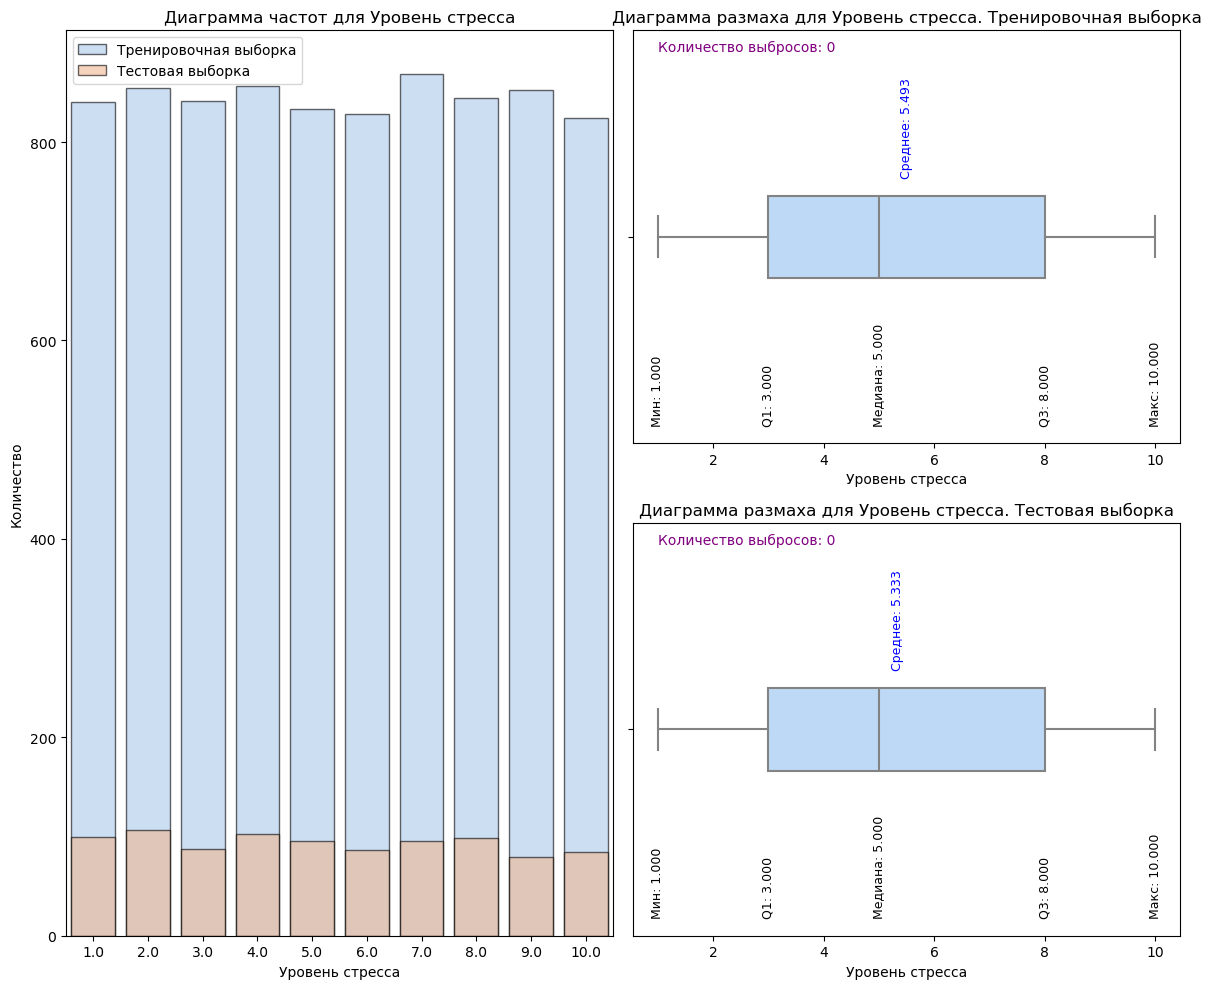

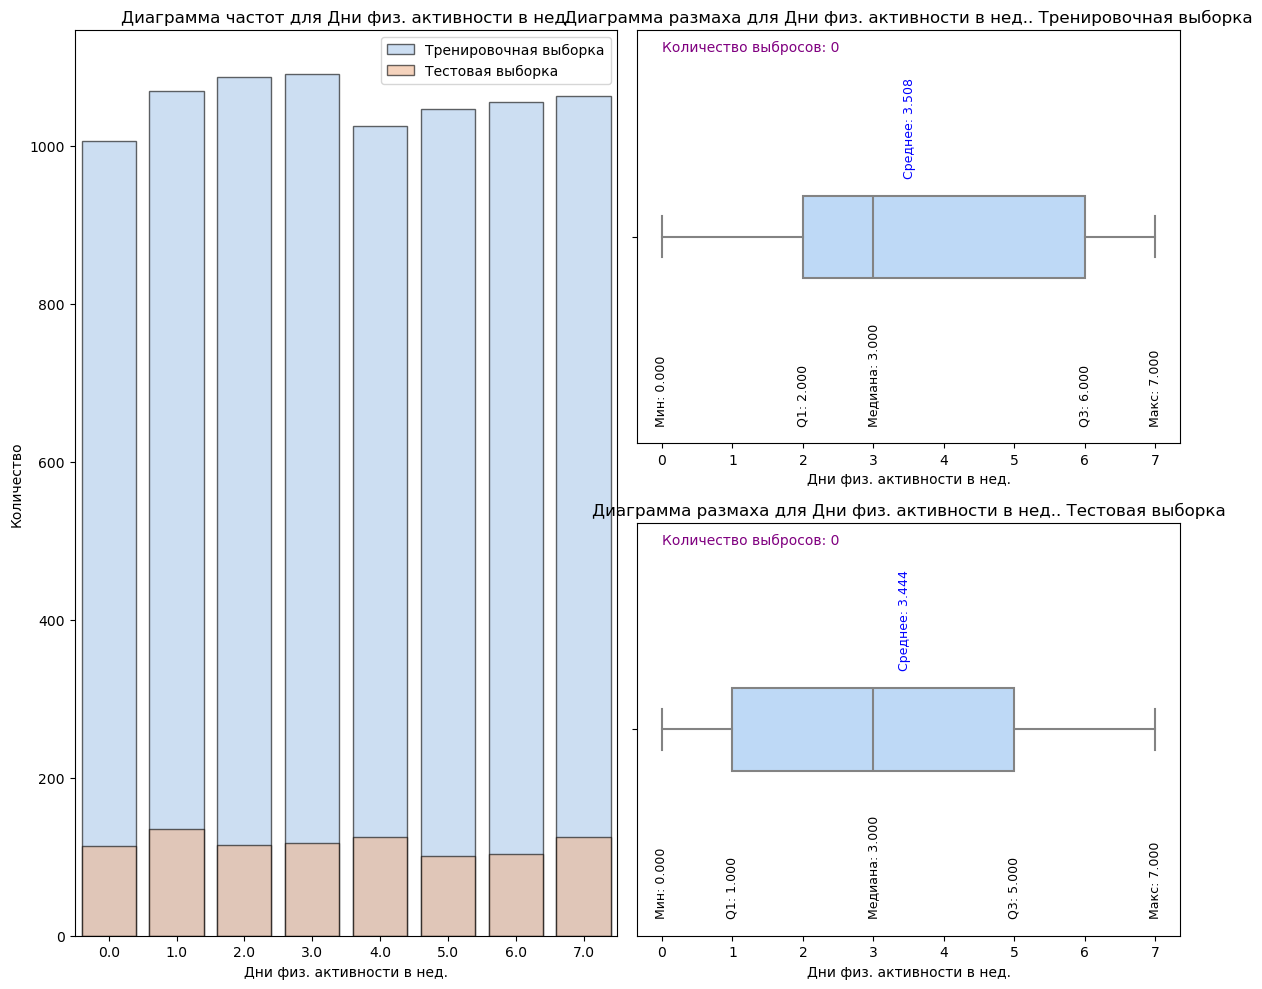

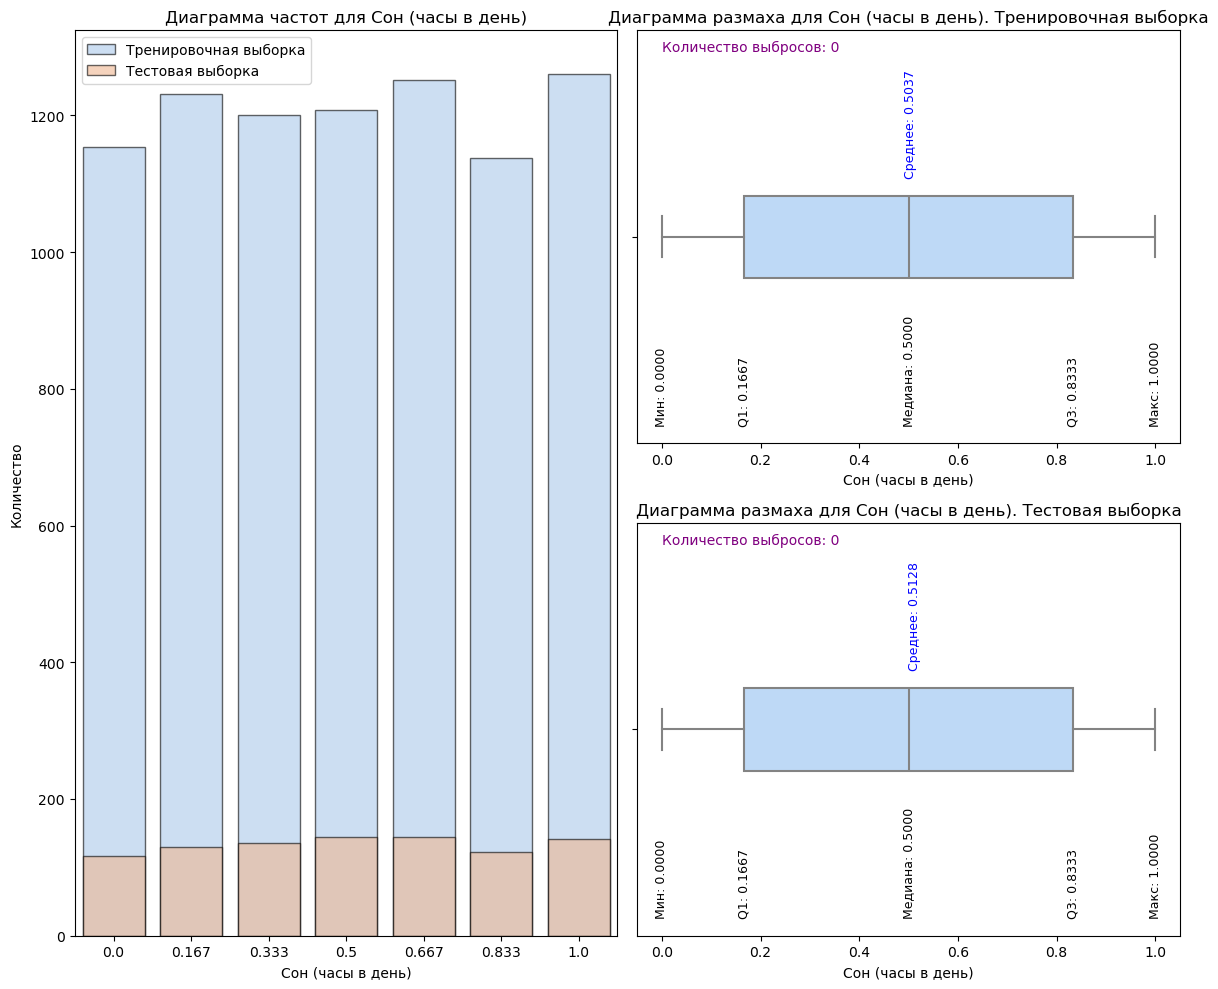

In [46]:
for feature in rus_num_features_discrete:
    show_2_plots(train_df_rus, test_df_rus, feature, 'bars')

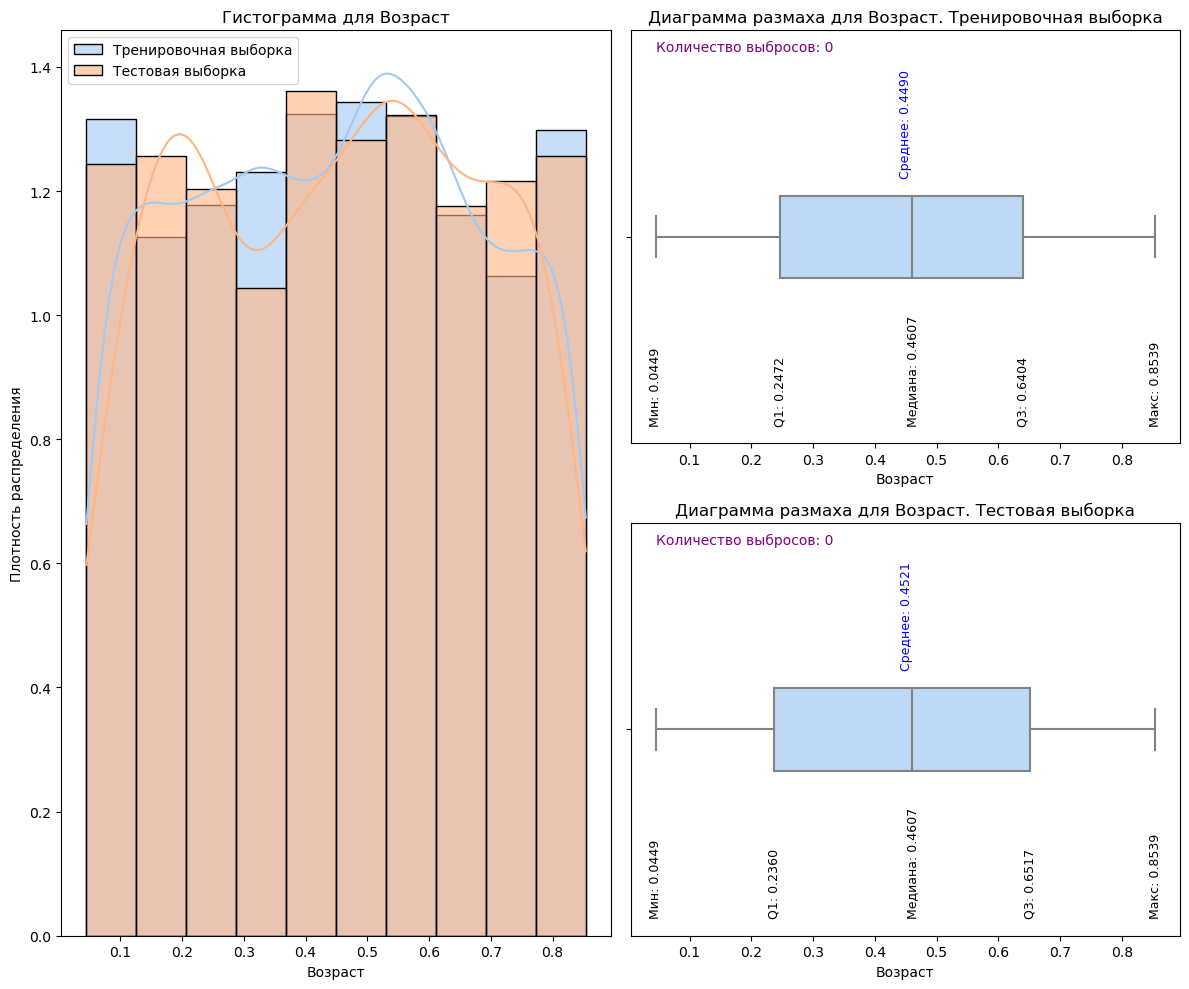

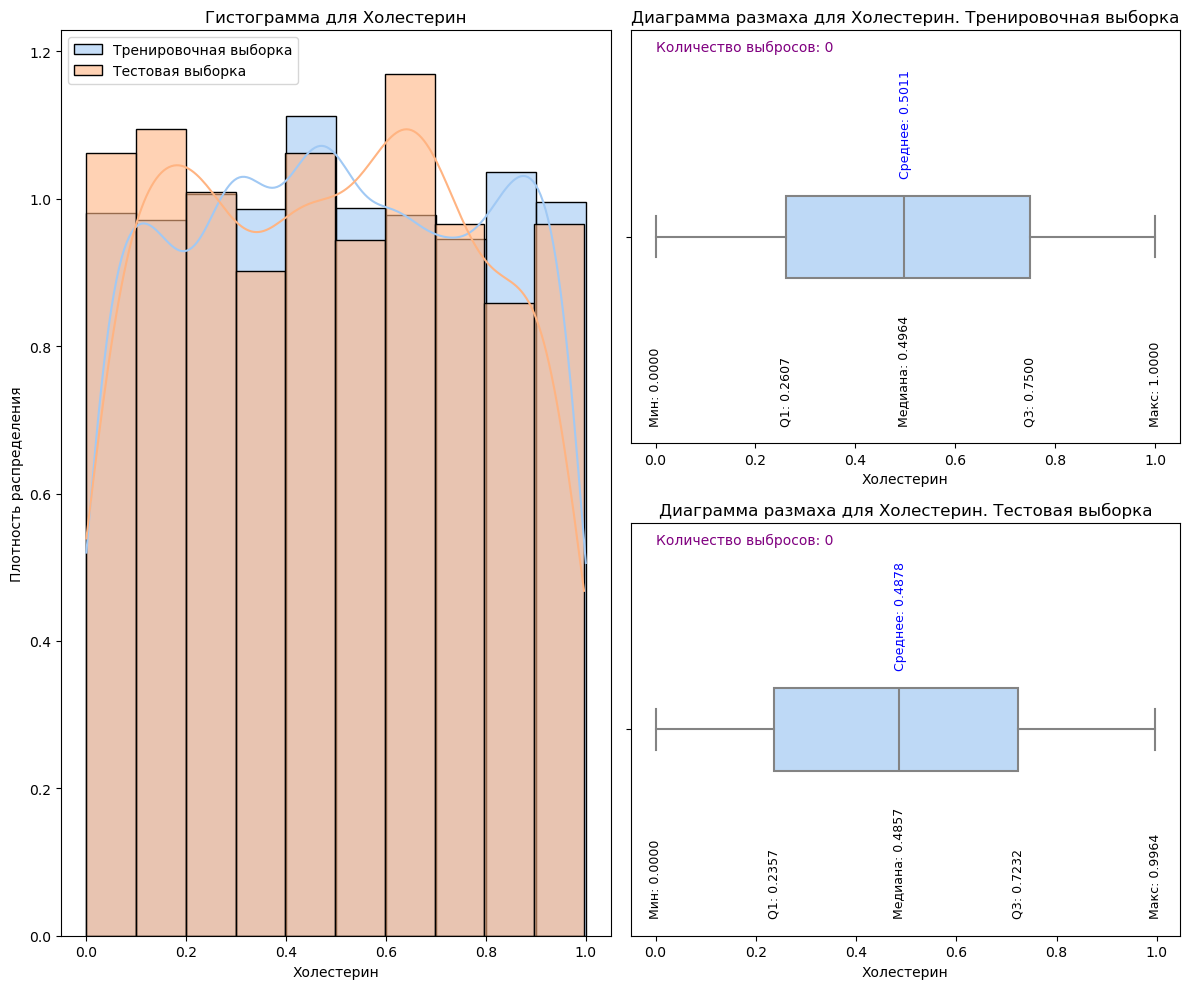

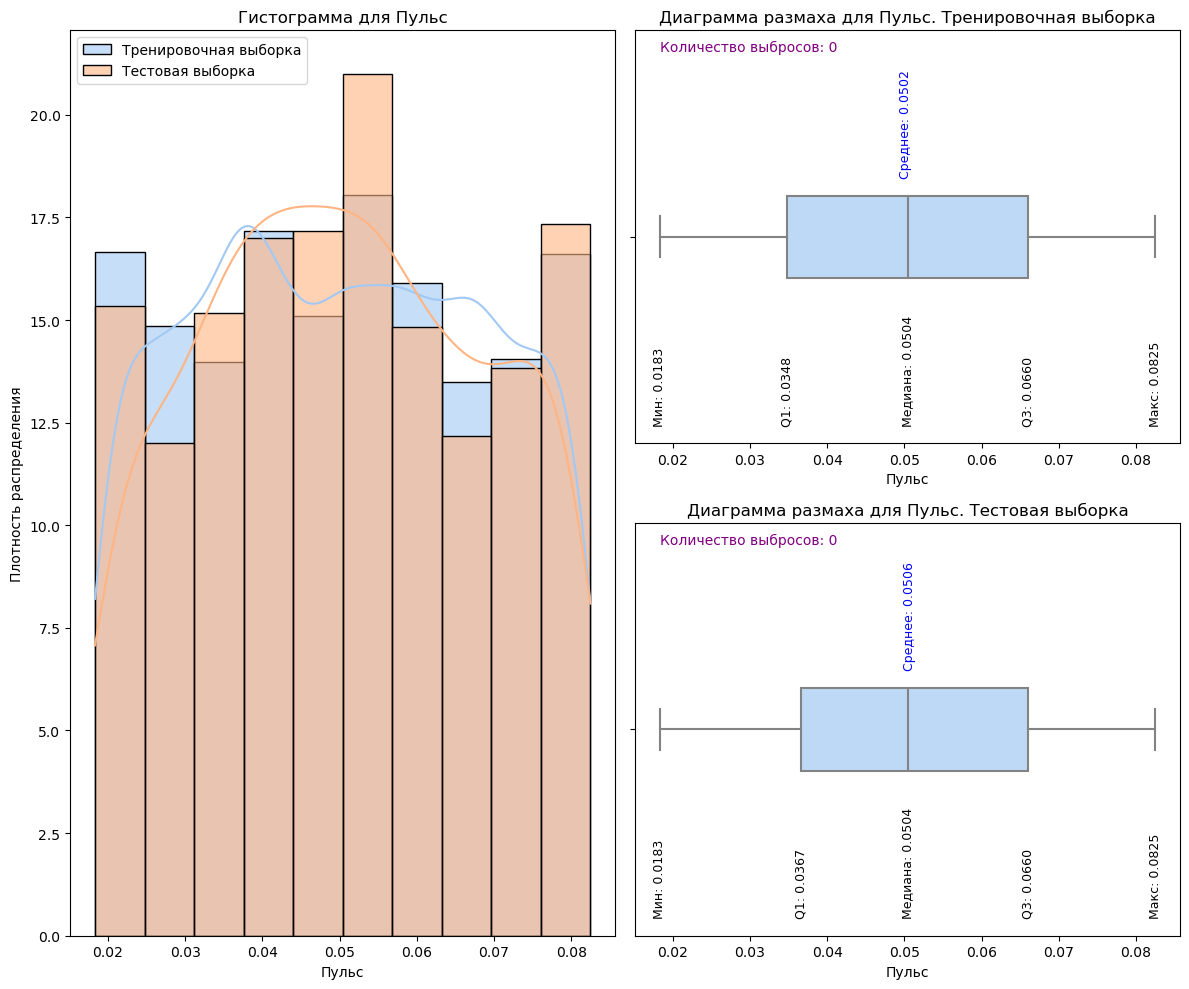

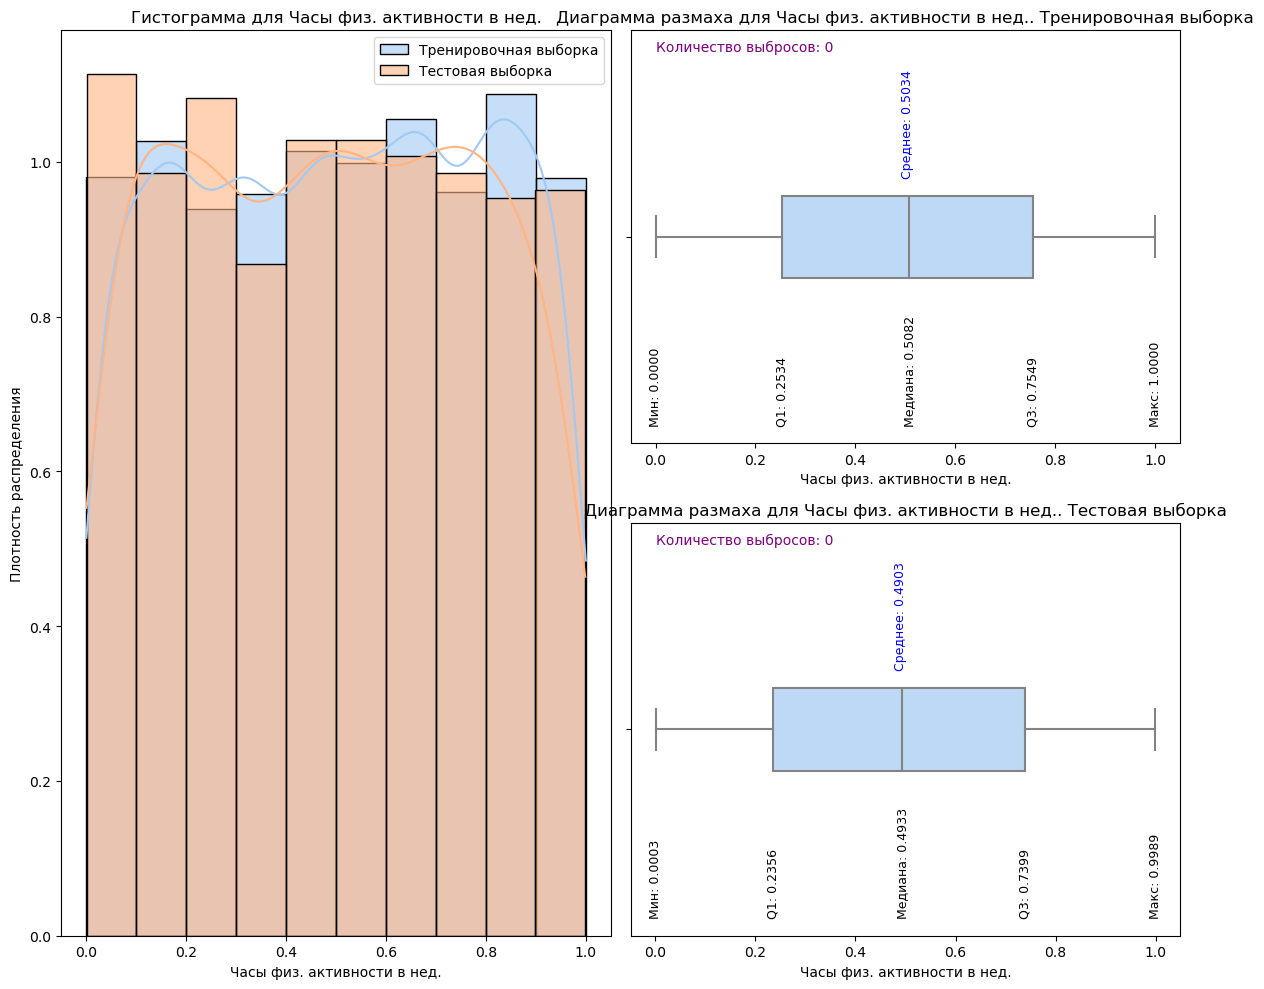

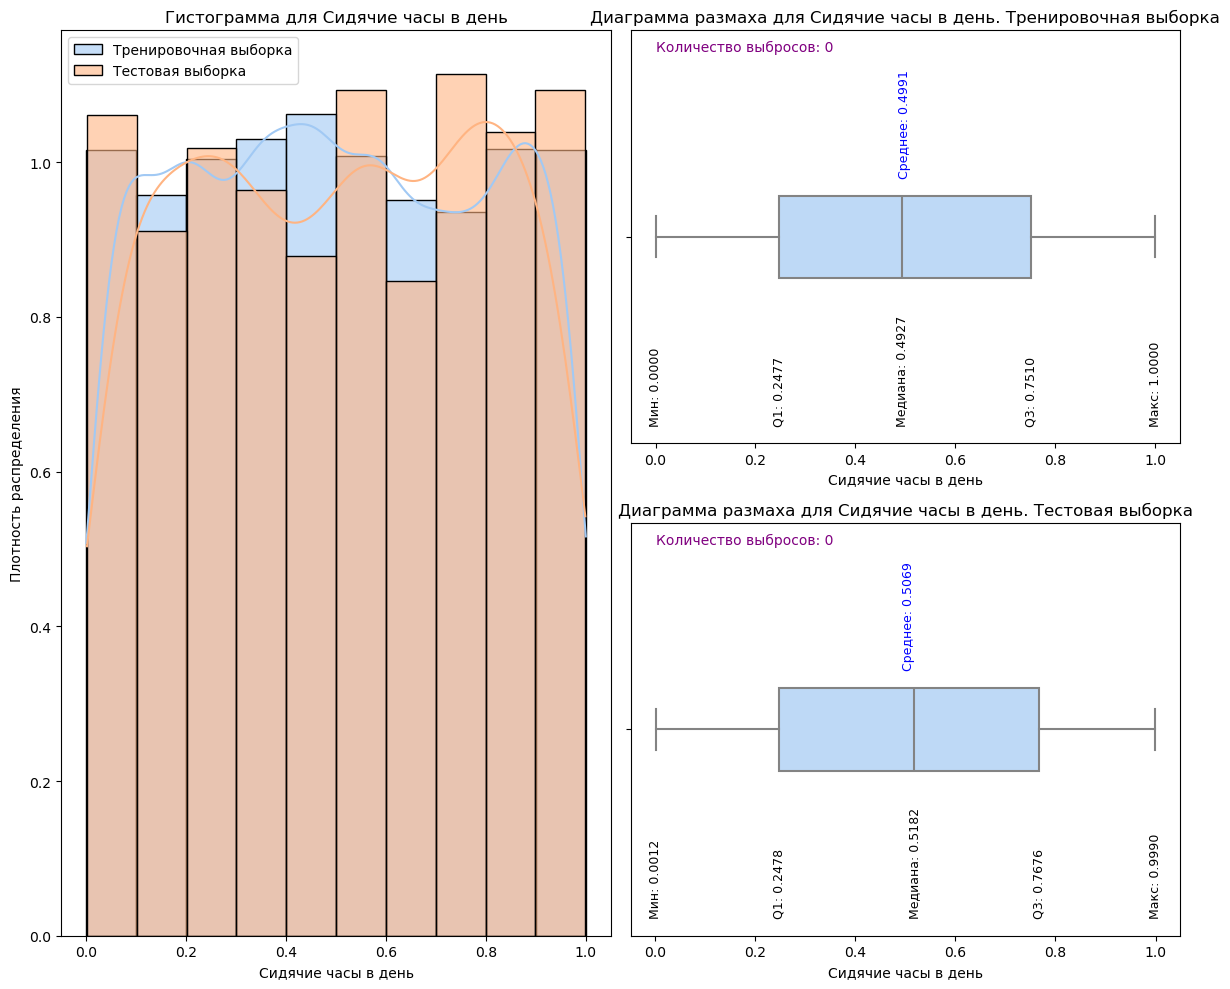

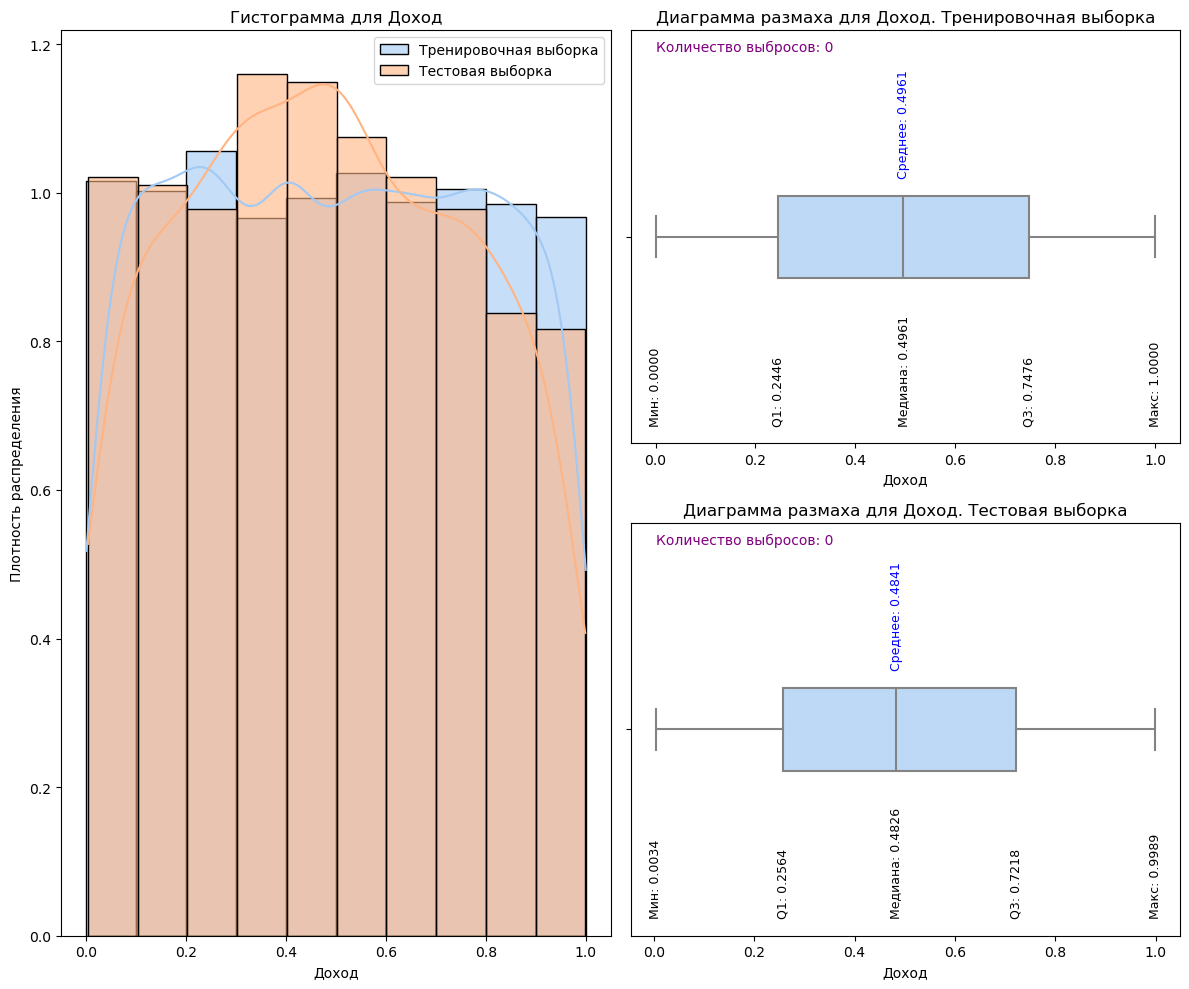

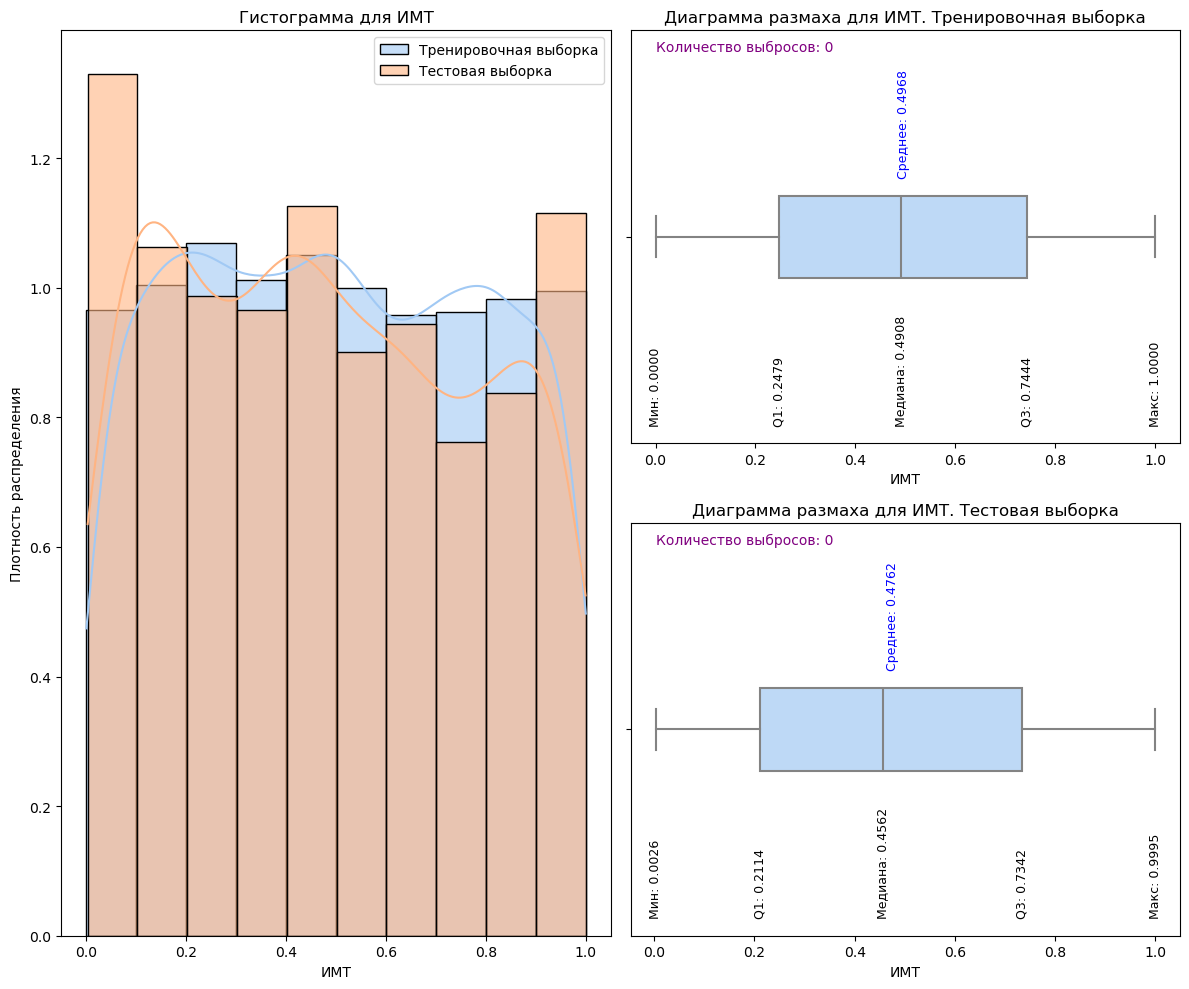

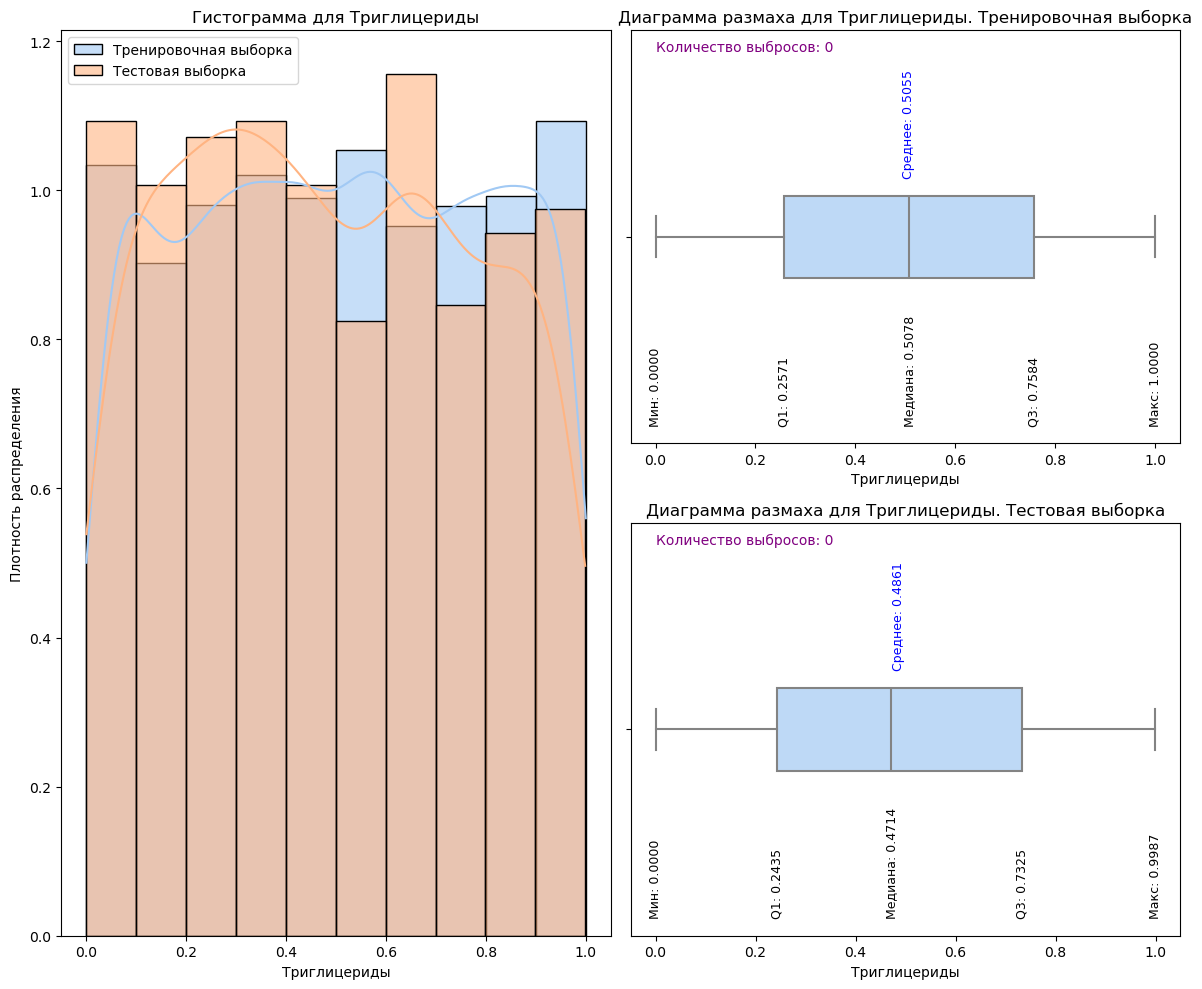

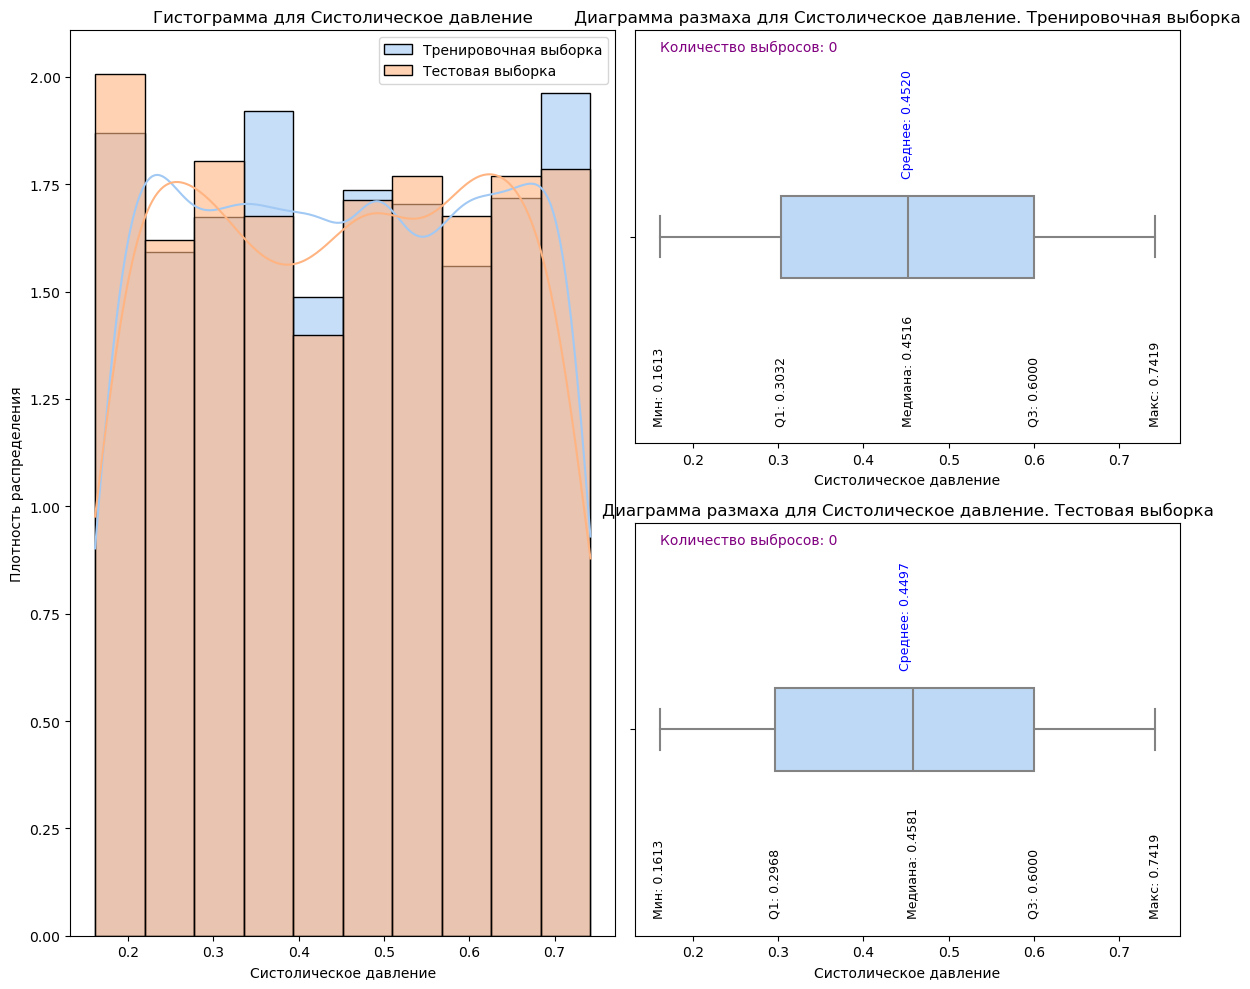

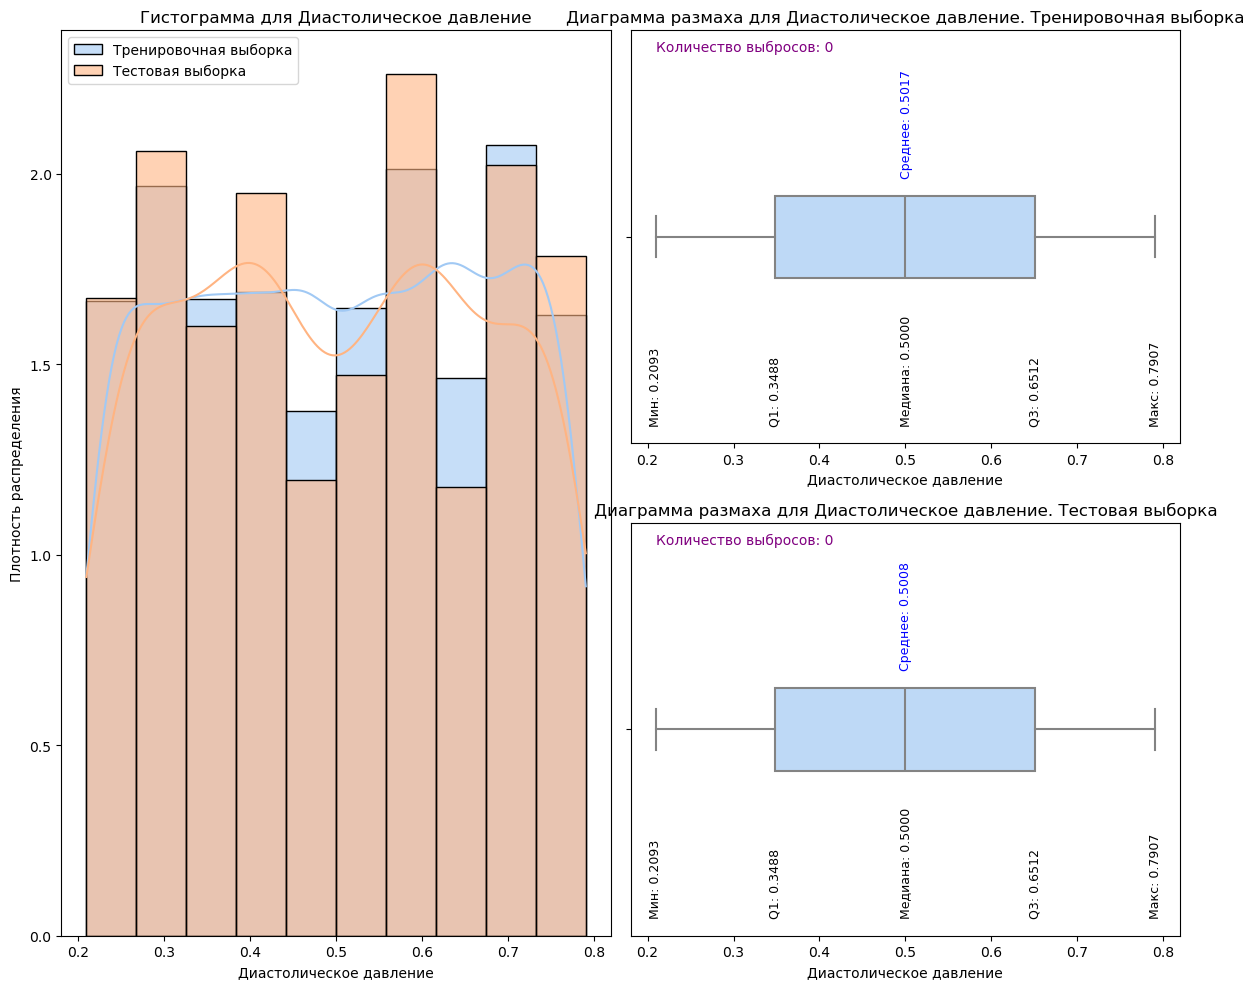

In [47]:
for feature in rus_num_features_continuous_1:
    show_2_plots(train_df_rus, test_df_rus, feature, new_bins=10, new_stat='density', new_common_norm=False)

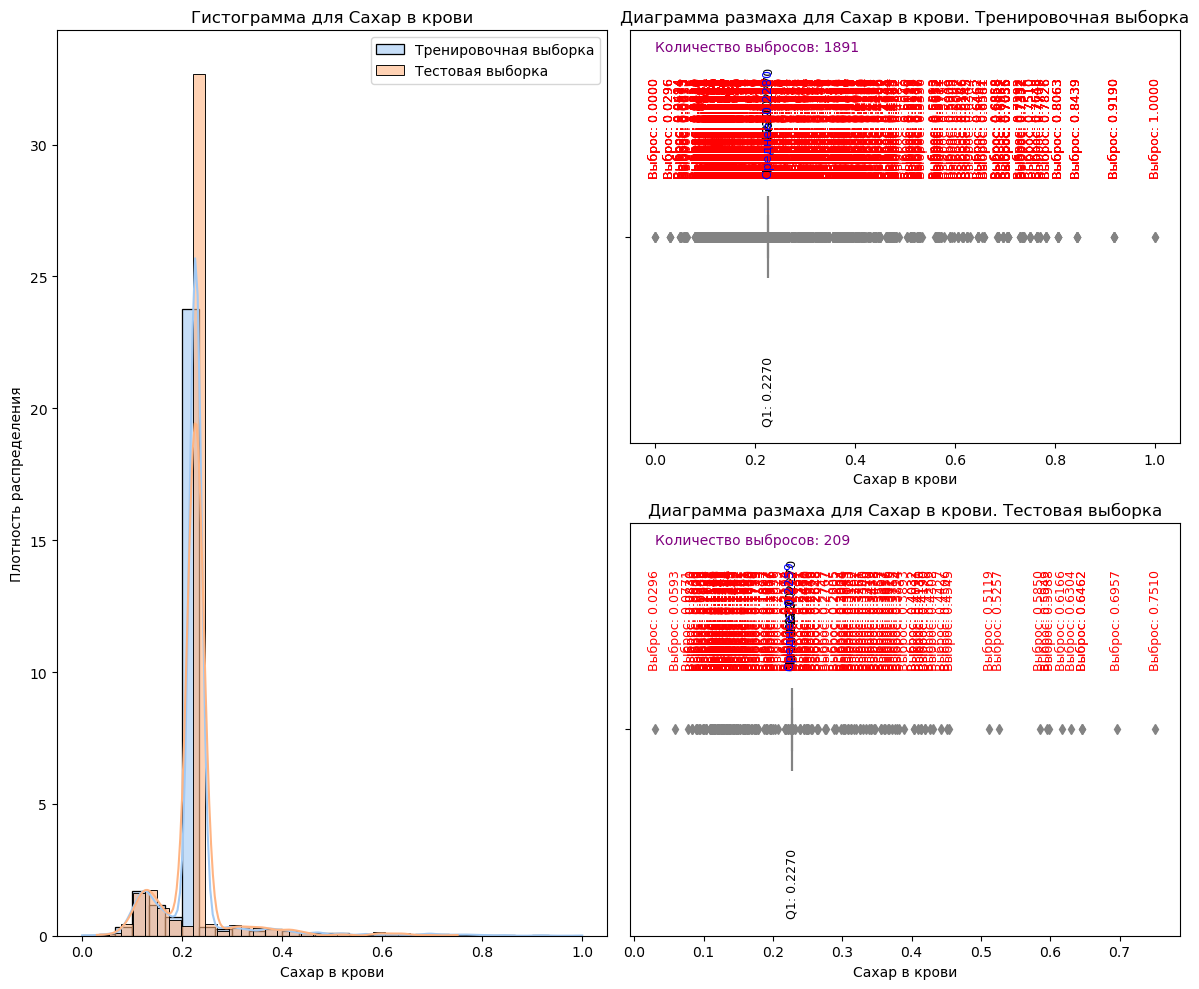

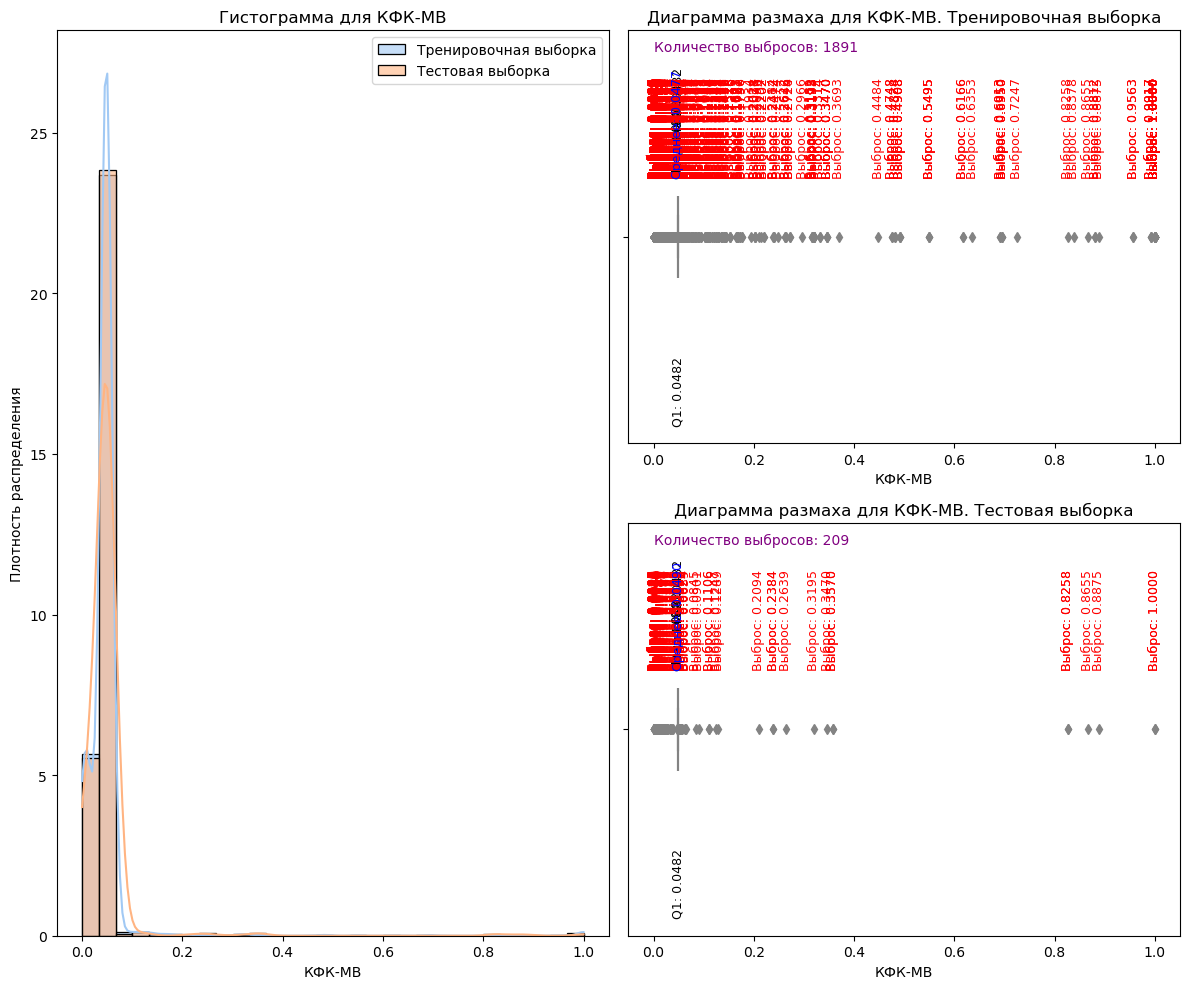

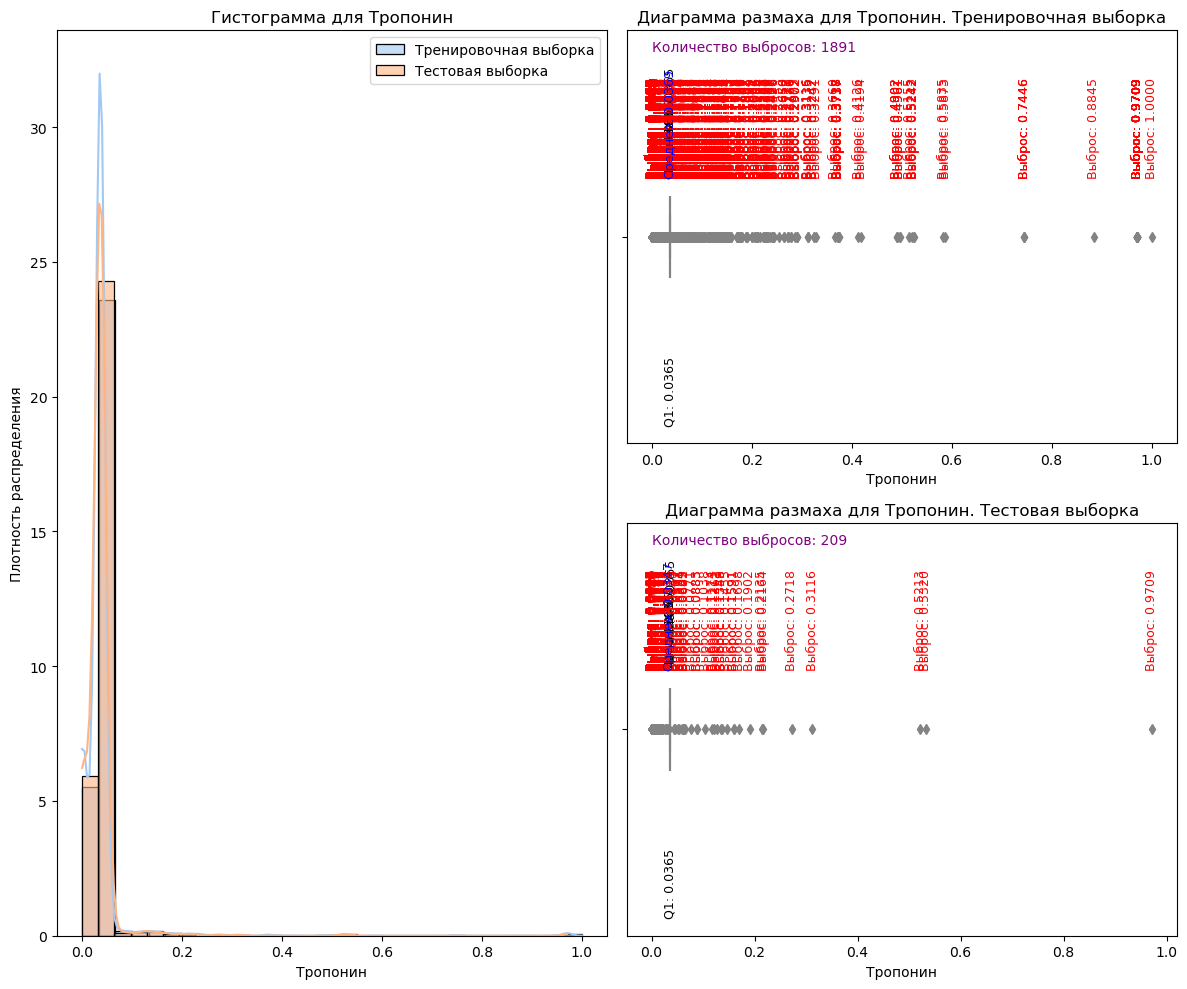

In [48]:
for feature in rus_num_features_continuous_2:
    show_2_plots(train_df_rus, test_df_rus, feature, new_bins=30, new_stat='density', new_common_norm=False)

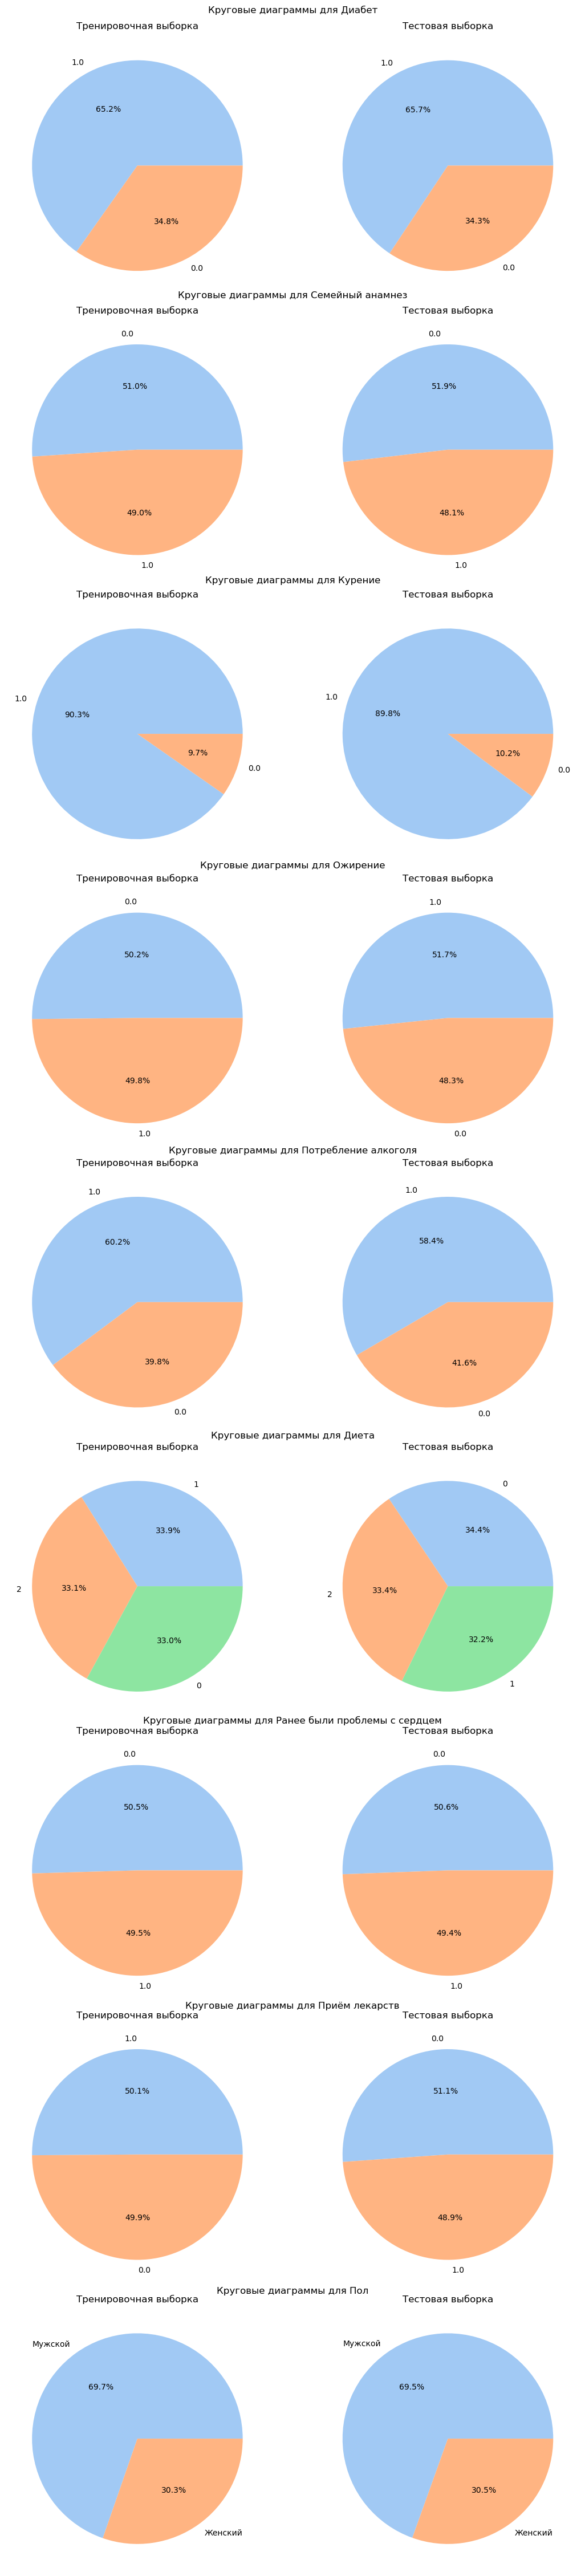

In [49]:
show_2_pies(train_df_rus, test_df_rus, rus_cat_features)

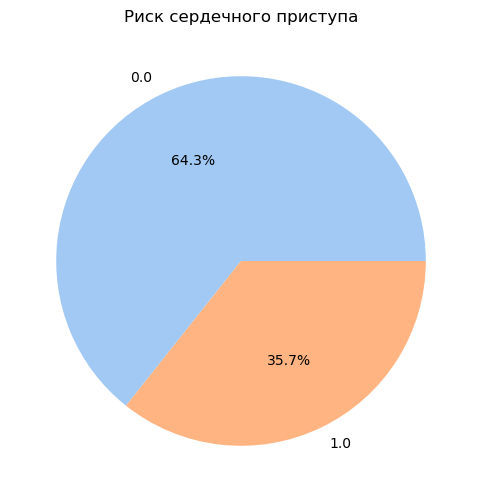

In [50]:
show_pie(train_df_rus, rus_target_feature[0], rus_target_feature[0])

Построим гистограммы и диаграммы размаха для всех количественных признаков с разбивкой по таргету.

Для количественных признаков с непрерывными данными построим гистограммы и диаграммы размаха.

Для количественных признаков с дискретными данными будем выводить столбчатые диаграммы частот и диаграммы размаха.

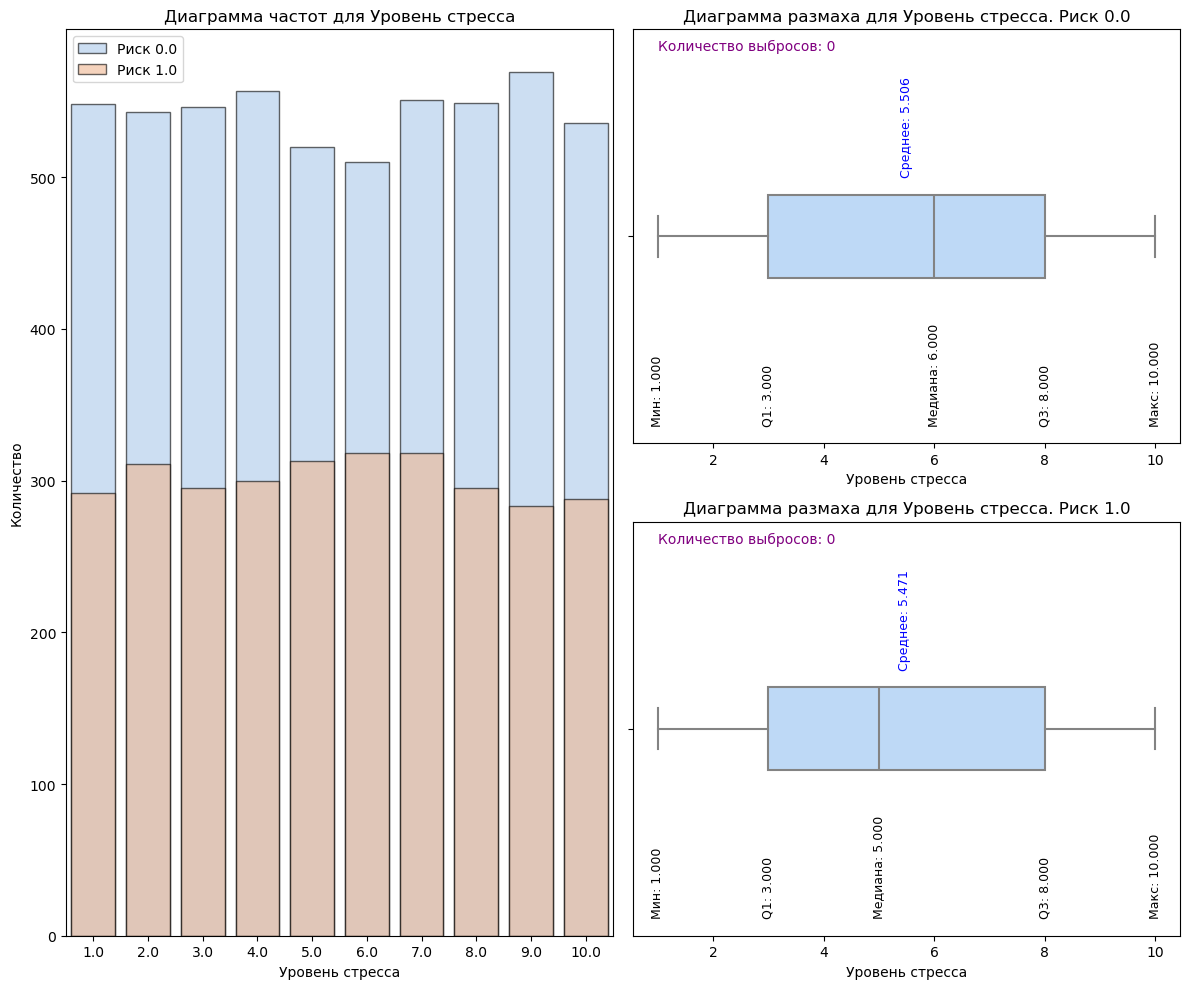

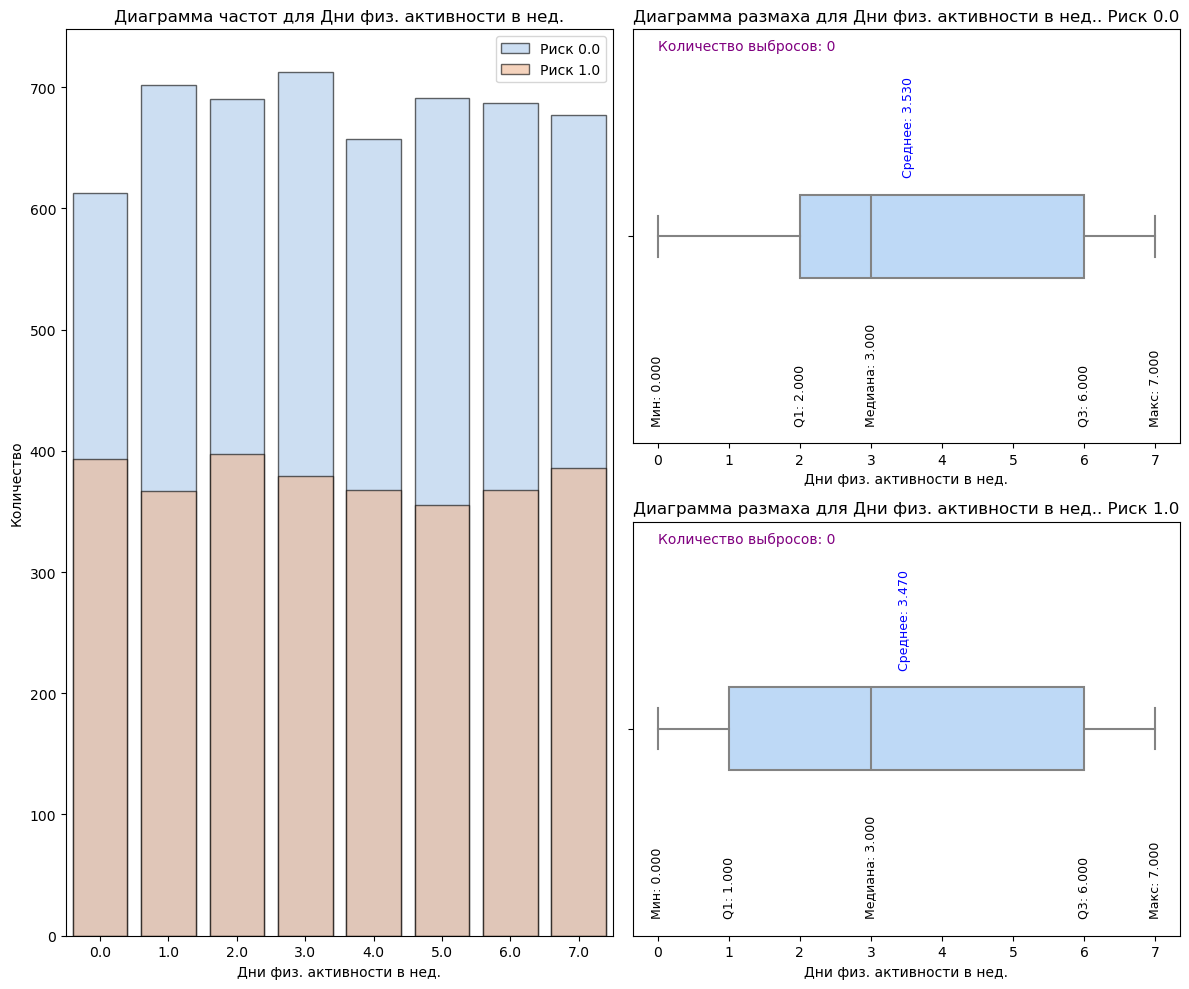

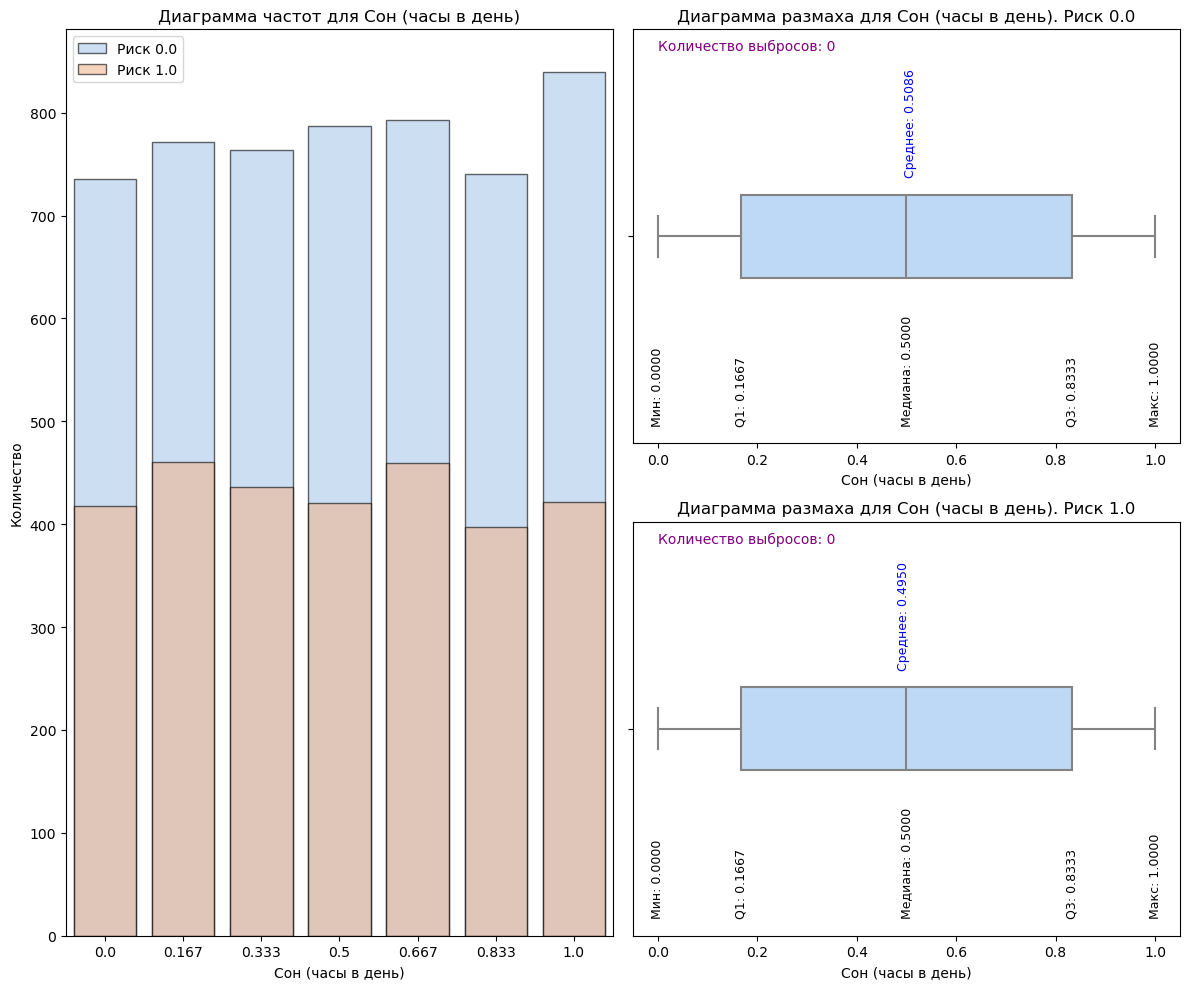

In [51]:
for feature in rus_num_features_discrete:
    show_2_plots(train_df_rus[train_df_rus['Риск сердечного приступа'] == '0.0'], 
                 train_df_rus[train_df_rus['Риск сердечного приступа'] == '1.0'], 
                 feature, 
                 'bars',
                 df_label='Риск 0.0', 
                 df2_label='Риск 1.0')

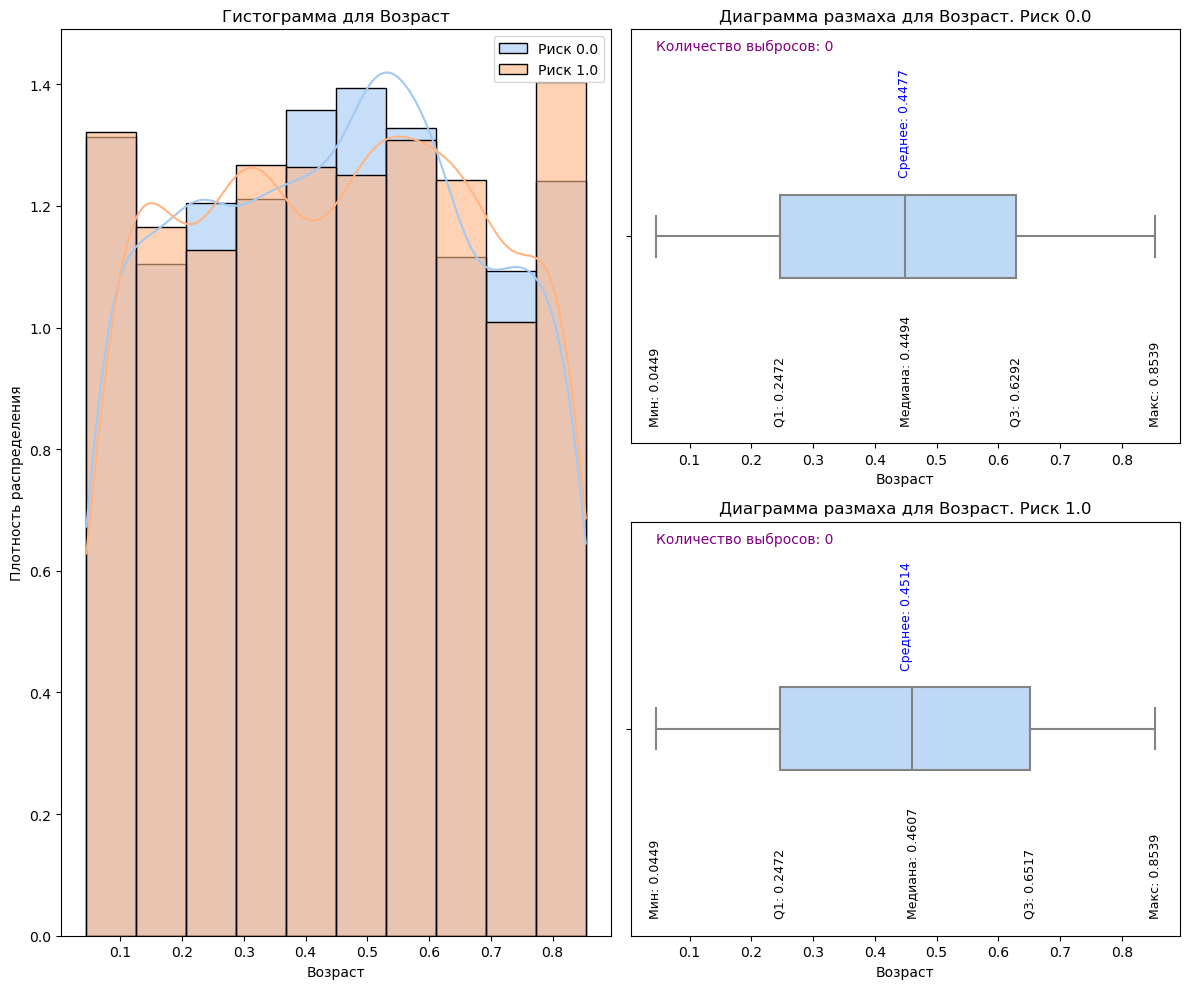

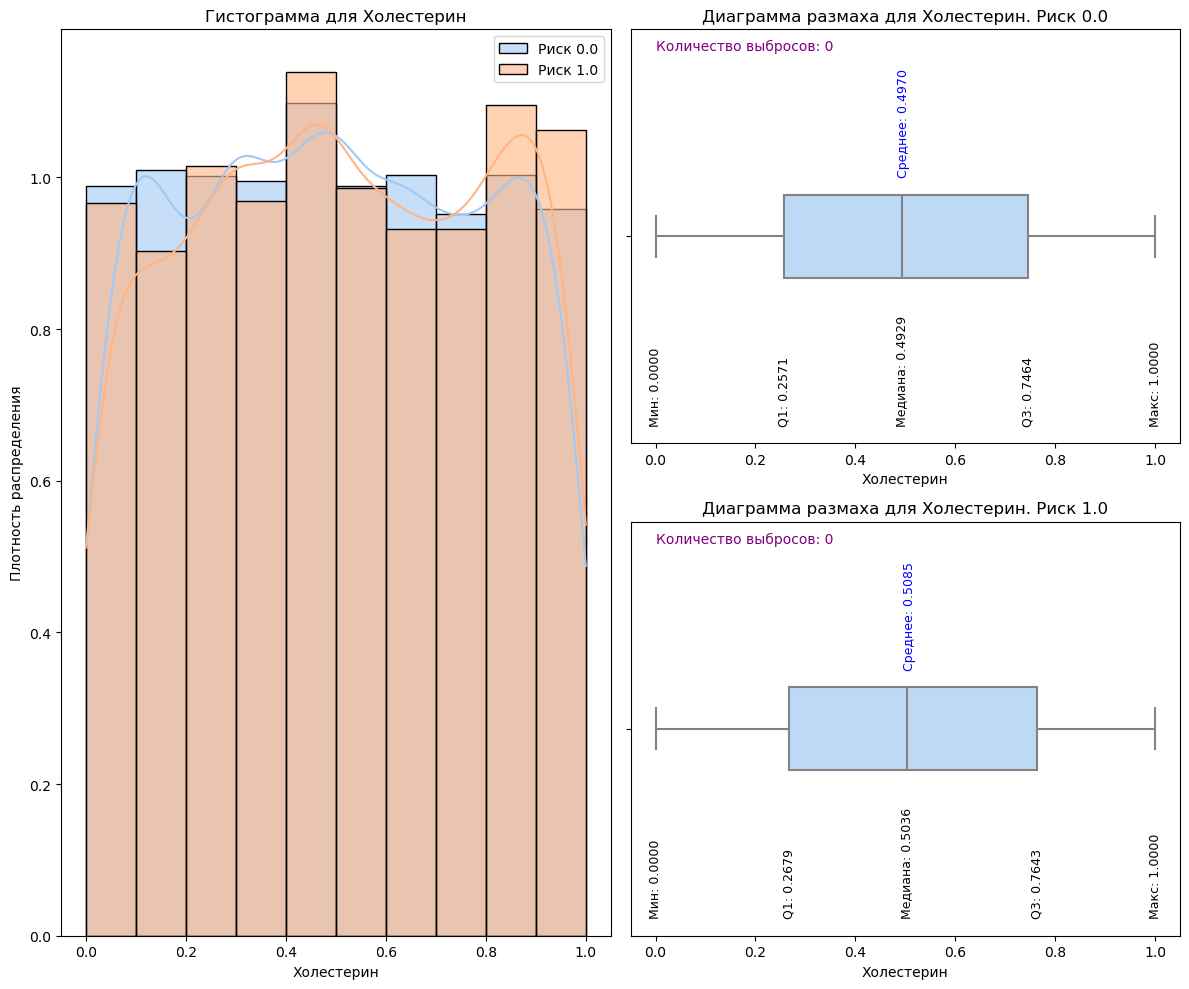

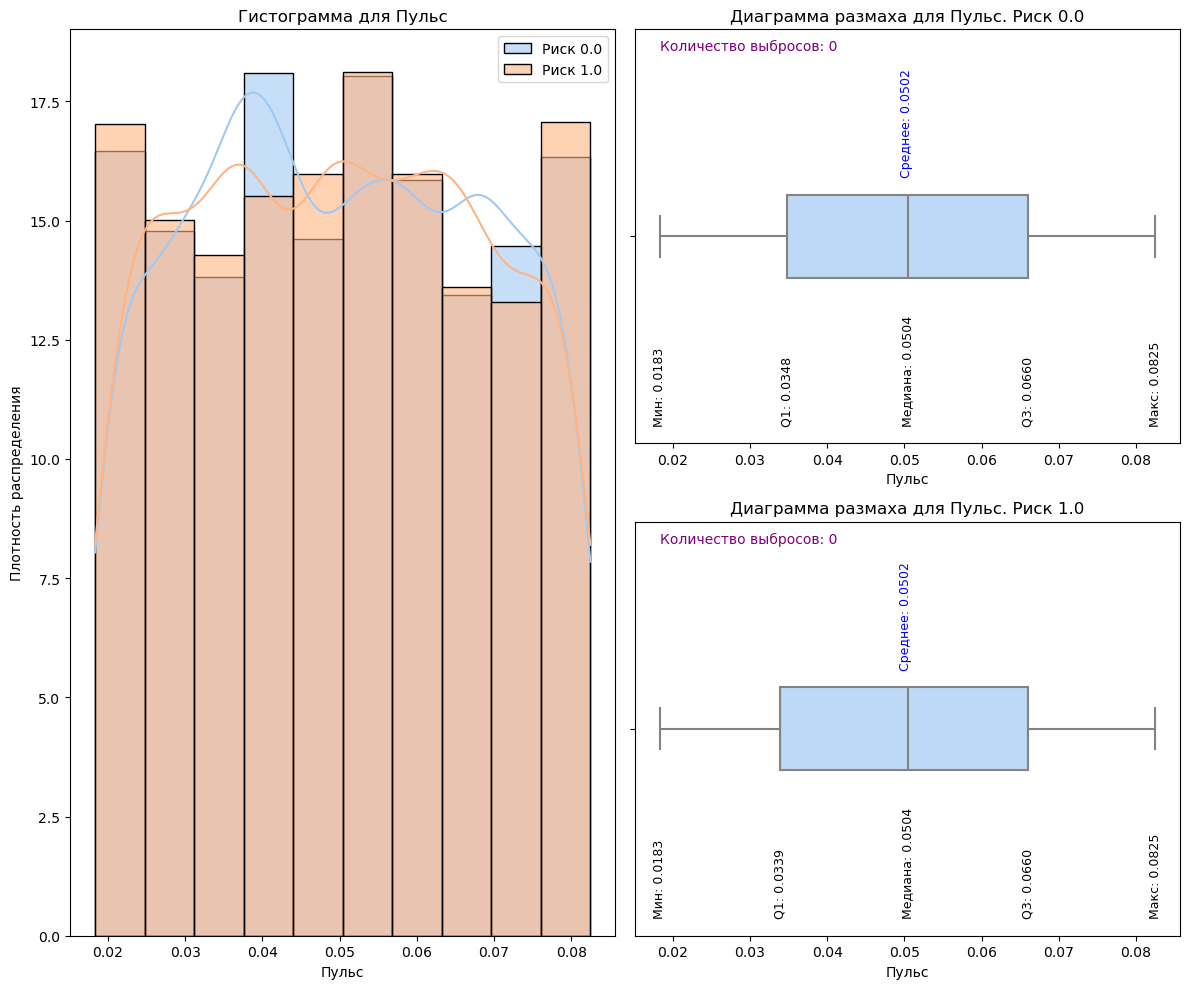

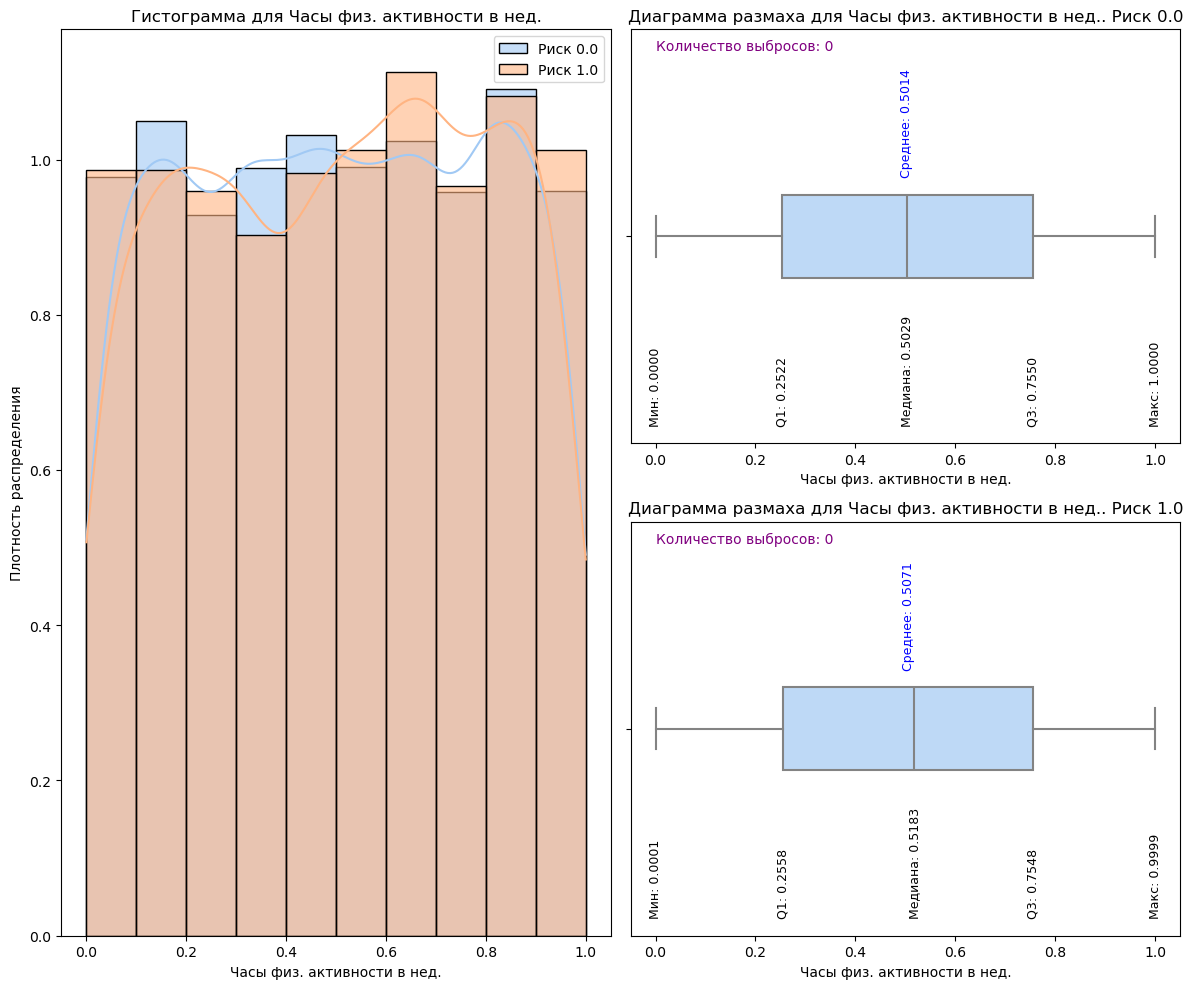

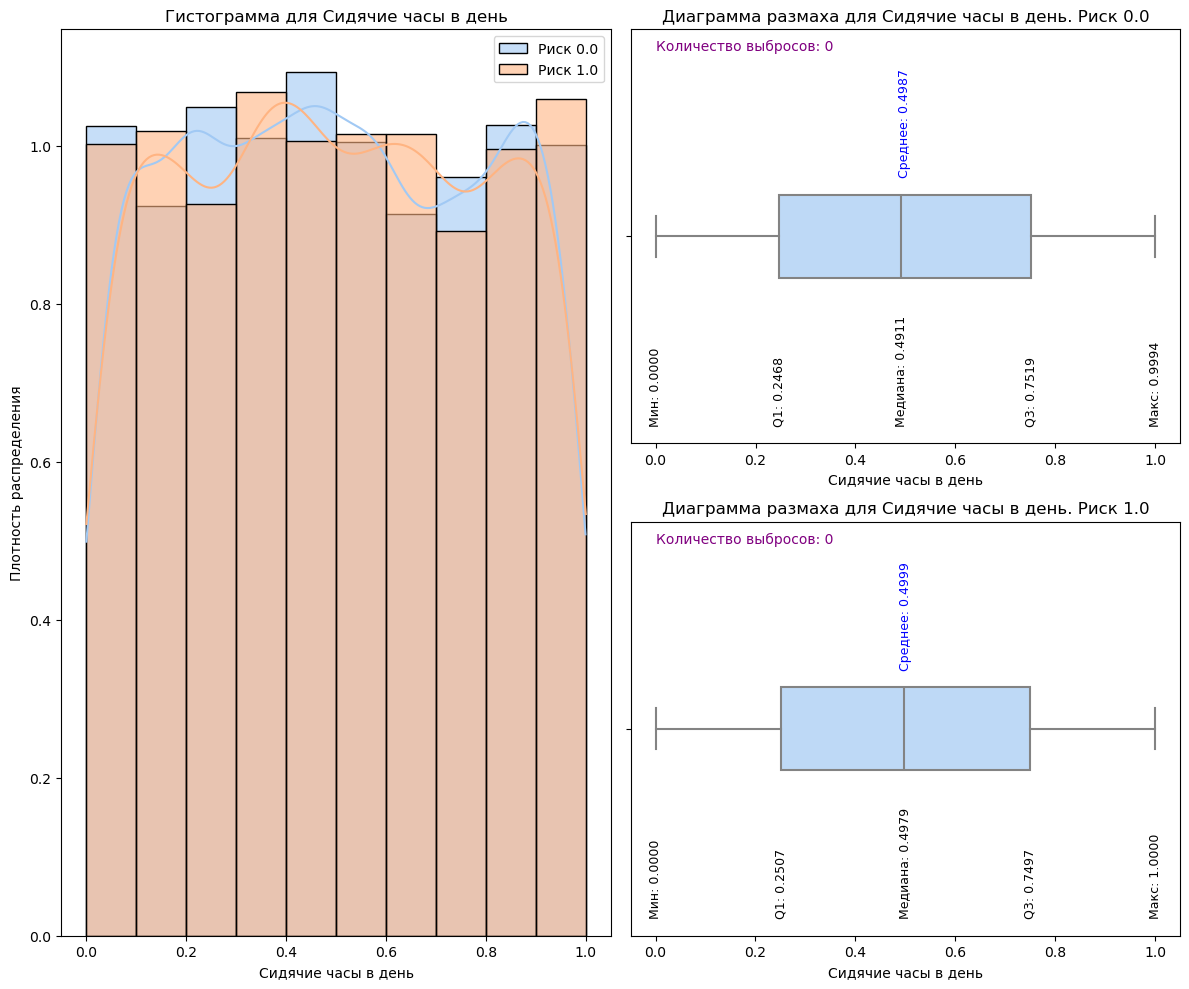

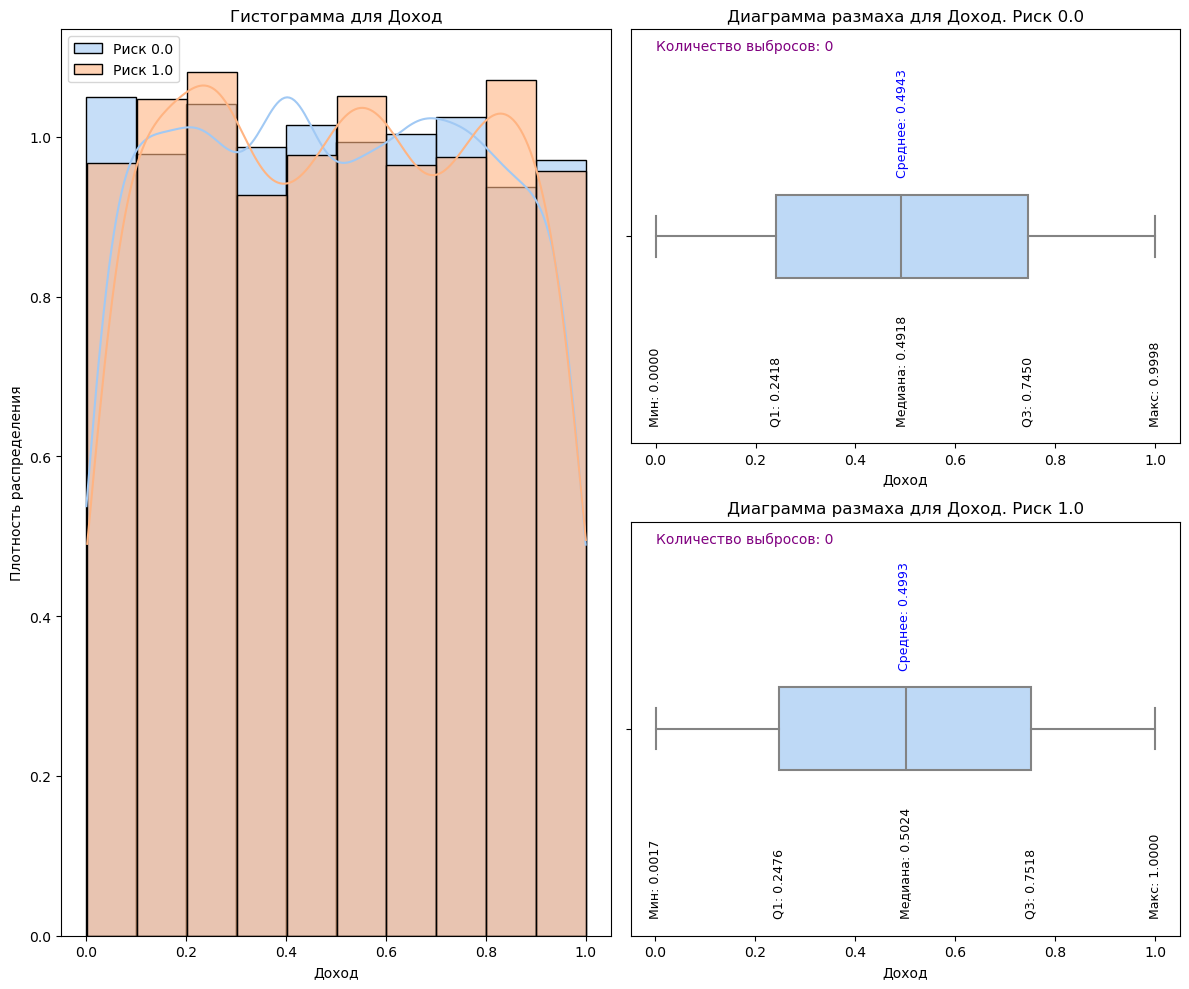

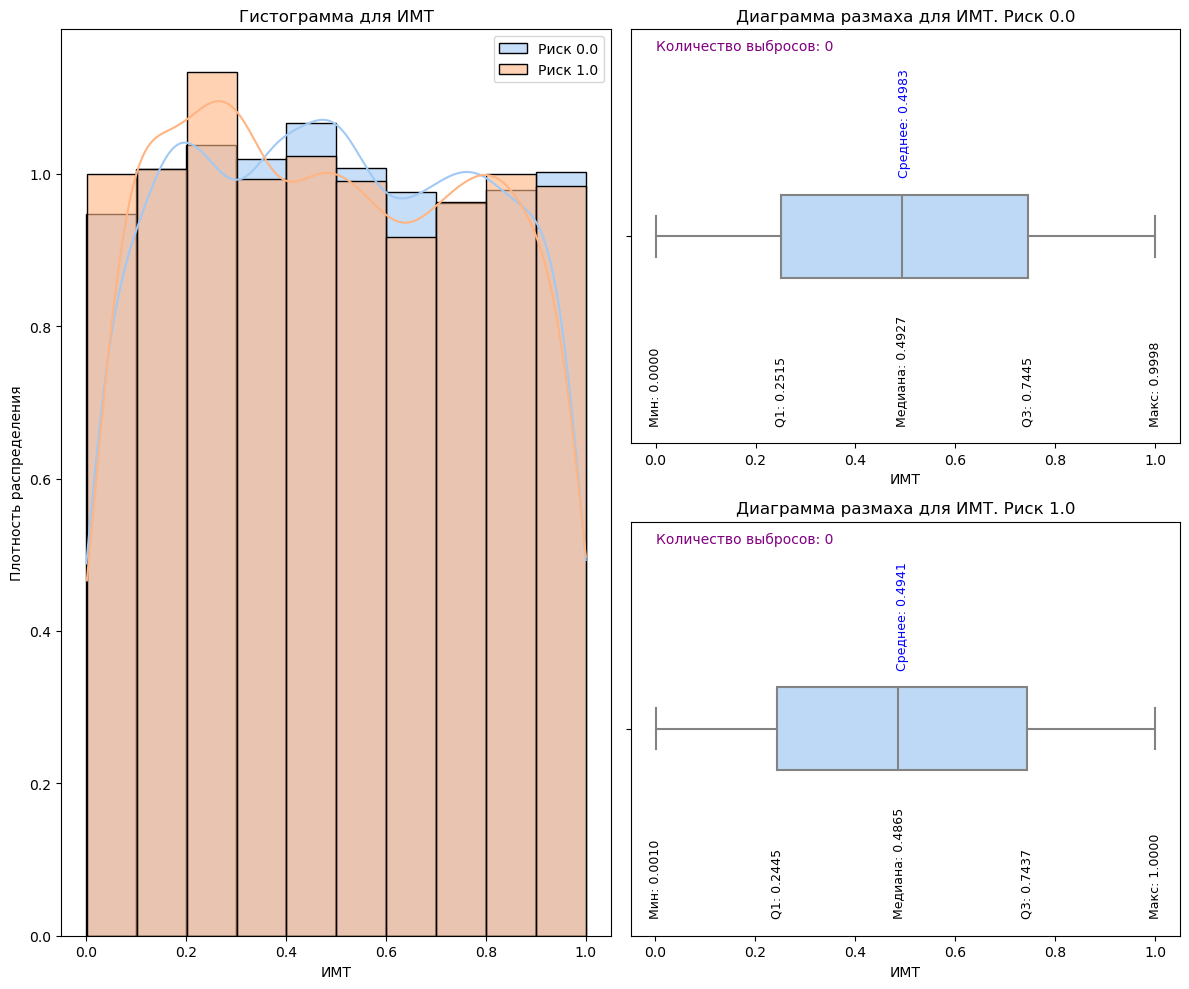

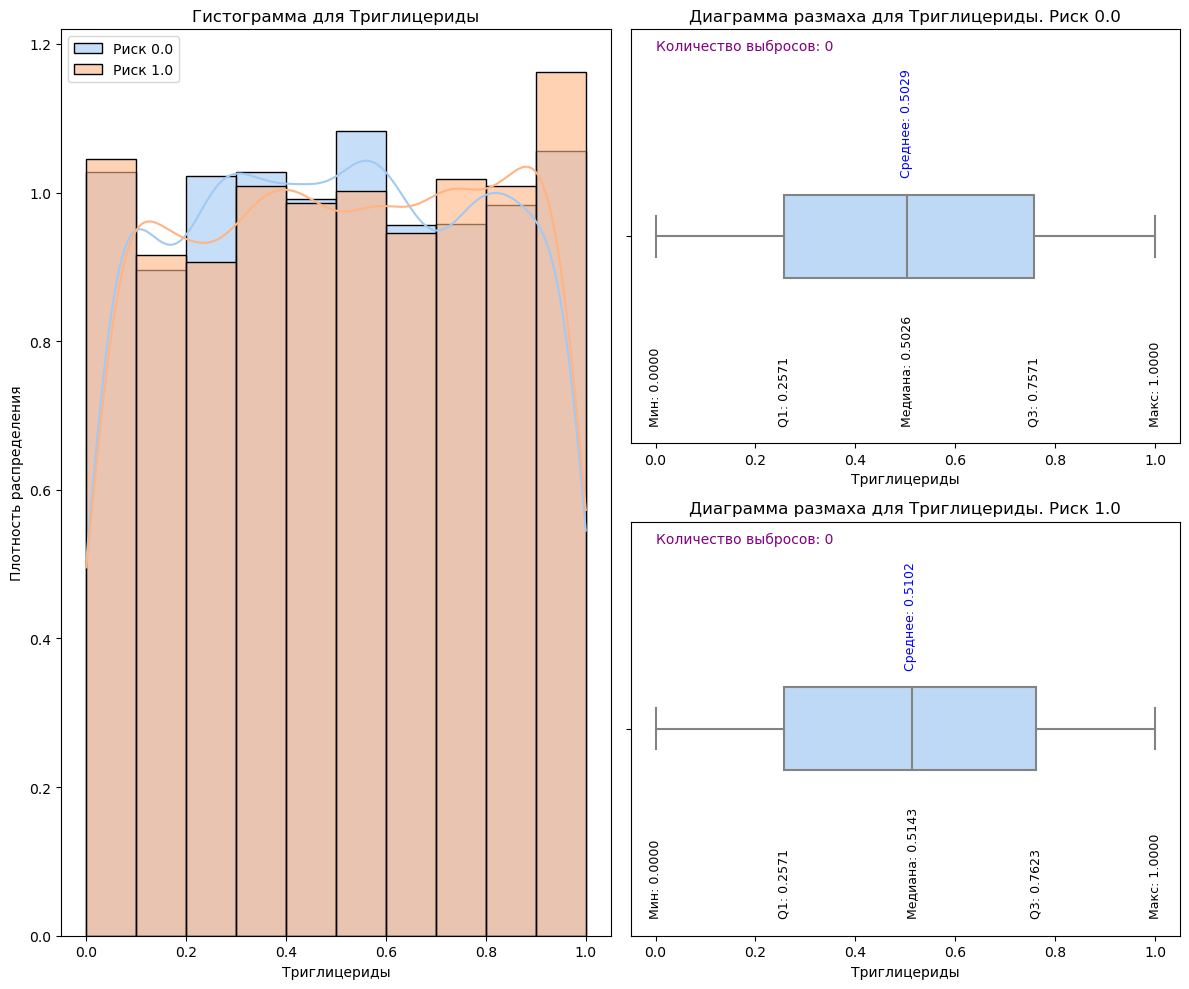

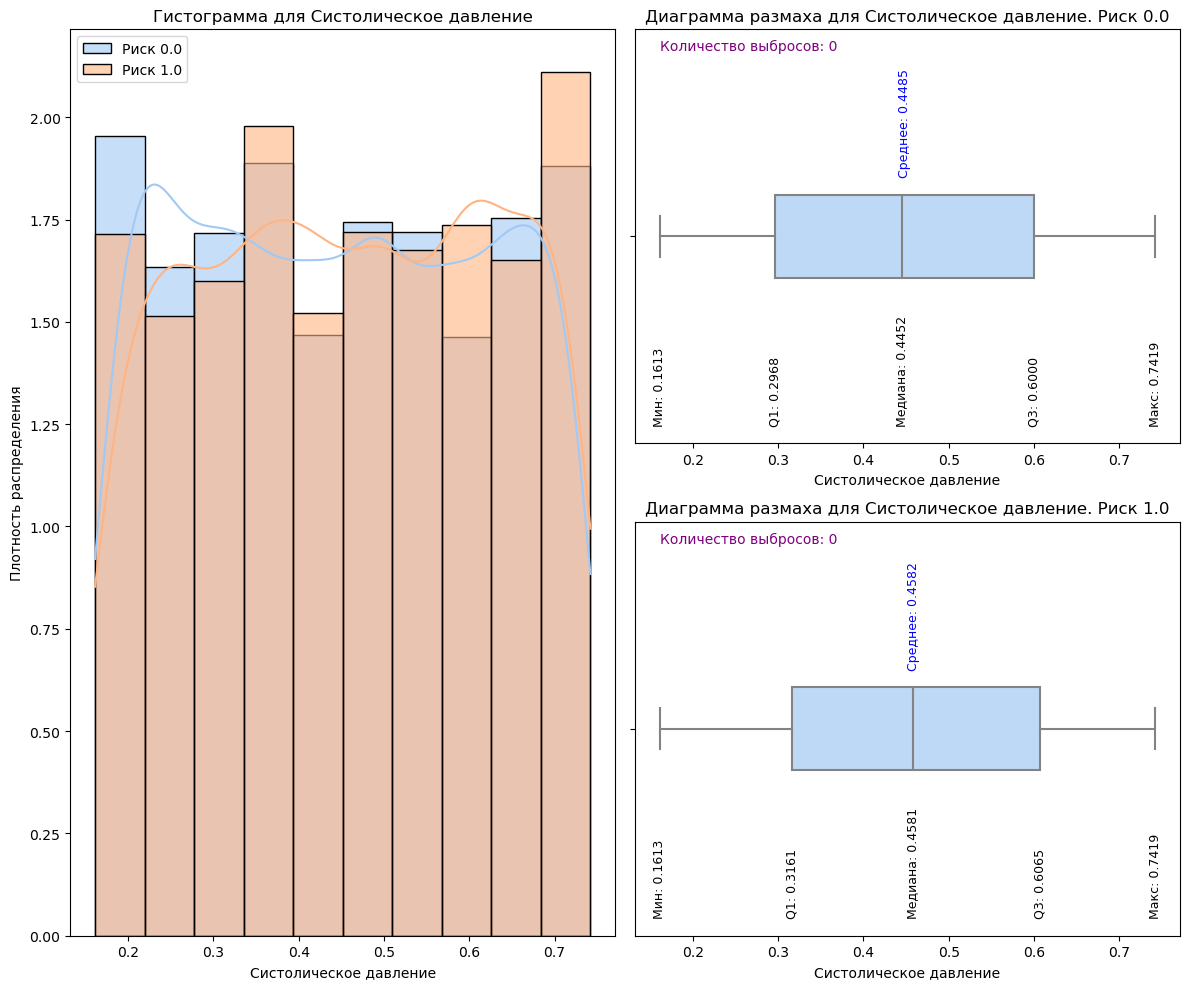

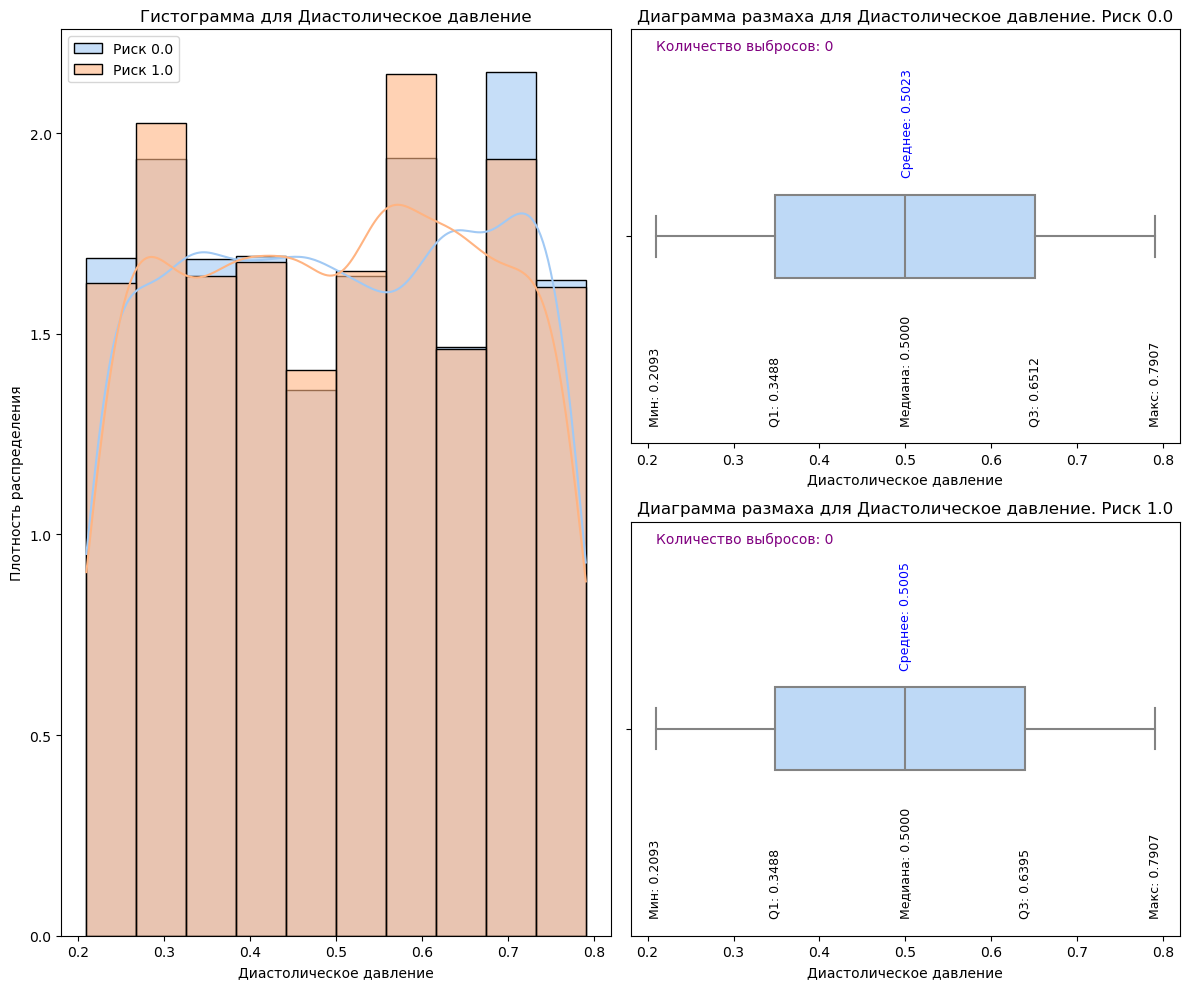

In [52]:
for feature in rus_num_features_continuous_1:
    show_2_plots(train_df_rus[train_df_rus['Риск сердечного приступа'] == '0.0'], 
                 train_df_rus[train_df_rus['Риск сердечного приступа'] == '1.0'],
                 feature, 
                 new_bins=10,
                 df_label='Риск 0.0', 
                 df2_label='Риск 1.0', 
                 new_stat='density', 
                 new_common_norm=False)

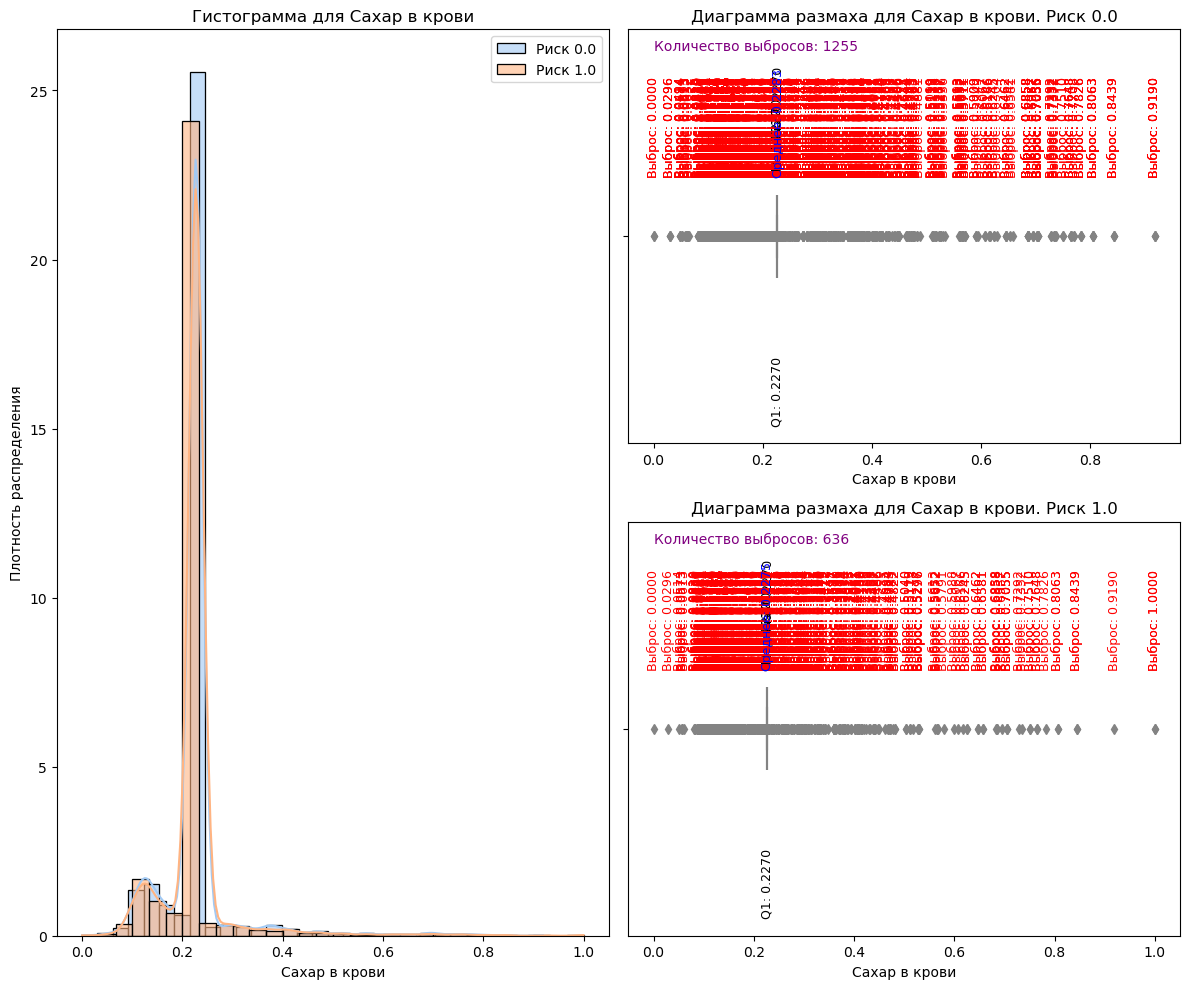

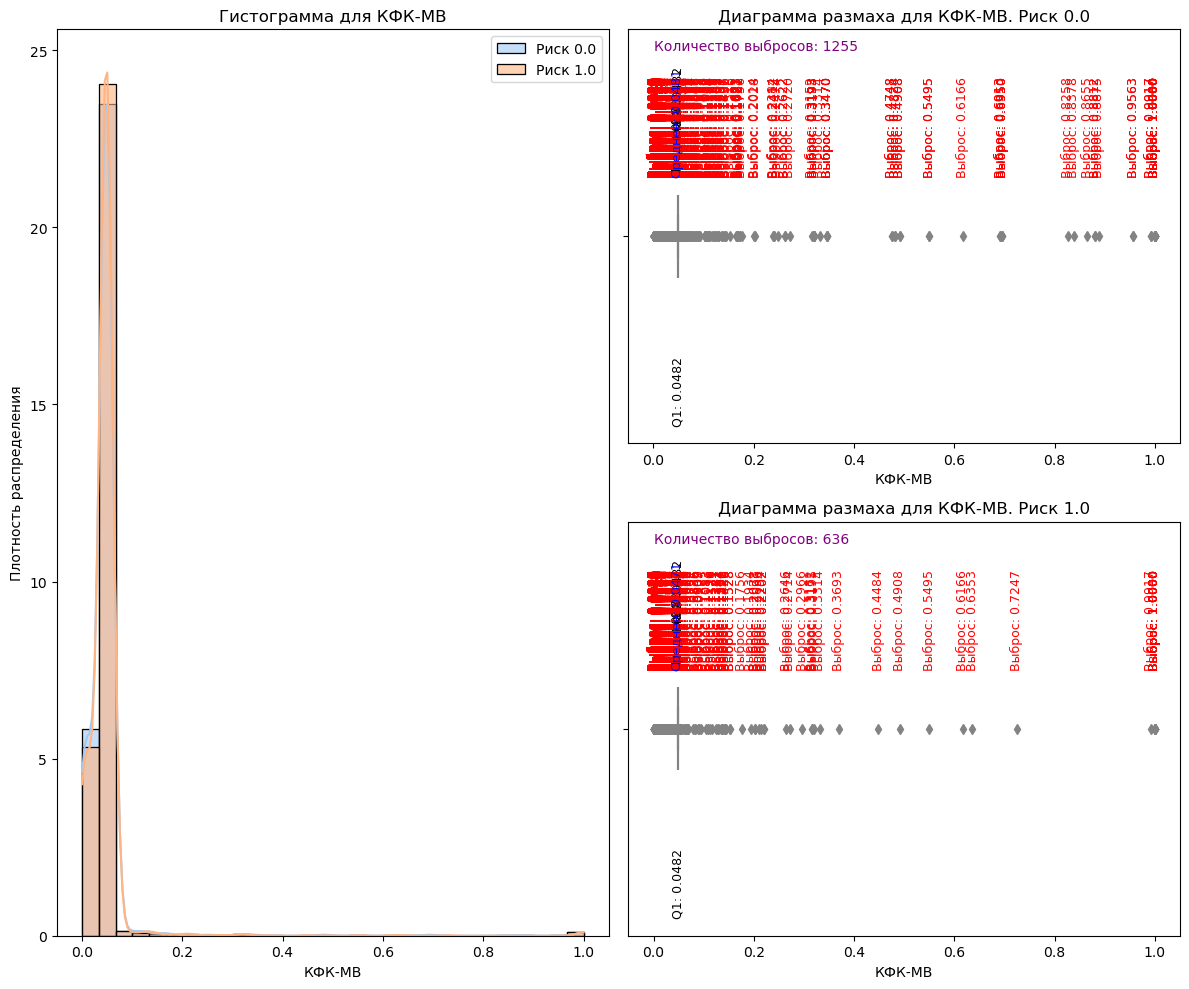

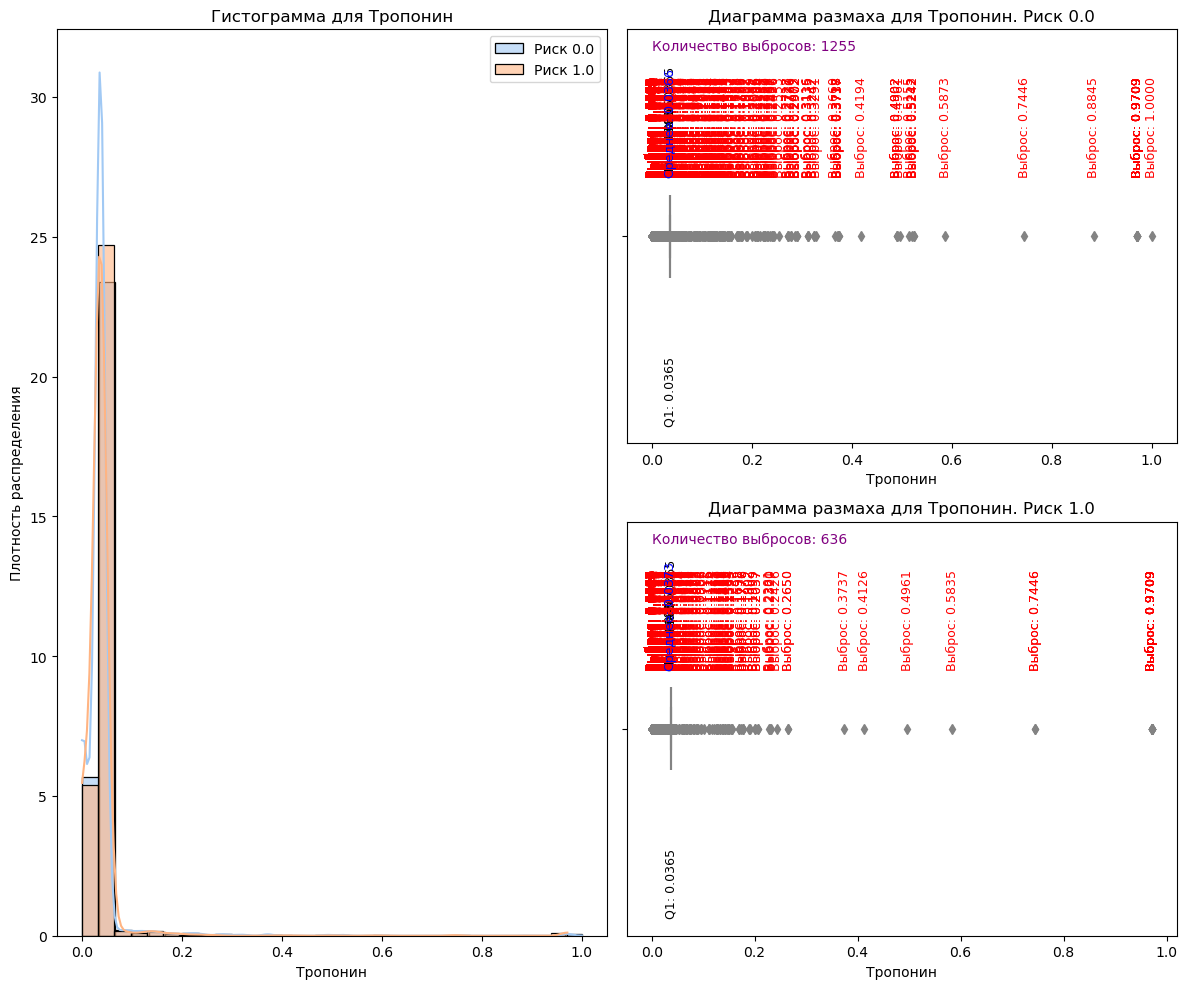

In [53]:
for feature in rus_num_features_continuous_2:
    show_2_plots(train_df_rus[train_df_rus['Риск сердечного приступа'] == '0.0'], 
                 train_df_rus[train_df_rus['Риск сердечного приступа'] == '1.0'],
                 feature, 
                 new_bins=30,
                 df_label='Риск 0.0', 
                 df2_label='Риск 1.0', 
                 new_stat='density', 
                 new_common_norm=False)

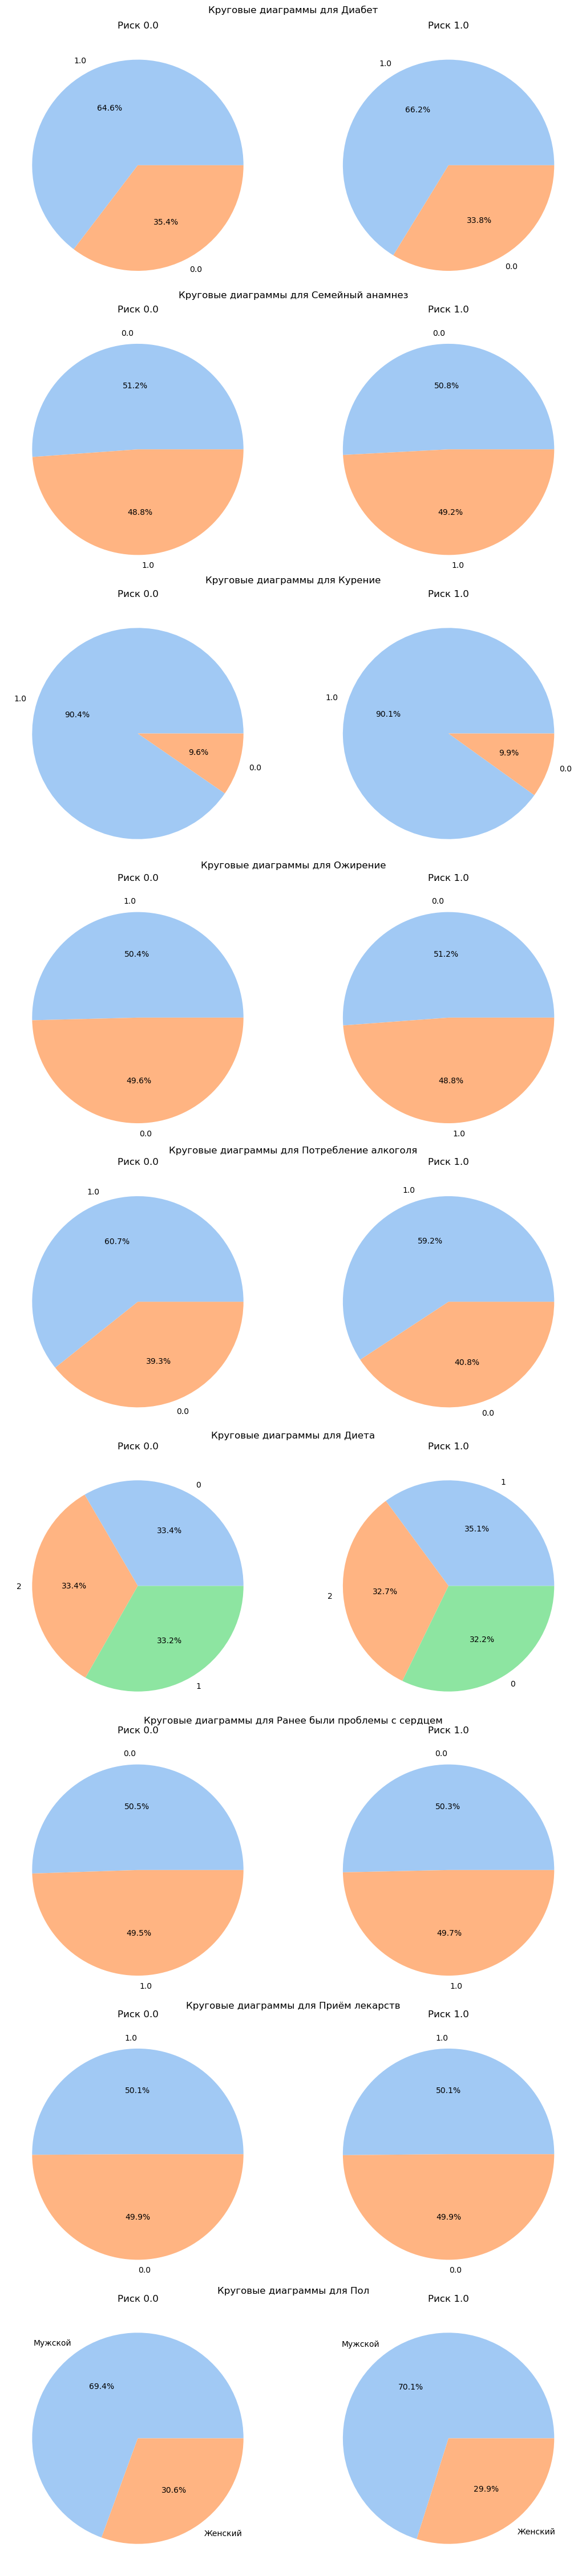

In [54]:
show_2_pies(train_df_rus[train_df_rus['Риск сердечного приступа'] == '0.0'], 
            train_df_rus[train_df_rus['Риск сердечного приступа'] == '1.0'],
            rus_cat_features,
            df_label='Риск 0.0', 
            df2_label='Риск 1.0')

Построим диаграммы рассеяния для некоторых пар признаков, чтобы выявить возможную коллинеарность.

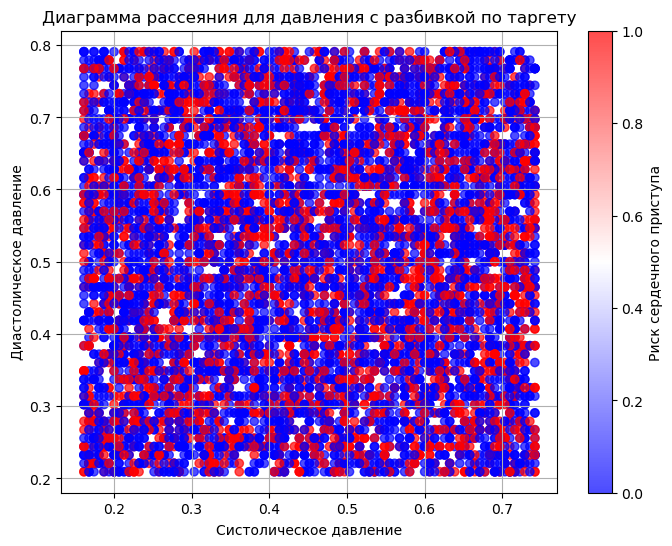

In [55]:
plt.figure(figsize=(8, 6))
plt.scatter(train_df_rus['Систолическое давление'], train_df_rus['Диастолическое давление'], 
            c=train_df_rus['Риск сердечного приступа'].astype('float'), cmap='bwr', alpha=0.7)
plt.xlabel('Систолическое давление')
plt.ylabel('Диастолическое давление')
plt.title('Диаграмма рассеяния для давления с разбивкой по таргету')
plt.colorbar(label='Риск сердечного приступа')
plt.grid(True)
plt.show()

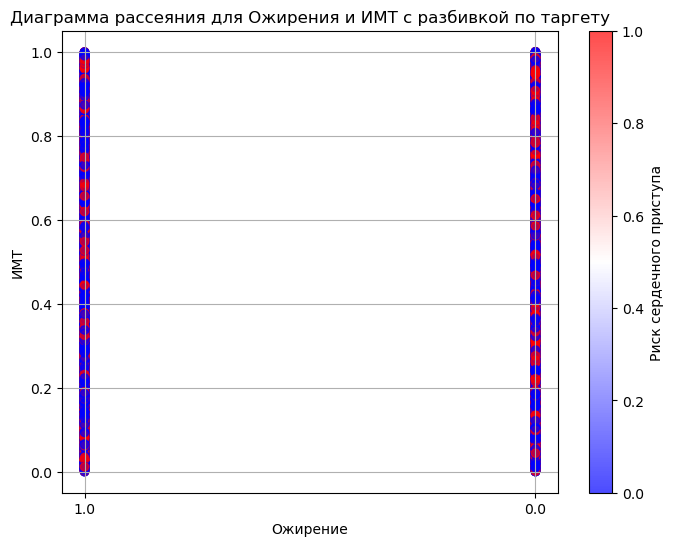

In [56]:
plt.figure(figsize=(8, 6))
plt.scatter(train_df_rus['Ожирение'], train_df_rus['ИМТ'], 
            c=train_df_rus['Риск сердечного приступа'].astype('float'), cmap='bwr', alpha=0.7)
plt.xlabel('Ожирение')
plt.ylabel('ИМТ')
plt.title('Диаграмма рассеяния для Ожирения и ИМТ с разбивкой по таргету')
plt.colorbar(label='Риск сердечного приступа')
plt.grid(True)
plt.show()

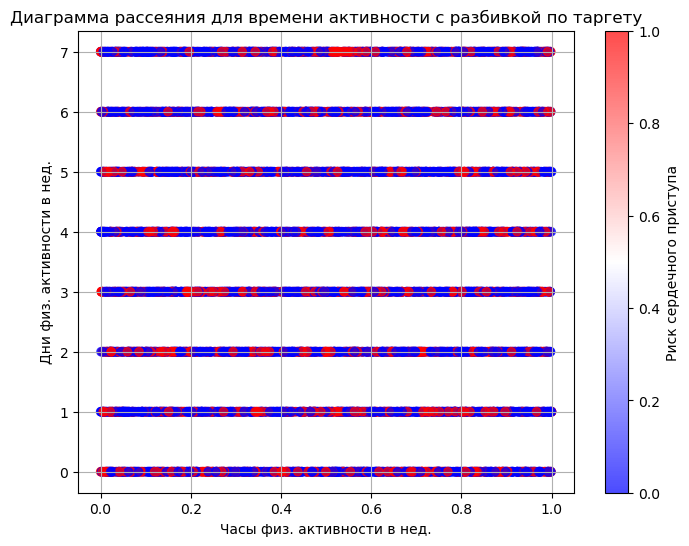

In [57]:
plt.figure(figsize=(8, 6))
plt.scatter(train_df_rus['Часы физ. активности в нед.'], train_df_rus['Дни физ. активности в нед.'], 
            c=train_df_rus['Риск сердечного приступа'].astype('float'), cmap='bwr', alpha=0.7)
plt.xlabel('Часы физ. активности в нед.')
plt.ylabel('Дни физ. активности в нед.')
plt.title('Диаграмма рассеяния для времени активности с разбивкой по таргету')
plt.colorbar(label='Риск сердечного приступа')
plt.grid(True)
plt.show()

**Итог статистического анализа:**

Распределение данных в тренировочной и тестовой таблицах примерно соответствуют друг другу с учетом того, что тестовая выборка имеет 935 строк, а тренировочная 8442 строк.

В следующих количественных признаках: 'Уровень стресса', 'Дни физ. активности в нед.', 'Сон (часы в день)', 'Возраст', 'Холестерин', 'Пульс', 'Часы физ. активности в нед.', 'Сидячие часы в день', 'Доход', 'ИМТ', 'Триглицериды', 'Систолическое давление', 'Диастолическое давление'
распределение данных равномерное, выбросов нет.

В столбцах 'Сахар в крови', 'КФК-МВ', 'Тропонин' имеется ярко выраженная мода и большое количество выбросов.

В категориальных признаках наблюдается относительно сбалансированное распределение по категориям.

Анализ распределения данных с разбивкой по таргету показал, что нет ярковыраженной разницы в распределениях данных по признакам в зависимости от значения целевого признака.

Предполагаемая мультиколлинеарность некоторых пар признаков не подтвердилась.

**3.4 Корреляционный анализ данных**

Проведем корреляционный анализ данных для тренировочной выборки.

In [58]:
#количественные непрерывные признаки
num_continuous_features = rus_num_features_discrete + rus_num_features_continuous_1 + rus_num_features_continuous_2

In [59]:
# Вычисляем матрицу корреляции phik для тренировочной выборки
train_corr_matrix = train_df_rus.drop(columns=['ID пациента']).phik_matrix(interval_cols=num_continuous_features)

# Выводим матрицу
train_corr_matrix

Возраст  Холестерин     Пульс    Диабет  \
Возраст                        1.000000    0.047296  0.096545  0.037166   
Холестерин                     0.047296    1.000000  0.046766  0.033748   
Пульс                          0.096545    0.046766  1.000000  0.023945   
Диабет                         0.037166    0.033748  0.023945  1.000000   
Семейный анамнез               0.000000    0.000000  0.000000  0.025809   
Курение                        0.620530    0.025223  0.027918  0.000000   
Ожирение                       0.000000    0.000000  0.002655  0.019436   
Потребление алкоголя           0.000000    0.051442  0.000000  0.000000   
Часы физ. активности в нед.    0.000000    0.058412  0.000000  0.000000   
Диета                          0.037997    0.000000  0.000000  0.000000   
Ранее были проблемы с сердцем  0.000000    0.000000  0.021318  0.000000   
Приём лекарств                 0.012601    0.000000  0.004333  0.000000   
Уровень стресса                0.052548    0.053361  0.057227  0.000000   
Сидячие часы в день            0.030078    0.050688  0.067030  0.036240   
Доход                          0.000000    0.037948  0.061804  0.006288   
ИМТ                            0.020033    0.016409  0.047465  0.010086   
Триглицериды                   0.059949    0.067432  0.000000  0.043154   
Дни физ. активности в нед.     0.010839    0.010897  0.020279  0.012481   
Сон (часы в день)              0.027290    0.030416  0.043306  0.027584   
Риск сердечного приступа       0.022225    0.000000  0.007342  0.018324   
Сахар в крови                  0.359543    0.000000  0.358178  0.000000   
КФК-МВ                         0.138603    0.037251  0.141705  0.000000   
Тропонин                       0.122965    0.023634  0.102284  0.025830   
Пол                            0.000000    0.029815  0.000000  0.000000   
Систолическое давление         0.033469    0.050402  0.039319  0.038714   
Диастолическое давление        0.039000    0.046545  0.044680  0.026201   

                               Семейный анамнез   Курение  Ожирение  \
Возраст                                0.000000  0.620530  0.000000   
Холестерин                             0.000000  0.025223  0.000000   
Пульс                                  0.000000  0.027918  0.002655   
Диабет                                 0.025809  0.000000  0.019436   
Семейный анамнез                       1.000000  0.000000  0.009305   
Курение                                0.000000  1.000000  0.000000   
Ожирение                               0.009305  0.000000  1.000000   
Потребление алкоголя                   0.005136  0.000000  0.020462   
Часы физ. активности в нед.            0.000000  0.008420  0.057019   
Диета                                  0.000000  0.000000  0.000000   
Ранее были проблемы с сердцем          0.000000  0.000000  0.000000   
Приём лекарств                         0.000000  0.000000  0.000000   
Уровень стресса                        0.024292  0.000000  0.037677   
Сидячие часы в день                    0.011677  0.010181  0.028106   
Доход                                  0.033165  0.000000  0.000000   
ИМТ                                    0.018612  0.010789  0.000000   
Триглицериды                           0.000000  0.034906  0.005890   
Дни физ. активности в нед.             0.027124  0.000000  0.016269   
Сон (часы в день)                      0.018189  0.008616  0.000000   
Риск сердечного приступа               0.000000  0.000000  0.015839   
Сахар в крови                          0.027865  0.115593  0.000000   
КФК-МВ                                 0.018601  0.017989  0.019953   
Тропонин                               0.000000  0.032929  0.022984   
Пол                                    0.000000  0.703385  0.000000   
Систолическое давление                 0.030289  0.000000  0.031370   
Диастолическое давление                0.024432  0.000000  0.049056   

                               Потребление алкоголя  \
Возраст                          

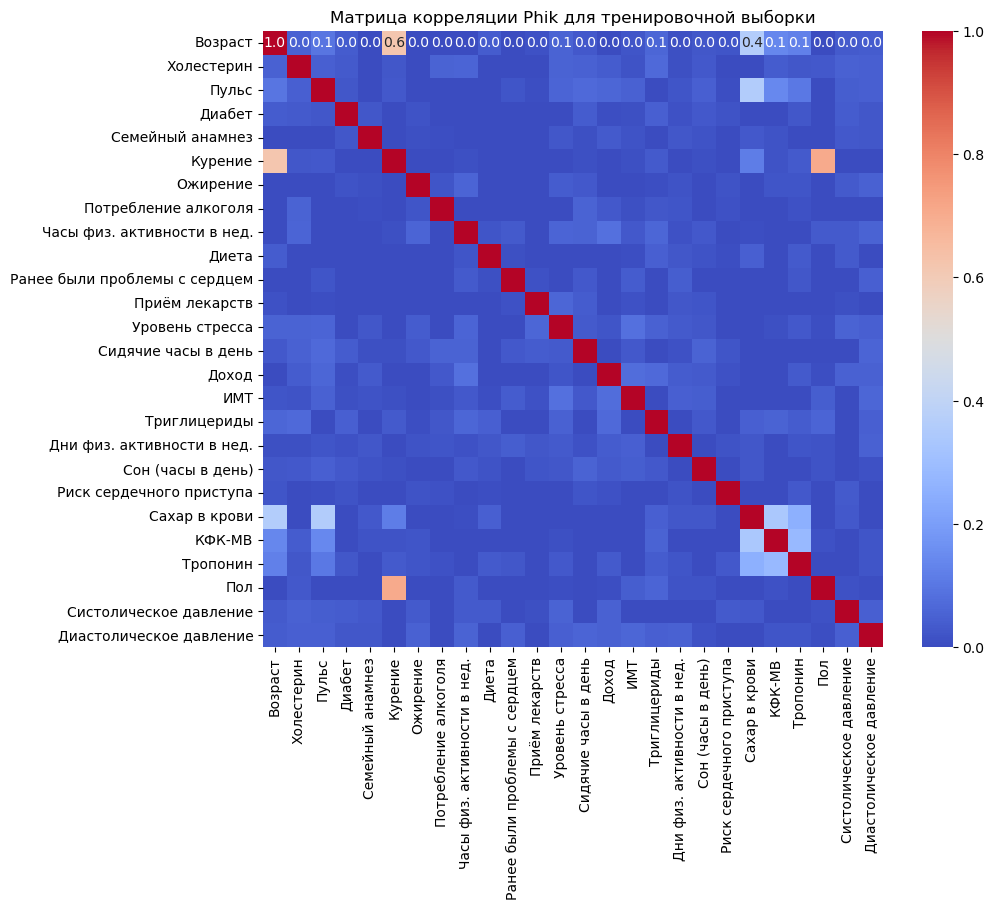

In [60]:
plt.figure(figsize=(10, 8))
sns.heatmap(train_corr_matrix, annot=True, cmap='coolwarm', fmt=".1f")
plt.title("Матрица корреляции Phik для тренировочной выборки")
plt.show()

In [61]:
print_corr_levels(train_corr_matrix)

[('Высокая корреляция между Курение и Пол:', 0.703),
 ('Заметная корреляция между Возраст и Курение:', 0.621),
 ('Умеренная корреляция между Возраст и Сахар в крови:', 0.36),
 ('Умеренная корреляция между Пульс и Сахар в крови:', 0.358),
 ('Умеренная корреляция между КФК-МВ и Сахар в крови:', 0.337),
 ('Слабая корреляция между КФК-МВ и Тропонин:', 0.284),
 ('Слабая корреляция между Сахар в крови и Тропонин:', 0.251),
 ('Слабая корреляция между КФК-МВ и Пульс:', 0.142),
 ('Слабая корреляция между Возраст и КФК-МВ:', 0.139),
 ('Слабая корреляция между Возраст и Тропонин:', 0.123),
 ('Слабая корреляция между Курение и Сахар в крови:', 0.116),
 ('Слабая корреляция между Пульс и Тропонин:', 0.102)]

Проведем корреляционный анализ данных для тестовой выборки.

In [62]:
# Вычисляем матрицу корреляции phik для тестовой выборки
test_corr_matrix = test_df_rus.drop(columns=['ID пациента']).phik_matrix(interval_cols=num_continuous_features)

# Выводим матрицу
test_corr_matrix

Возраст  Холестерин     Пульс    Диабет  \
Возраст                        1.000000    0.158516  0.097772  0.000000   
Холестерин                     0.158516    1.000000  0.051543  0.000000   
Пульс                          0.097772    0.051543  1.000000  0.025943   
Диабет                         0.000000    0.000000  0.025943  1.000000   
Семейный анамнез               0.000000    0.066631  0.045104  0.000000   
Курение                        0.620658    0.056488  0.000000  0.000000   
Ожирение                       0.000000    0.000000  0.000000  0.045362   
Потребление алкоголя           0.000000    0.000000  0.000000  0.000000   
Часы физ. активности в нед.    0.164039    0.056348  0.000000  0.000000   
Диета                          0.000000    0.000000  0.064337  0.016360   
Ранее были проблемы с сердцем  0.028667    0.000000  0.000000  0.066614   
Приём лекарств                 0.145115    0.000000  0.000000  0.000000   
Уровень стресса                0.017581    0.028923  0.049512  0.000000   
Сидячие часы в день            0.027356    0.090185  0.000000  0.000000   
Доход                          0.000000    0.122817  0.000000  0.000000   
ИМТ                            0.058662    0.103524  0.052541  0.059110   
Триглицериды                   0.000000    0.000000  0.000000  0.000000   
Дни физ. активности в нед.     0.017647    0.078272  0.014373  0.000000   
Сон (часы в день)              0.000000    0.000000  0.062327  0.000000   
Сахар в крови                  0.332615    0.000000  0.263363  0.000000   
КФК-МВ                         0.108654    0.000000  0.143440  0.077044   
Тропонин                       0.100566    0.000000  0.018785  0.036331   
Пол                            0.089973    0.000000  0.106397  0.000000   
Систолическое давление         0.000000    0.000000  0.118503  0.000000   
Диастолическое давление        0.069517    0.000000  0.064045  0.000000   

                               Семейный анамнез   Курение  Ожирение  \
Возраст                                0.000000  0.620658  0.000000   
Холестерин                             0.066631  0.056488  0.000000   
Пульс                                  0.045104  0.000000  0.000000   
Диабет                                 0.000000  0.000000  0.045362   
Семейный анамнез                       1.000000  0.000000  0.016966   
Курение                                0.000000  1.000000  0.066810   
Ожирение                               0.016966  0.066810  1.000000   
Потребление алкоголя                   0.000000  0.000000  0.084861   
Часы физ. активности в нед.            0.000000  0.058842  0.000000   
Диета                                  0.018749  0.015515  0.000000   
Ранее были проблемы с сердцем          0.033852  0.000000  0.000000   
Приём лекарств                         0.000000  0.000000  0.000000   
Уровень стресса                        0.061580  0.036845  0.094411   
Сидячие часы в день                    0.000000  0.053154  0.135976   
Доход                                  0.078518  0.000000  0.000000   
ИМТ                                    0.034167  0.000000  0.031210   
Триглицериды                           0.070015  0.000000  0.000000   
Дни физ. активности в нед.             0.072063  0.024390  0.000000   
Сон (часы в день)                      0.000000  0.000000  0.000000   
Сахар в крови                          0.000000  0.112617  0.100317   
КФК-МВ                                 0.008253  0.000000  0.000000   
Тропонин                               0.026650  0.000000  0.000000   
Пол                                    0.000000  0.710694  0.068489   
Систолическое давление                 0.000000  0.055555  0.083922   
Диастолическое давление                0.000000  0.059534  0.040671   

                               Потребление алкоголя  \
Возраст                                    0.000000   
Холестерин                                 0.000000   
Пульс                                      0.000000   
Диабет        

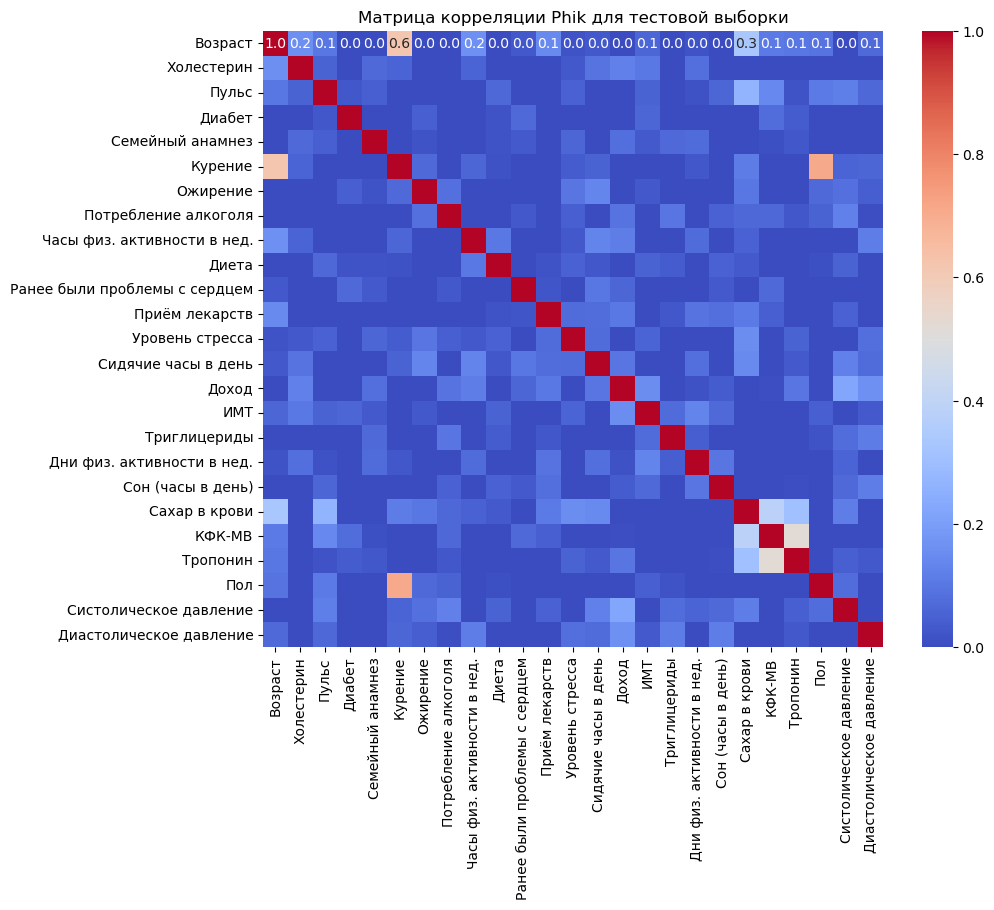

In [63]:
plt.figure(figsize=(10, 8))
sns.heatmap(test_corr_matrix, annot=True, cmap='coolwarm', fmt=".1f")
plt.title("Матрица корреляции Phik для тестовой выборки")
plt.show()

In [64]:
print_corr_levels(test_corr_matrix, threshold = 0.15)

[('Высокая корреляция между Курение и Пол:', 0.711),
 ('Заметная корреляция между Возраст и Курение:', 0.621),
 ('Заметная корреляция между КФК-МВ и Тропонин:', 0.523),
 ('Умеренная корреляция между КФК-МВ и Сахар в крови:', 0.384),
 ('Умеренная корреляция между Возраст и Сахар в крови:', 0.333),
 ('Умеренная корреляция между Сахар в крови и Тропонин:', 0.307),
 ('Слабая корреляция между Пульс и Сахар в крови:', 0.263),
 ('Слабая корреляция между Доход и Систолическое давление:', 0.223),
 ('Слабая корреляция между Возраст и Часы физ. активности в нед.:', 0.164),
 ('Слабая корреляция между Диастолическое давление и Доход:', 0.162),
 ('Слабая корреляция между Возраст и Холестерин:', 0.159),
 ('Слабая корреляция между Сахар в крови и Уровень стресса:', 0.155),
 ('Слабая корреляция между Доход и ИМТ:', 0.153)]

**Итог корреляционного анализа:**

Матрицы корреляции для тренировочной и тестовой выборок соответствуют друг другу.

Не было найдено значимых корреляций входных признаков с целевым признаком.

Входные признаки мало коррелируют между собой.

**Промежуточный итог:**

Распределение данных в основном равномерное и сбалансированное. 
При анализе распределений признаков с разбивкой по таргету не было найдено статистически значимой разницы в распределениях.

Признаки мало коррелируют между собой.

В следующих количественных признаках: 'Уровень стресса', 'Дни физ. активности в нед.', 'Сон (часы в день)', 'Возраст', 'Холестерин', 'Пульс', 'Часы физ. активности в нед.', 'Сидячие часы в день', 'Доход', 'ИМТ', 'Триглицериды', 'Систолическое давление', 'Диастолическое давление'
распределение данных равномерное, выбросов нет.

В столбцах 'Сахар в крови', 'КФК-МВ', 'Тропонин' имеется ярко выраженная мода и большое количество выбросов.

В результате исследования информации по данным признакам в интернете было установлено, что:
1. Уровень нормальный уровень сахара в крови имеет диапазон от 3,3 до 5,5 ммоль/л, в то время как опасными для жизни являются уровни ниже 1,65 ммоль/л выше 33 ммоль/л. Уровень сахара в крови часто повышается у пациентов после инфаркта миокарда. 
2. КФК-МВ - фермент, который является специфичным и чувствительным индикатором повреждения миокарда.
3. Сердечные тропонины, в частности тропонин I и тропонин T, используются в качестве биомаркеров для диагностики повреждений сердечной мышцы, особенно при инфаркте миокарда
Уровни КФК-МВ и Тропонина у людей, неперенесших сердечный приступ, близки к нулю. Появление данных маркеров в крови свидетельствует о перенесенном инфаркте миокарда.

КФК-МВ (ck_mb) и Сердечные тропонины (troponin) являются не предсказателями инфаркта, а следствием, то есть данные содержат косвеную утечку целевого признака, и эти столбцы для обучения моделей использоваться не будут.

Так как признаки имеют приблизительно одинаково низкую корреляцию с целевым признаком, предлагается отбор полезных признаков не проводить.

## 5. Обучение моделей

Создадим пайплайн для подготовки данных. 

В пайплайне проведем :
* масштабирование количественных признаков через StandardScaler или MinMaxScaler
* кодирование категориальных признаков. Для номинальных категориальных признков будем использовать кодировщик ОНЕ
* обработку пропусков через SimpleImputer.

In [65]:
# Укажем столбцы, которые не будут учавствовать в обучении моделей
drop_columns = ['id',
                'ck_mb', 
                'troponin',
                'heart_attack_risk_binary'] 

In [66]:
# Категориальные признаки номинальные:
ohe_columns = ['diabetes', 'family_history', 'smoking', 'obesity', 'alcohol_consumption', 'diet', 
               'previous_heart_problems', 'medication_use', 'gender']
# Количественные признаки:
num_columns = ['age','cholesterol', 'heart_rate', 'exercise_hours_per_week', 'stress_level', 'sedentary_hours_per_day',
               'income', 'bmi', 'triglycerides', 'physical_activity_days_per_week', 'sleep_hours_per_day',
               'blood_sugar', 'systolic_blood_pressure', 'diastolic_blood_pressure']
# Целевой признак
target_feature = 'heart_attack_risk_binary'

In [67]:
# Делим данные на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    train_df_prepared.drop(drop_columns, axis=1),
    train_df_prepared[target_feature],
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    stratify = train_df_prepared[target_feature]
)

In [68]:
# Создаем экземпляр LabelEncoder
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

In [69]:
# создаём пайплайн для подготовки признаков из списка ohe_columns: заполнение пропусков и OHE-кодирование
# SimpleImputer + OHE
ohe_pipe = Pipeline(
    [
        (
            'simpleImputer_ohe', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ohe', 
            OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)
        )
    ]
)

In [70]:
# создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('num', StandardScaler(), num_columns)
    ], 
    remainder='passthrough'
)

In [71]:
# создаем итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline(
    [
        ('preprocessor', 
         data_preprocessor
        ),
        ('models', 
        DecisionTreeClassifier(random_state=RANDOM_STATE)
        )
    ]
)

In [72]:
# Создадим сетку для перебора моделей и гиперпараметров
param_grid = [
    {
        'models': [LogisticRegression(solver='liblinear', random_state=RANDOM_STATE)], # liblinear эффективен для бинарной классификации
        'models__C': [0.001, 0.01, 0.1, 1, 10, 100],  # Сила регуляризации
        'models__penalty': ['l1', 'l2'],   
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(3, 7),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(3, 10),  # Глубина дерева
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    {
        'models': [RandomForestClassifier(random_state=RANDOM_STATE)],
        'models__n_estimators': [150],  # Количество деревьев
        'models__max_depth': range(3, 10),  
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    {
        'models': [CatBoostClassifier(verbose=0, random_state=RANDOM_STATE)],
        'models__depth': [4, 6, 8],
        'models__learning_rate': [0.01, 0.1],
        'models__iterations': [1000],
        'preprocessor__num': ['passthrough']
    }
]

In [73]:
# Запуск GridSearchCV для поиска лучшей модели и гиперпараметров
grid = GridSearchCV(
    pipe_final, 
    param_grid=param_grid, 
    cv=5, 
    scoring='roc_auc',  
    n_jobs=-1  
)
grid.fit(X_train, y_train)

# выведем параметры и метрику лучшей модели
print('Лучшая модель и её параметры:\n\n', grid.best_estimator_)
print('\nМетрика ROC-AUC для лучшей модели:', grid.best_score_) 

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['diabetes', 'family_history',
                                                   'smoking', 'obesity',
                                                   'alcohol_consumption',
                   

In [74]:
# Оцениваем модель на тестовом наборе
y_test_pred_proba = grid.predict_proba(X_test)[:, 1]
y_test_pred = grid.predict(X_test)
print('Метрики на тестовой выборке:')
print('ROC-AUC:', round(roc_auc_score(y_test, y_test_pred_proba), 5))
print("Accuracy:", round(accuracy_score(y_test, y_test_pred), 3))
print("Precision:", round(precision_score(y_test, y_test_pred), 3))
print("Recall:", round(recall_score(y_test, y_test_pred), 3))
print("F1 score:", round(f1_score(y_test, y_test_pred), 3))

Метрики на тестовой выборке:
ROC-AUC: 0.58944
Accuracy: 0.631
Precision: 0.464
Recall: 0.22
F1 score: 0.299


Из всех пациентов модель нашла только 22% реально больных. Это очень плохой показатель.

Изменим порог классификации так, чтобы повысить Recall. При этом будем ориентироваться на Accuracy > 0.5

In [75]:
# Устанавливаем порог
threshold = 0.105 
y_test_pred_custom = (y_test_pred_proba >= threshold).astype(int)


print('Метрики на тестовой выборке:')
print('ROC-AUC:', round(roc_auc_score(y_test, y_test_pred_proba), 5))
print("Accuracy:", round(accuracy_score(y_test, y_test_pred_custom), 3))
print("Precision:", round(precision_score(y_test, y_test_pred_custom), 3))
print("Recall:", round(recall_score(y_test, y_test_pred_custom), 3))
print("F1 score:", round(f1_score(y_test, y_test_pred_custom), 3))

Метрики на тестовой выборке:
ROC-AUC: 0.58944
Accuracy: 0.504
Precision: 0.399
Recall: 0.772
F1 score: 0.526


Сравним полученную модель с DummyClassifier.

In [76]:
# Создаём и обучаем DummyClassifier
dummy = DummyClassifier(strategy="stratified")  # всегда предсказывает наиболее частый класс
dummy.fit(X_train, y_train)

# Предсказания
y_pred_proba_dummy = dummy.predict_proba(X_test)[:, 1]
y_pred_dummy = dummy.predict(X_test)
y_pred_dummy_custom = (y_pred_proba_dummy >= threshold).astype(int)
# Оцениваем DummyClassifier на тестовом наборе
print('Метрики на тестовой выборке для DummyClassifier:')
print('ROC-AUC:', round(roc_auc_score(y_test, y_pred_proba_dummy), 5))
print("Accuracy:", round(accuracy_score(y_test, y_pred_dummy_custom), 3))
print("Precision:", round(precision_score(y_test, y_pred_dummy_custom), 3))
print("Recall:", round(recall_score(y_test, y_pred_dummy_custom), 3))
print("F1 score:", round(f1_score(y_test, y_pred_dummy_custom), 3))

Метрики на тестовой выборке для DummyClassifier:
ROC-AUC: 0.50263
Accuracy: 0.542
Precision: 0.36
Recall: 0.364
F1 score: 0.362


DummyClassifier имеет выше Accuracy, но по остальным параметрам проигрывает обученной модели.

**Сохраним модель в файл и повторим предсказания на сохраненной модели**

In [77]:
# Сохраняем её в файл
joblib.dump(grid.best_estimator_, 'best_model.pkl')
joblib.dump(X_train.columns.tolist(), 'best_model_feature_list.pkl')

['best_model_feature_list.pkl']

In [78]:
import model_utils_tatarnikov as mu

In [79]:
wrapped_model = mu.PredictZeroIfMissing(joblib.load('best_model.pkl'))
wrapped_model_pred_proba = wrapped_model.predict_proba(X_test)[:, 1]
threshold = 0.105 
wrapped_model_pred_custom = (wrapped_model_pred_proba >= threshold).astype(int)

print('Метрики на тестовой выборке:')
print('ROC-AUC:', round(roc_auc_score(y_test, wrapped_model_pred_proba), 5))
print("Accuracy:", round(accuracy_score(y_test, y_test_pred_custom), 3))
print("Precision:", round(precision_score(y_test, y_test_pred_custom), 3))
print("Recall:", round(recall_score(y_test, y_test_pred_custom), 3))
print("F1 score:", round(f1_score(y_test, y_test_pred_custom), 3))

print('\nПроверка на точность сохранения модели:')
print('ROC-AUC:', round(roc_auc_score(y_test_pred_custom, wrapped_model_pred_proba), 5))
print("Accuracy:", round(accuracy_score(y_test_pred_custom, wrapped_model_pred_custom), 3))
print("Precision:", round(precision_score(y_test_pred_custom, wrapped_model_pred_custom), 3))
print("Recall:", round(recall_score(y_test_pred_custom, wrapped_model_pred_custom), 3))
print("F1 score:", round(f1_score(y_test_pred_custom, wrapped_model_pred_custom), 3))

Метрики на тестовой выборке:
ROC-AUC: 0.58944
Accuracy: 0.504
Precision: 0.399
Recall: 0.772
F1 score: 0.526

Проверка на точность сохранения модели:
ROC-AUC: 1.0
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 score: 1.0


Модель сохранилась без потерь.

**Промежуточный итог:**

Для решения задачи были использованы модели: LogisticRegression, KNeighborsClassifier, DecisionTreeClassifier, RandomForestClassifier, CatBoostClassifier. 

Лучшей моделью оказалась CatBoostClassifier с метрикой ROC-AUC на тестовой выборке 0.58944
после установления порога классификации 0.105 метрики модели стали: 
Accuracy: 0.504,
Precision: 0.399,
Recall: 0.772.

В ходе предобработки данных было установленно, что строки с пропусками всегда имеют целевой признак '0.0'. Для обработки данных с пропусками модель была обернута в класс который предсказывает '0.0', если в данных есть пропуск, и применяет модель для предсказания во всех других случаях.

## 6. Анализ важности признаков

Оценим важность признаков лучшей модели. Для оценки будем использовать метод SHAP.

In [80]:
# Подготовим модель и данные
best_pipeline = grid.best_estimator_
model = best_pipeline.named_steps['models']
X_train_encoded = best_pipeline['preprocessor'].transform(X_train)
X_test_encoded = best_pipeline['preprocessor'].transform(X_test)

In [81]:
explainer = shap.PermutationExplainer(model.predict_proba, X_train_encoded)

In [82]:
shap_values = explainer(X_test_encoded)

PermutationExplainer explainer: 2112it [07:05,  4.88it/s]                                                              


In [83]:
try:
    # Пробуем получить имена признаков из препроцессора
    labels = best_pipeline['preprocessor'].get_feature_names_out()
except AttributeError:
    # Если не удаётся получить имена признаков, используем имена из X_train
    labels = X_train.columns
    
labels

array(['ohe__diabetes_1.0', 'ohe__family_history_1.0', 'ohe__smoking_1.0',
       'ohe__obesity_1.0', 'ohe__alcohol_consumption_1.0', 'ohe__diet_1',
       'ohe__diet_2', 'ohe__previous_heart_problems_1.0',
       'ohe__medication_use_1.0', 'ohe__gender_Male', 'num__age',
       'num__cholesterol', 'num__heart_rate',
       'num__exercise_hours_per_week', 'num__stress_level',
       'num__sedentary_hours_per_day', 'num__income', 'num__bmi',
       'num__triglycerides', 'num__physical_activity_days_per_week',
       'num__sleep_hours_per_day', 'num__blood_sugar',
       'num__systolic_blood_pressure', 'num__diastolic_blood_pressure'],
      dtype=object)

In [84]:
labels_rus = [
    'ohe__Диабет_1.0',
    'ohe__Семейный анамнез_1.0',
    'ohe__Курение_1.0',
    'ohe__Ожирение_1.0',
    'ohe__Потребление алкоголя_1.0',
    'ohe__Диета_1',
    'ohe__Диета_2',
    'ohe__Ранее были проблемы с сердцем_1.0',
    'ohe__Приём лекарств_1.0',
    'ohe__Пол_Мужской',
    'num__Возраст',
    'num__Холестерин',
    'num__Пульс',
    'num__Часы физ. активности в нед.',
    'num__Уровень стресса',
    'num__Сидячие часы в день',
    'num__Доход',
    'num__ИМТ',
    'num__Триглицериды',
    'num__Дни физ. активности в нед.',
    'num__Сон (часы в день)',
    'num__Сахар в крови',
    'num__Систолическое давление',
    'num__Диастолическое давление'
]

In [85]:
shap_values_fixed = shap.Explanation(
    values=shap_values.values[..., 1],
    base_values=shap_values.base_values[..., 1],  
    data=X_test_encoded,  
    feature_names=labels_rus
)

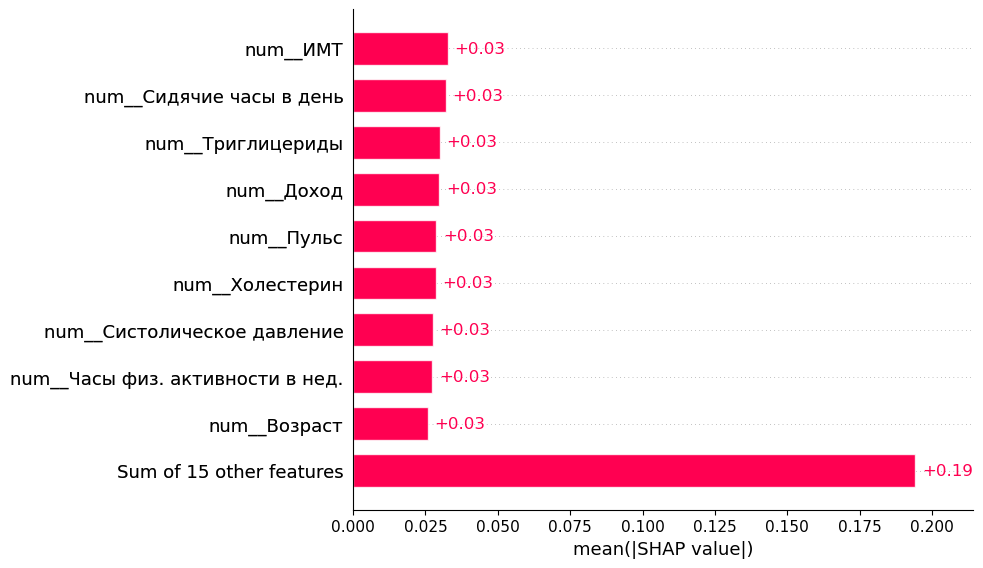

In [86]:
shap.plots.bar(shap_values_fixed)

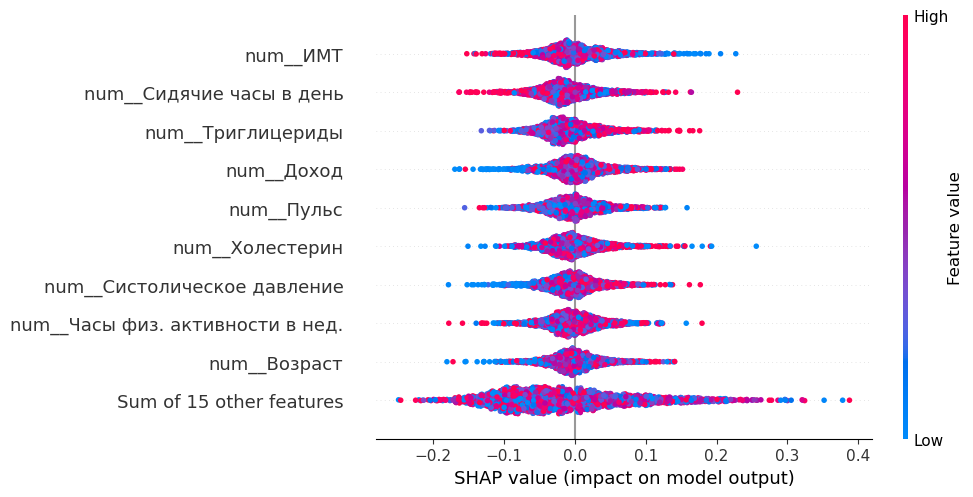

In [87]:
shap.plots.beeswarm(shap_values_fixed) 

**Промежуточный итог:**

Анализ важности признаков показал, что ни один из признаков не вностит значимый вклад в предсказание модели. 

Наибольее важными признаками для предсказания сердечного приступа полученной моделью: ИМТ, Сидячие часы в день, Триглицериды, Доход, Пульс, Холестерин, Систолическое давление, Часы физ. активности в неделю, Возраст..

## Общий вывод

**Целью проекта** было создание модели машинного обучения для прогнозирования риска сердечного приступа на основе медицинских данных пациентов, а также подготовка библиотеки и API-интерфейса для прикладного использования модели.

**Задачи**, которые были решены:
* Загрузка и предобработка данных, включая удаление пропусков, приведение типов и переименование столбцов;
* Проведение исследовательского анализа данных и выявление особенностей распределения признаков;
* Анализ корреляций и проверка на мультиколлинеарность;
* Исключение признаков, содержащих утечку целевого признака (КФК-МВ, тропонин);
* Обучение нескольких моделей и выбор наилучшей по метрике ROC-AUC;
* Реализация обработки строк с пропущенными значениями через обёртку к модели;
* Оценка важности признаков с использованием SHAP-метода.

**Ключевые выводы:**

* Данные преимущественно сбалансированы и равномерно распределены, выбросы обнаружены только в некоторых биомаркерах;
* Признаки слабо коррелируют с целевым признаком, а их важность по SHAP-оценке крайне низкая (не более 0.03);
* Модель CatBoostClassifier показала наилучший результат (ROC-AUC = 0.589), но общая точность модели остаётся низкой;
* Наиболее значимыми признаками (относительно других) оказались ИМТ, сидячий образ жизни, триглицериды, доход, пульс, холестерин и возраст, однако их вклад в итоговое предсказание оказался минимальным.

**Предложения:**

* Увеличить объём и разнообразие обучающих данных;

* Пересмотреть состав признаков и добавить клинически обоснованные параметры, например ЛПНП, ЛПВП, гомоцистеин, натрий, калий, магний, кальций и так далее;

* Проработать возможность добавления в таблицу результатов обследований на сердечно-сосудистые заболевания, таких как ЭКГ, СМАД, Ангиография и так далее.